<a href="https://colab.research.google.com/github/lorenzflow/Computational-Statistics-Project-1/blob/master/Thesis_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Data set from drive



### mount drive

In [14]:
# connect drive to save models after training
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


### load data and packages

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
import glob
file_dir='./drive/My Drive/ThesisData/individual_stocks_5yr'
file_names = glob.glob('{}/*.csv'.format(file_dir))

In [ ]:
print(file_names[2])

./drive/My Drive/ThesisData/individual_stocks_5yr/AME_data.csv


In [ ]:
data = pd.read_csv(file_names[2])

In [ ]:
data.head

<bound method NDFrame.head of             date   open   high      low  close   volume Name
0     2013-02-08  41.22  41.57  41.0140  41.46   315562  AME
1     2013-02-11  41.37  41.52  40.9300  41.51   773702  AME
2     2013-02-12  41.51  41.98  41.3100  41.82   794051  AME
3     2013-02-13  41.87  42.04  41.6901  42.00   669581  AME
4     2013-02-14  41.81  42.01  41.7700  41.91   332685  AME
...          ...    ...    ...      ...    ...      ...  ...
1254  2018-02-01  77.31  78.51  76.1500  77.91  1625763  AME
1255  2018-02-02  77.84  78.37  77.1600  77.25  1949820  AME
1256  2018-02-05  76.78  77.46  73.8800  73.90  2557551  AME
1257  2018-02-06  72.41  75.32  71.5850  74.71  2698939  AME
1258  2018-02-07  74.25  75.00  74.1000  74.16  1569087  AME

[1259 rows x 7 columns]>

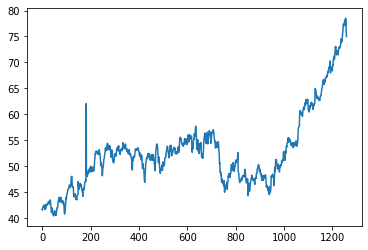

In [ ]:
import matplotlib.pyplot as plt

plt.plot(data['high'])

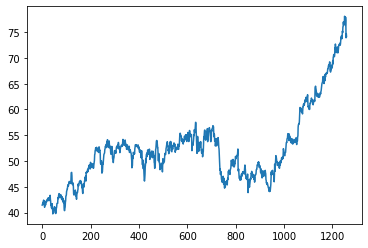

In [ ]:
plt.plot(data['close'])

In [ ]:

def load_dataset(batch_size, shuffle_buffer=None, file_dir='./drive/My Drive/ThesisData/individual_stocks_5yr'):
    """
    This function should create a tf.data.Dataset object for one of the train/valid/test
    splits, according to the above specification.
    It should then return the Dataset.
    """
    dataset = tf.data.Dataset.list_files('{}/*.csv'.format(file_dir), shuffle=False)
    
    def load_file(filepath):
        raw_data = np.read_csv(filepath) 
      
        return
    
    dataset = dataset.map(load_file)
    if shuffle_buffer is not None:
        dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Sample from GP
sampling from GP with RBF kernel to create train set for piVAE

In [2]:
from sklearn import gaussian_process
import numpy as np
GP = gaussian_process.GaussianProcessRegressor(optimizer='fmin_l_bfgs_b', 
                              n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, random_state=None)

In [3]:
def sample_batch(batch_size, num_points, GP, lower, upper, x=None):
  if x==None:
    X = np.random.uniform(lower, upper, (batch_size,num_points))
    Y = np.zeros_like(X)
    for i in range(batch_size):
      Y[i,:] = np.squeeze(GP.sample_y(X[i,:].reshape(-1, 1)))
    return np.expand_dims(X,-1),np.expand_dims(Y,-1)
  else: # num_ points equally spaced points between lower and upper
    x = np.linspace(lower, upper, num_points)
    #for i in range(batch_size):
    Y = GP.sample_y(x[:, np.newaxis], batch_size)
    return x, np.expand_dims(Y,-1)
  


gp_dataset = [sample_batch(100, 100, GP, 0, 4, x=1) for i in range(5)]

In [4]:
X,Y = gp_dataset[1]
print(X.shape)
Y.shape

(100,)


(100, 100, 1)

# PiVAE

In [ ]:
!pip install scikit-fda

     |████████████████████████████████| 286kB 7.7MB/s 
     |████████████████████████████████| 4.0MB 35.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 962kB 24.8MB/s 
     |████████████████████████████████| 71kB 7.1MB/s 
  Created wheel for fdasrsf: filename=fdasrsf-2.3.1-cp37-cp37m-linux_x86_64.whl size=1503586 sha256=8638510c69592be6d3f393fc393851d1e3e5b17f2ac1d40e0b3e77c1c775a5b5
  Stored in directory: /root/.cache/pip/wheels/85/0f/48/237088e67ff4144f880004650d7f289bff69382bcacf128e15
Successfully built fdasrsf
  Created wheel for findiff: filename=findiff-0.8.9-cp37-none-any.whl size=29227 sha256=cfd6349d1521c83498f09fbc276a8a98cbac57ff48edd543bc65306286e974ce
  Stored in directory: /root/.cache/pip/wheels/11/24/9f/5f0a2414302f708f5cac01fede118615cb3679437787f1632f
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2564974 sha256=e

In [ ]:
from skfda.representation.basis import Fourier

 /usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning:The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.


In [ ]:
# Fourier Basis Layer, subclassing layer class
# evaluates a fourier basis functions up to dimensions n at each input 
from tensorflow.keras.layers import Layer

class FourierLayer(Layer):
    def __init__(self, units, gamma, **kwargs):
        super(FourierLayer, self).__init__(**kwargs)
        self.units = units # number of dimensions, needs to be odd as required by fourier basis
        self.basis = Fourier(n_basis=units) # fourier basis of  initialise basis

    def build(self, input_shape):
        self.mu = self.add_weight(name='mu',
                                  shape=(int(input_shape[1]), self.units),
                                  initializer='uniform',
                                  trainable=True)
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        return self.basis(inputs)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [ ]:
import numpy as np
basis = Fourier(n_basis=40)
points = np.random.normal(size=(20,))

basis(points).shape

(41, 20, 1)

## online base implementation of the model

In [ ]:
# ---------------------------------------------------------
# TensorFlow piVAE Utils
# Licensed under The MIT License [see LICENSE for details]
# Written Lukas Adam
# Email: gm.lukas.adam@gmail.com
# ---------------------------------------------------------

def _pairwise_squared_distance_matrix(x):
    """Pairwise squared distance among a (batch) matrix's rows (2nd dim).
    This saves a bit of computation vs. using
    _cross_squared_distance_matrix(x,x)
    Args:
      x: `[batch_size, n, d]` float `Tensor`
    Returns:
      squared_dists: `[batch_size, n, n]` float `Tensor`, where
      squared_dists[b,i,j] = ||x[b,i,:] - x[b,j,:]||^2
    """

    x_x_transpose = tf.matmul(x, x, adjoint_b=True)
    x_norm_squared = tf.linalg.diag_part(x_x_transpose)
    x_norm_squared_tile = tf.expand_dims(x_norm_squared, 2)

    # squared_dists[b,i,j] = ||x_bi - x_bj||^2 =
    # = x_bi'x_bi- 2x_bi'x_bj + x_bj'x_bj
    squared_dists = x_norm_squared_tile - 2 * x_x_transpose + tf.transpose(
        x_norm_squared_tile, [0, 2, 1])

    return squared_dists


def _cross_squared_distance_matrix(x, y):
    """Pairwise squared distance between two (batch) matrices' rows (2nd dim).
    Computes the pairwise distances between rows of x and rows of y
    Args:
      x: [batch_size, n, d] float `Tensor`
      y: [batch_size, m, d] float `Tensor`
    Returns:
      squared_dists: [batch_size, n, m] float `Tensor`, where
      squared_dists[b,i,j] = ||x[b,i,:] - y[b,j,:]||^2
    """
    x_norm_squared = tf.reduce_sum(tf.square(x), 2)
    y_norm_squared = tf.reduce_sum(tf.square(y), 2)

    # Expand so that we can broadcast.
    x_norm_squared_tile = tf.expand_dims(x_norm_squared, 2)
    y_norm_squared_tile = tf.expand_dims(y_norm_squared, 1)

    x_y_transpose = tf.matmul(x, y, adjoint_b=True)

    # squared_dists[b,i,j] = ||x_bi - y_bj||^2 =
    # x_bi'x_bi- 2x_bi'x_bj + x_bj'x_bj
    squared_dists = (
        x_norm_squared_tile - 2 * x_y_transpose + y_norm_squared_tile)

    return squared_dists

def _phi(r, order=2, epsilon=0.0000000001):
        """Coordinate-wise nonlinearity used to define the order of the
        interpolation.
        See https://en.wikipedia.org/wiki/Polyharmonic_spline for the definition.
        Args:
          r: input op
          order: interpolation order
        Returns:
          phi_k evaluated coordinate-wise on r, for k = r
        """

        # using epsilon prevents log(0), sqrt0), etc.
        # sqrt(0) is well-defined, but its gradient is not
        with tf.name_scope('phi'):
            if order == 1:
                r = tf.maximum(r, epsilon)
                r = tf.sqrt(r)
                return r
            elif order == 2:
                return 0.5 * r * tf.math.log(tf.maximum(r, epsilon))
            elif order == 4:
                return 0.5 * tf.square(r) * tf.math.log(tf.maximum(r, epsilon))
            elif order % 2 == 0:
                r = tf.maximum(r, epsilon)
                return 0.5 * tf.pow(r, 0.5 * order) * tf.math.log(r)
            else:
                r = tf.maximum(r, epsilon)
                return tf.pow(r, 0.5 * order)

def _solve_interpolation(c, f, order=1, regularization_weight=1.0):
    # These dimensions are set dynamically at runtime.
    b, n, _ = tf.unstack(tf.shape(c), num=3)
        
    d = c.shape[-1]
    if d is None:
        raise ValueError('The dimensionality of the input points (d) must be '
                         'statically-inferrable.')
    
    k = f.shape[-1]
    if k is None:
        raise ValueError('The dimensionality of the output values (k) must be '
                         'statically-inferrable.')
        
    # Then calculate pairwise distance between centers
    pairwise_dists = _pairwise_squared_distance_matrix(c)
        
    # Transformed pairwise dists
    matrix_a = _phi(pairwise_dists, order=order) 
        
    ###########
        
    if regularization_weight > 0:
        batch_identity_matrix = tf.expand_dims(tf.eye(n, dtype=c.dtype), 0)
        matrix_a += regularization_weight * batch_identity_matrix

    # Append ones to the feature values for the bias term
    # in the linear model.
    ones = tf.ones_like(c[..., :1], dtype=c.dtype)
    matrix_b = tf.concat([c, ones], 2)  # [b, n, d + 1]

    # [b, n + d + 1, n]
    left_block = tf.concat(
            [matrix_a, tf.transpose(matrix_b, [0, 2, 1])], 1)

    num_b_cols = matrix_b.get_shape()[2]  # d + 1
    lhs_zeros = tf.zeros([b, num_b_cols, num_b_cols], c.dtype)
    right_block = tf.concat([matrix_b, lhs_zeros],
                                1)  # [b, n + d + 1, d + 1]
    lhs = tf.concat([left_block, right_block],
                        2)  # [b, n + d + 1, n + d + 1]

    rhs_zeros = tf.zeros([b, d + 1, k], c.dtype)
    rhs = tf.concat([f, rhs_zeros], 1)  # [b, n + d + 1, k]

    # Then, solve the linear system and unpack the results.
    with tf.name_scope('solve_linear_system'):
        linear_basis = tf.cast(tf.linalg.solve(lhs, rhs), tf.float64)
           
    return linear_basis

In [ ]:
# ---------------------------------------------------------
# TensorFlow piVAE Encoder & Decoder Models
# Licensed under The MIT License [see LICENSE for details]
# Written by Lukas Adam
# Email: gm.lukas.adam@gmail.com
# ---------------------------------------------------------

# Imports
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras import Model
from tensorflow.keras import backend as K

tfd = tfp.distributions

# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def _sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))

    return z_mean + K.exp(0.5 * (z_log_var)) * epsilon

##################################################

def vae_encoder(input_shape, intermediate_dim, latent_dim, sampling=_sampling):
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Dense(intermediate_dim[0], activation='relu')(inputs)
    for i in intermediate_dim[1:]:
      x = Dense(i, activation='relu')(x)

    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')

    return encoder

##################################################

def vae_decoder(latent_dim, intermediate_dim, original_dim):
    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(intermediate_dim[-1], activation='relu')(latent_inputs)
    
    for i in intermediate_dim[-2::-1]:
      x = Dense(i, activation='relu')(x)

    outputs = Dense(original_dim)(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    
    return decoder

In [ ]:
# ---------------------------------------------------------
# TensorFlow piVAE Eager implementation
# Licensed under The MIT License [see LICENSE for details]
# Written by Lukas Adam
# Email: gm.lukas.adam@gmail.com
# ---------------------------------------------------------

# Imports

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras import Model
from tensorflow.keras import backend as K

#from models.vae import vae_encoder, vae_decoder
#from models.utils import _phi, _pairwise_squared_distance_matrix, _cross_squared_distance_matrix, _solve_interpolation

class piVAE:
    
    """
    Class containing the rebuild code basis for a prior encoding variational
    autoencoder. piVAE was implemented in TF 2.0.
    """
    
    def __init__(self, config):
        """
        
        Initialization
        
        Parameters:
        config (dict): build config for piVAE
        """
        
        # Store build config 
        self.config = config

        # Store latent distribution
        self.z_mean_list = []
        self.z_log_var_list = []
        
        # Define array to store all trainable variables here
        self.trainable_variables = []
        
        # Build model then
        self.__build__()
    
    #######################################################################################################################
        
    def __build__(self, init='normal'):
        """
        
        Function that loads standard VAE encoder and decoder modules and initializes weights for the trainable linear basis 
        Parameters:
        init (str): Type of weights initialization
        """
        
        # Load standard vae encoder and decoder from models
        
        self.encoder = vae_encoder(
            input_shape=self.config['encoder_dim']+2, 
            intermediate_dim=self.config['intermediate_dim'], 
            latent_dim=self.config['latent_dim']  
        )
        
        self.decoder = vae_decoder(
            latent_dim=self.config['latent_dim'],
            intermediate_dim=self.config['intermediate_dim'], 
            original_dim=self.config['encoder_dim']+2)
        
        # Now store all trainable variables
        
        self.trainable_variables.extend(self.encoder.trainable_variables)
        self.trainable_variables.extend(self.decoder.trainable_variables)
    
    #######################################################################################################################
    
    def __vae__(self, lb):
            
        """
        
        Standard VAE here
        """
        
        # Encode function proposals
        
        self.z_mean, self.z_log_var, self.z = self.encoder(lb)

        # append updated values to lists to check convergence
        self.z_mean_list.append(self.z_mean)
        self.z_log_var_list.append(self.z_log_var)
        
        # Decode latent sample and reconstruct linear basis
        lb_reconstruct = self.decoder(self.z)
            
        return lb_reconstruct
    
    #######################################################################################################################
       
    def __solve__(self, c, f):
        
        """
        
        Function that solves a linear system from the generated function values and real evaluations. 
        
        Returns: a linear basis abstracted from the equation
        
        """
        
        return _solve_interpolation(c, f, self.config['order'], self.config['regularization_weight'])
        
    #######################################################################################################################
    
    def __mat_op__(self, phi_dists, bias, w, v):
        
        rbf_term = tf.matmul(phi_dists, w)
        
        linear_term = tf.matmul(bias, v)
        
        return rbf_term + linear_term
        
    #######################################################################################################################
    
    def __eval__(self, c, linear_basis, f=None, q=None, training=True):
        
        # These dimensions are set dynamically at runtime.
        b, n, _ = tf.unstack(tf.shape(c), num=3)

        w = linear_basis[:, :n, :]
        v = linear_basis[:, n:, :]
            
        if training:
            # Then calculate pairwise distance between centers
            pairwise_dists = _pairwise_squared_distance_matrix(c)
        
            # Transformed pairwise dists
            phi_dists = _phi(pairwise_dists, order=self.config['order']) 
            
            # Then, compute the contribution from the linear term.
            # Pad query_points with ones, for the bias term in the linear model.
            bias = tf.concat([
                f,
                tf.ones_like(f[..., :1], c.dtype)
            ], 2)
            
        else:
            # First, compute the contribution from the rbf term.
            pairwise_dists = _cross_squared_distance_matrix(q, c)

            phi_dists = _phi(pairwise_dists, order=self.config['order'])

            # Then, compute the contribution from the linear term.
            # Pad query_points with ones, for the bias term in the linear model.
            bias = tf.concat([
                q,
                tf.ones_like(q[..., :1], c.dtype)
            ], 2)

        return self.__mat_op__(
                phi_dists=phi_dists,
                bias=bias,
                w=w,
                v=v
            )
       
      
    #######################################################################################################################
        
    def __train__(self, train_points, train_values, regularization_weight=1.0):
        
        """
        
        Function that is used when training the model. Eager execution is applied. 
        
        Requires:
        train points (np.ndarray): X-axis values
        """
        
        ###########################################
        
        # Squeeze and unsqueeze linear basis
        def squeeze(lb):
            return tf.squeeze(lb, axis=2)
        
        def unsqueeze(lb):
            return tf.cast(tf.expand_dims(lb, axis=2), tf.float64)
        
        ###########################################
        
        if not isinstance(train_points, np.ndarray) and not isinstance(train_values, np.ndarray):
            raise TypeError('training must be performed with numpy array')
        
        # First convert training points to tf
        train_points = tf.convert_to_tensor(train_points)
        train_values = tf.convert_to_tensor(train_values)
        
        ##################################################################
        
        linear_basis = self.__solve__(train_points, train_values)
        
        linear_basis_reconstruct = unsqueeze(self.__vae__(squeeze(linear_basis))) # here self.z_mean and self.z_log_var get updated
        
        ##################################################################
        
        # TO-DO: Try to also encode inverse element of vector by decoding a-a = 0 of z-mean
        
        ##################################################################
        
        return linear_basis, linear_basis_reconstruct, self.z_mean, self.z_log_var
    
    
##########################################################################

def pivae_loss(model, x, y=None, regularization_weight=1.0):
    
    def reconstruction_loss(y1, y2, loss_function='mse'):
        
        if loss_function == 'mae':
            loss = tf.reduce_sum(tf.keras.losses.MAE(y1, y2))
        elif loss_function == 'mse':
            loss = tf.reduce_sum(tf.keras.losses.MSE(y1, y2), axis=1)
        elif loss_function == 'msle':
            loss = tf.reduce_sum(tf.keras.losses.MSLE(y1, y2))
        else:
            raise ValueError('no loss function given!')
        return loss
    
    def kl_divergence_loss(z_mean, z_log_var):
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        kl_loss = tf.cast(kl_loss, tf.float64)
        return kl_loss
    
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    
    lb, lb_reconstruct, z_mean, z_log_var = model.__train__(x, y) 
    
    # Reconstruction loss - linear basis
    rl1 = reconstruction_loss(lb, lb_reconstruct)
    
    rl2 = reconstruction_loss(y, model.__eval__(c=x, linear_basis=lb_reconstruct, f=x))
    
    # KL divergence loss
    kl_loss = kl_divergence_loss(z_mean, z_log_var)

    # Total loss = 50% rec + 50% KL divergence loss
       
    loss = K.mean(rl1 + rl2 + kl_loss) 
    
    return loss

############################################################################

def pivae_grad(model, x, y, trainable_variables):
    with tf.GradientTape() as tape:
        loss_value = pivae_loss(model, x, y)
    return loss_value, tape.gradient(loss_value, trainable_variables)

In [ ]:
# Imports
import math
import random
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

from sklearn.preprocessing import MinMaxScaler

config = {
    'x_low': -4,
    'x_high': 4,
    'encoder_dim': 100,
    'batch_size': 100,
    'latent_dim': 5,
    'intermediate_dim': [70, 30, 10],
    'order': 2,
    'regularization_weight': 1
}

In [ ]:
X_ = np.expand_dims(np.expand_dims(np.linspace(-5, 5, 1000), axis=1), axis=0)

Text(0.5, 1.0, 'Prior Samples')

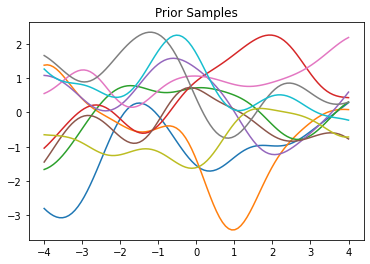

In [ ]:

# plot draws from gp priors
x, Y = sample_batch(10, 100, GP, -4, 4, x=1)
plt.plot(x, np.squeeze(Y))
plt.title("Prior Samples")

Text(0.5, 1.0, 'Prior Samples')

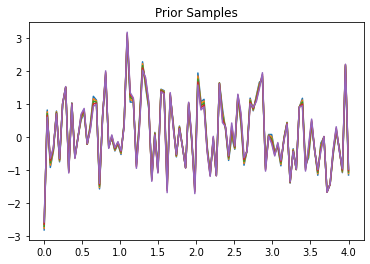

In [ ]:
import matplotlib.pyplot as plt

# plot draws from gp priors
for i in range(5):
    plt.plot(X, Y[i, :, 0])
plt.title("Prior Samples")

In [ ]:
linear_basis.shape

TensorShape([100, 102, 1])

In [ ]:
pivae = piVAE(config=config)

linear_basis = pivae.__solve__(X, Y)
Y_ = pivae.__eval__(c=X[0:1,:,:], linear_basis=linear_basis[0:1,:,:], q=X_, training=False)

Text(0.5, 1.0, 'Direct Interpolation')

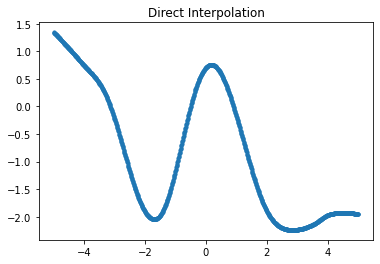

In [ ]:
for i in range(1):
    plt.scatter(X_[0, :, 0], Y_[i, :, 0], s=10)
plt.title("Direct Interpolation")

In [ ]:
model = pivae
loss = pivae_loss
grad = pivae_grad

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False, decay=0.01, name='Adam'
)

In [ ]:
import os
import datetime

# Keep results for plotting
train_loss_results = []

num_epochs = 200

#log_dir = os.path.join(os.path.join(os.getcwd(), "logs"), datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#summary_writer = tf.summary.create_file_writer(logdir=log_dir)

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
  # Training loop - using batches of 32

  for X,Y in gp_dataset: #gp_dataset
    x_train, y_train = X,Y
    # Optimize the model
    loss_value, grads = grad(model, x_train, y_train, pivae.trainable_variables)
    optimizer.apply_gradients(zip(grads, pivae.trainable_variables))
    epoch_loss_avg(loss_value)  # Add current batch loss

  # End epoch
  train_loss_results.append(epoch_loss_avg.result().numpy())

  if epoch % 10 == 0:
    print("Epoch {:03d}: Loss: {:.3f}".format(epoch, epoch_loss_avg.result()))

  #with summary_writer.as_default():
  #  tf.summary.scalar('epoch_loss_avg', epoch_loss_avg.result(), step=epoch)

Epoch 000: Loss: 246689.844
Epoch 010: Loss: 328.981
Epoch 020: Loss: 213.176
Epoch 030: Loss: 196.526
Epoch 040: Loss: 191.091
Epoch 050: Loss: 188.834
Epoch 060: Loss: 186.868
Epoch 070: Loss: 185.378
Epoch 080: Loss: 184.207
Epoch 090: Loss: 183.115
Epoch 100: Loss: 182.201
Epoch 110: Loss: 181.115
Epoch 120: Loss: 180.242
Epoch 130: Loss: 179.861
Epoch 140: Loss: 178.954
Epoch 150: Loss: 178.036
Epoch 160: Loss: 177.181
Epoch 170: Loss: 176.357
Epoch 180: Loss: 175.929
Epoch 190: Loss: 174.997


ValueError: ignored

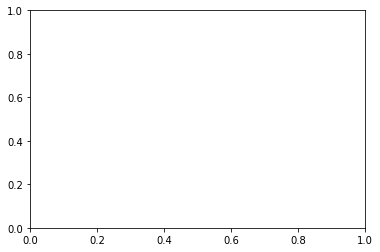

In [ ]:
# check posterior mean and variance have converged
for i in range(config['latent_dim']):
  plt.scatter(range(num_epochs),[x[i] for x in pivae.z_mean_list])

In [ ]:
pivae.z_mean_list[999]

<tf.Tensor: shape=(100, 5), dtype=float32, numpy=
array([[ 0.3019439 , -0.7670572 , -1.0584724 , -3.221465  , -1.4087156 ],
       [-0.84467417, -0.2733736 , -1.2150083 , -5.0306263 , -0.42833048],
       [ 0.20982829, -0.73087966, -1.0134652 , -3.0176404 , -1.2952919 ],
       [-1.4036156 , -0.47014207, -2.1928074 , -8.480926  , -0.7372602 ],
       [-0.31534535, -0.10055569, -0.62345886, -2.361866  , -0.34917685],
       [ 0.4763705 , -1.3001119 , -1.605381  , -4.925935  , -2.1816537 ],
       [ 0.05876694, -0.2812544 , -0.6280014 , -2.0083187 , -0.7569237 ],
       [-0.9108807 , -0.28460944, -1.3338008 , -5.3129516 , -0.4574037 ],
       [ 0.4328358 , -1.3256307 , -1.6416028 , -4.994152  , -2.1914256 ],
       [-0.63571554, -0.2421843 , -0.9974469 , -3.563261  , -0.4085156 ],
       [-0.5721279 , -0.17036544, -0.8597862 , -3.2773957 , -0.3168247 ],
       [-0.8217918 , -0.27057314, -1.194221  , -4.5495844 , -0.40022162],
       [ 0.15971367, -0.5744119 , -0.81127137, -2.4086297 , -1

## generating samples

In [ ]:
np.random.normal(loc=pivae.z_mean[0,:], scale=np.exp(pivae.z_log_var[0,:])**0.5, size=(config['latent_dim'],))

array([ 0.41216378, -0.66604002, -1.97818684, -3.93775975, -1.81979046])

In [ ]:
# sampling one basis vector and transforming with decoder and phi to reconstructed mean
def pi_vae_sampler(x, n, j=2):

  Z = np.random.normal(loc=pivae.z_mean[j,:], scale=np.exp(pivae.z_log_var[j,:])**0.5, size=(config['latent_dim'],)) # z_mu, z_sd
  reconstructed_mapping = tf.cast(tf.expand_dims(pivae.decoder(np.expand_dims(Z, 0)), -1), tf.float64)
  mean_reconstructed = pivae.__eval__(c=x, linear_basis=reconstructed_mapping, q=x, training=False)
  return np.squeeze(mean_reconstructed)

def pi_vae_sampler_X(x):
  Z = np.random.normal(loc=pivae.z_mean, scale=np.exp(pivae.z_log_var)**0.5, size=(100,config['latent_dim']))
  reconstructed_mapping = tf.cast(tf.expand_dims(pivae.decoder(Z), -1), tf.float64)
  mean_reconstructed = pivae.__eval__(c=x, linear_basis=reconstructed_mapping, q=x, training=False)
  return np.squeeze(mean_reconstructed)

In [ ]:
# generate n draws evaluated at points x
n = 10
x = np.expand_dims(np.expand_dims(np.linspace(-5,5,100), 0), -1)
sampled_mean = np.zeros((n, x.shape[1]))
for i in range(n):
  sampled_mean[i,:] = pi_vae_sampler(x,n, 10)
  #sampled_mean = pi_vae_sampler_X(x)

In [ ]:
sampled_mean.shape

(100, 100)

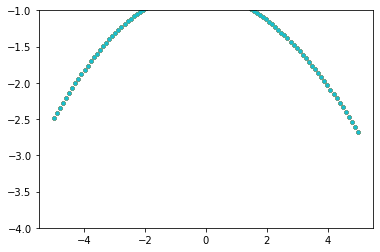

In [ ]:
# plot generated draws
for i in range(n):
  plt.scatter(np.squeeze(x), sampled_mean[i,:], s=10)
  plt.ylim(-4,-1)



## Inference with MH Sampler

In [ ]:
import math as m

In [ ]:
def mh_sampler(sample_size, x, y, sigma_prop, target=target):
  pi = tf.constant(m.pi)
  sample = np.zeros((sample_size+1,config['latent_dim']))
  Z_init = np.random.normal((config['latent_dim'],))
  sample[0,:] = Z_init
  accepted = 0
  def proposal(x, mean, std=sigma_prop):
    n = len(x)
    return tf.cast((2*pi)**(-n/2)* (tf.reduce_prod(sigma_prop**2))**(-0.5) * 
                   tf.math.exp( -1/2 * tf.linalg.matmul((x-mean), tf.linalg.matmul(tf.linalg.diag(sigma_prop**2), tf.transpose(x-mean)))), dtype= tf.float64) # np.exp( -1/2 * std**(-2) * np.sum((x-mean)**2))
  for i in range(sample_size):
    Z_prop = sample[i,:] + np.random.normal(scale=sigma_prop, size= config['latent_dim'])
    U = np.random.uniform()
  
    top_log_lik, top_prior = target(x, y, Z_prop)#*proposal(Z_prop, sample[i,:])
    bottom_log_lik, bottom_prior = target(x, y, sample[i,:])#*proposal(sample[i,:], Z_prop)
    lik_ratio = tf.math.exp(top_log_lik-bottom_log_lik) # using log-exp trick
    prior_ratio = top_prior/bottom_prior
    alpha = lik_ratio * prior_ratio
    #print(alpha)
    if U <= alpha:
      sample[i+1,:] = Z_prop
      accepted += 1
    else:
      sample[i+1,:] = sample[i,:]
  print(accepted)
  return sample

In [ ]:
def target(y, x, Z, sigma_noise=3): # need Z to be tf.float64
  # noise parameter sigma_noise inferred as well?
  # return log likelihood to use exp log trick
  pi = tf.constant(m.pi)
  reconstructed_mapping = tf.cast(tf.expand_dims(pivae.decoder(np.expand_dims(Z, 0)), -1), tf.float64)
  mean_reconstructed = pivae.__eval__(c=x, linear_basis=reconstructed_mapping, q=x, training=False)
  log_lik_eval = -1/2 * sigma_noise**(-2) * tf.math.reduce_sum((y - mean_reconstructed)**2)

  prior_eval = tf.cast((2*pi)**(-config['latent_dim']/2), tf.float64) * tf.math.exp(-1/2 * tf.math.reduce_sum(Z**2))
  return log_lik_eval, prior_eval

In [ ]:
## sample test data
x_te = np.random.uniform(-4,4, 100)
y_te = np.random.normal(x_te**2, scale=3)
x_te = np.expand_dims(np.expand_dims(x_te, -1), 0)
y_te = np.expand_dims(np.expand_dims(y_te, -1), 0)

In [ ]:
posterior_sample = mh_sampler(10**5, x_te, y_te, sigma_prop=posterior_sd)

96947


Mcmc does not converge properly...

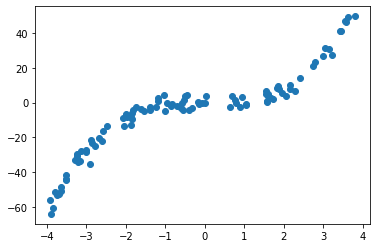

In [ ]:

plt.scatter(x_te,y_te)

In [ ]:
posterior_mean = tf.reduce_mean(posterior_sample[40000:,:], 0)

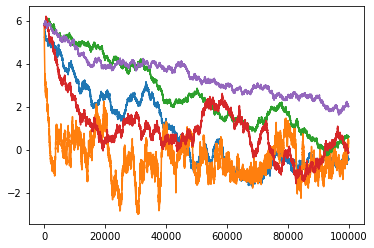

In [ ]:
# trace plot
for i in range(5):
  plt.plot(posterior_sample[:,i])

In [ ]:
posterior_sd = tf.reduce_mean((posterior_sample-posterior_mean)**2, 0)

In [ ]:
print(posterior_mean)
posterior_sd

tf.Tensor([4.55889276 3.97514671 5.36448849 5.04697504 5.50928303], shape=(5,), dtype=float64)


<tf.Tensor: shape=(5,), dtype=float64, numpy=array([0.0089867 , 0.03226995, 0.00643553, 0.01222307, 0.00558466])>

In [ ]:
final_Z = posterior_mean #+ np.random.normal(scale=(posterior_sd)**0.5)

In [ ]:
reconstructed_mapping = tf.cast(tf.expand_dims(pivae.decoder(np.expand_dims(final_Z, 0)), -1), tf.float64)
mean_recovered = pivae.__eval__(c=x_te, linear_basis=reconstructed_mapping, q=X_, training=False)

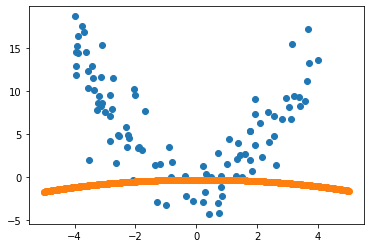

In [ ]:
plt.scatter(x_te,y_te)
plt.scatter(X_, mean_recovered)

# Deep O Net

### Own Implementation

#### using classes
Not tested yet

In [ ]:
# Build the piVAE Model object
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
import tensorflow as tf

In [ ]:

class branch_net(tf.keras.layers.Layer):
    """Maps inputs u(x_1),...u(x_n) to b_1,...,b_p
        Has argument branch_dims: list of 2 integers indicating layer width,
                     output_dim: dimension of the output before dot product, p """

    def __init__(self, branch_dims, output_dim = 32, name="branch_net", **kwargs):
        super(branch_net, self).__init__(name=name, **kwargs)
        self.dense_1 = Dense(branch_dims[0], activation="relu")
        self.dense_2 = Dense(branch_dims[0], activation="relu")
        self.dense_3 = Dense(output_dim)
        self.bn_1 = BatchNormalization()
        self.bn_2 = BatchNormalization()

    def call(self, inputs):
        x = self.dense_1(inputs)
        x = self.bn_1(x)
        x = self.dense_2(x)
        x = self.bn_2(x)
        x = self.dense_3(x)
        return x

class trunk_net(tf.keras.layers.Layer):
    """Maps inputs y to t_1,...,t_p
      Has argument branch_dims: list of 2 integers indicating layer width,
                  output_dim: dimension of the output before dot product, p"""

    def __init__(self, trunk_dims, output_dim = 32 , name="trunk_net", **kwargs):
        super(trunk_net, self).__init__(name=name, **kwargs)
        self.trunk_dims = trunk_dims
        self.dense_1 = Dense(trunk_dims[0], activation="relu")
        self.dense_2 = Dense(trunk_dims[1], activation="relu")
        self.dense_3 = Dense(output_dim)

    def call(self, inputs):
        x = self.dense_1(inputs)
        #x = self.bn_1(x)
        x = self.dense_2(x)
        #x = self.bn_2(x)
        x = self.dense_3(x)
        return x


# not used yet, functional API instead
class DeepONet(tf.keras.Model):
    """Combines branch net and trunk net into an end-to-end model for training."""
    # currently 1-D y values, need additional input for higher dimensions
    def __init__(
        self,
        branch_dims,
        trunk_dims,
        output_dim,
        name="deeponet",
        **kwargs):
      
        super(DeepONet, self).__init__(name=name, **kwargs)
        self.branch_dims = branch_dims
        self.output_dim = output_dim
        self.trunk_dims = trunk_dims
        self.trunk = trunk_net(trunk_dims=trunk_dims, output_dim=output_dim)
        self.branch = branch_net(branch_dims=branch_dims, output_dim=output_dim)
        self.bias = tf.Variable(initial_value=0, trainable=True, name='bias')

    def call(self, inputs): # inputs is list of tensors or numpy arrays of the form [u(x), y]
        u_x, y = inputs
        b =  self.branch(u_x)
        t = self.trunk(y)
        G_y = tf.linalg.matmul(b, t, transpose_b=True) + self.bias 
        return G_y

In [ ]:
## generate some dummy inputs for the DeepONet
import numpy as np
x = np.linspace(0,1,20)
data = np.zeros((100*100, 21))
target = np.zeros((10**4,))
for i in range(100):
  a = np.random.normal(0, 9)
  y = np.random.uniform(0,1, size=(100,))
  u = np.cos(a*x)
  G_y = 1/a * np.sin(y)
  target[i*100: (i+1)*100] = G_y
  for j in range(100):
    data[j,:-1] = u
    data[j, 20] = y[j]

In [ ]:
# initialize model and compile
deeponet = DeepONet(branch_dims=[40,30], trunk_dims=[5,10], output_dim=20)
deeponet.compile(
    optimizer='adam', loss='rmse')

In [ ]:

u_x = np.expand_dims(data[1,:-1],0)
y = np.expand_dims(np.expand_dims(data[1,-1], 0),-1)
branch =  branch_net([40,40])
trunk = trunk_net([40,40])
b = branch(u_x)
t = trunk(y)
G_y = tf.linalg.matmul(b, t, transpose_b=True)

print(G_y)

tf.Tensor([[-0.01118785]], shape=(1, 1), dtype=float32)


In [ ]:
deeponet.summary()

Model: "deeponet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
trunk_net (trunk_net)        multiple                  0         
_________________________________________________________________
branch_net (branch_net)      multiple                  3340      
Total params: 3,341
Trainable params: 3,341
Non-trainable params: 0
_________________________________________________________________


#### Using functional API

In [ ]:
import numpy as np

num_sensors=40
y_dim=1

def gen_cos_integral(num_u=10**4, y_per_u=1, num_sensors=40, y_lower=0, y_upper=1, a_lower=-5, a_upper=5, y_dim=1):
  # generate data
  x = np.linspace(0,1,num_sensors)
  data = np.zeros((num_u*y_per_u, num_sensors+1))
  target = np.zeros((num_u*y_per_u,))
  for i in range(num_u):
    a = np.random.uniform(a_lower,a_upper)
    y = np.random.uniform(y_lower, y_upper, size=(y_per_u,))
    u = np.cos(x*(2*np.pi)*a)
    G_y = 1/(2*np.pi) / a * np.sin(y)

    target[i*y_per_u: (i+1)*y_per_u] = G_y
    data[i*y_per_u: (i+1)*y_per_u, -1] = y

    for j in range(i*y_per_u, (i+1)*y_per_u):
      data[j,:-1] = u
  return data[:, :-1], data[:, -1], target # u, y, G(u)(y)

In [ ]:

def get_deepOnet(num_sensors=100, branch_dims=[40,40], trunk_dims=[10,20], output_dim = 32, y_dim=1):
  u_input = tf.keras.Input(
      shape=(num_sensors,), name="u")
  y_input = tf.keras.Input(shape=(y_dim,), name="y")  

  branch =  branch_net(branch_dims, output_dim=output_dim) # output_dim=32 by default
  trunk = trunk_net(trunk_dims, output_dim=output_dim)

  b = branch(u_input)
  t = trunk(y_input)

  x = tf.keras.layers.Multiply()([b,t])
  pred = tf.reduce_sum(x)
  #pred = tf.linalg.matmul(b, t, transpose_b=True)

  # Instantiate an end-to-end model
  model = Model(
      inputs=[u_input, y_input],
      outputs=[pred],
  )
  return model


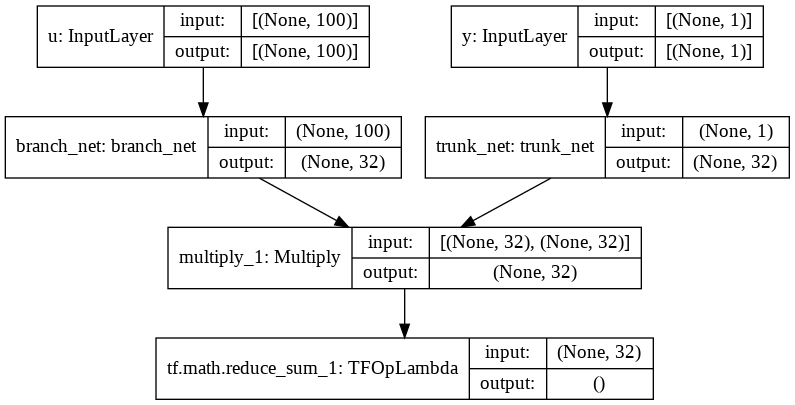

In [ ]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [ ]:
model=get_deepOnet(num_sensors=40)
optimizer = tf.keras.optimizers.Adam(0.001) # lr as in paper for antiderivative
model.compile(
    optimizer=optimizer, loss='mse')

In [ ]:
u_data, y_data, target = gen_cos_integral(num_sensors=40, y_upper=1, y_per_u=100, num_u=100)

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=10)

history= model.fit({"u": u_data, "y": y_data}, target, validation_split=0.2, batch_size=89, epochs=200, shuffle=True, callbacks=[early_stopping])

Epoch 1/200
90/90 [==============================] - 1s 4ms/step - loss: 1.2444 - val_loss: 1.3511
Epoch 2/200
90/90 [==============================] - 0s 3ms/step - loss: 0.1113 - val_loss: 0.7102
Epoch 3/200
90/90 [==============================] - 0s 3ms/step - loss: 0.0833 - val_loss: 0.5303
Epoch 4/200
90/90 [==============================] - 0s 2ms/step - loss: 0.0785 - val_loss: 0.2485
Epoch 5/200
90/90 [==============================] - 0s 3ms/step - loss: 0.0572 - val_loss: 0.3064
Epoch 6/200
90/90 [==============================] - 0s 3ms/step - loss: 0.0540 - val_loss: 0.2993
Epoch 7/200
90/90 [==============================] - 0s 3ms/step - loss: 0.0557 - val_loss: 0.2535
Epoch 8/200
90/90 [==============================] - 0s 3ms/step - loss: 0.0513 - val_loss: 0.3090
Epoch 9/200
90/90 [==============================] - 0s 3ms/step - loss: 0.0641 - val_loss: 0.3659
Epoch 10/200
90/90 [==============================] - 0s 3ms/step - loss: 0.0768 - val_loss: 0.1769
Epoch 11/

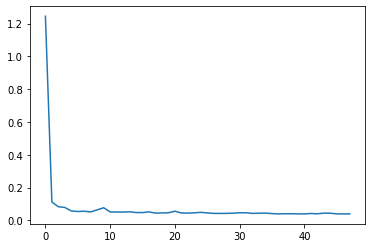

In [ ]:
plt.plot(history.history['loss'])

In [ ]:
# generate test data and evaluate model on it
u_test, y_test, target_test = gen_cos_integral(num_sensors=40, y_upper=1, y_per_u=100, num_u=100)
model.evaluate({"u": u_test, "y": y_test}, target_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.0479


0.047920212149620056

#### Try Deep-O-Net on Gaussian Process sample with numerical integration

In [ ]:
from sklearn.gaussian_process.kernels import RBF
import scipy.integrate as integrate
kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-1, 10.0))
GP = gaussian_process.GaussianProcessRegressor(kernel=kernel, optimizer='fmin_l_bfgs_b', 
                              n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, random_state=None)

In [ ]:
def get_data(num_functions=10**4, num_sensors=100, GP=GP, x_lower=0, y_lower=4):
  x, gp_sample = sample_batch(num_functions, num_sensors, GP, 0, 4, x=1)
  gp_sample = np.squeeze(gp_sample)
  gp_sample = np.transpose(gp_sample)

  ys = np.random.uniform(0,4,num_functions)
  targets = np.zeros(num_functions)
  for i in range(num_functions):
    x_ = x[x<=ys[i]]
    targets[i] = integrate.simps(gp_sample[i,:len(x_)], x_)
  return gp_sample, ys, targets

In [ ]:
gp_train, y_train, target_train = get_data(num_functions=2*10**4)


In [ ]:
gp_model=get_deepOnet(num_sensors=100, trunk_dims=[40,40], branch_dims=[500,500], output_dim=40)
optimizer = tf.keras.optimizers.Adam(0.001) # lr as in paper for antiderivative
gp_model.compile(
    optimizer=optimizer, loss='mse')

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience=20)

history= gp_model.fit({"u": gp_train, "y": y_train}, target_train, validation_split=0.5, batch_size=100, epochs=400, shuffle=True, callbacks=[early_stopping])

Epoch 1/400
100/100 [==============================] - 2s 15ms/step - loss: 207.4455 - val_loss: 12.9770
Epoch 2/400
100/100 [==============================] - 1s 14ms/step - loss: 5.1757 - val_loss: 12.3849
Epoch 3/400
100/100 [==============================] - 1s 14ms/step - loss: 2.6913 - val_loss: 5.9118
Epoch 4/400
100/100 [==============================] - 1s 14ms/step - loss: 1.7905 - val_loss: 5.9835
Epoch 5/400
100/100 [==============================] - 1s 13ms/step - loss: 1.8003 - val_loss: 4.3592
Epoch 6/400
100/100 [==============================] - 1s 13ms/step - loss: 1.5671 - val_loss: 4.6606
Epoch 7/400
100/100 [==============================] - 1s 14ms/step - loss: 1.4559 - val_loss: 4.4109
Epoch 8/400
100/100 [==============================] - 1s 14ms/step - loss: 1.4111 - val_loss: 5.3875
Epoch 9/400
100/100 [==============================] - 1s 14ms/step - loss: 1.2833 - val_loss: 4.1268
Epoch 10/400
100/100 [==============================] - 1s 14ms/step - loss: 1

In [ ]:
# test against fully connected network

fnn = Sequential([
                  Dense(1000, input_shape=(101,), activation='relu'),
                  BatchNormalization(),
                  Dense(1000, activation='relu'),
                  BatchNormalization(),
                  Dense(1000, activation='relu'),
                  BatchNormalization(),
                  Dense(500, activation='relu'),
                  Dense(1)
              ])

fnn_model = Model(fnn.inputs, fnn.outputs)


In [ ]:
optimizer = tf.keras.optimizers.Adam(0.001) # lr as in paper for antiderivative
fnn_model.compile(
    optimizer=optimizer, loss='mse')

early_stopping = EarlyStopping(patience=10)

fnn_train_inputs = np.concatenate([gp_train, np.expand_dims(y_train, axis=-1)], axis=1)

history= fnn_model.fit(fnn_train_inputs, target_train, validation_split=0.5, batch_size=100, epochs=200, shuffle=True, callbacks=[early_stopping])

Epoch 1/200
100/100 [==============================] - 8s 69ms/step - loss: 1.1413 - val_loss: 0.3362
Epoch 2/200
100/100 [==============================] - 7s 68ms/step - loss: 0.3286 - val_loss: 0.2397
Epoch 3/200
100/100 [==============================] - 7s 69ms/step - loss: 0.1854 - val_loss: 0.1966
Epoch 4/200
100/100 [==============================] - 7s 68ms/step - loss: 0.1881 - val_loss: 0.1663
Epoch 5/200
100/100 [==============================] - 7s 68ms/step - loss: 0.1513 - val_loss: 0.1468
Epoch 6/200
100/100 [==============================] - 7s 68ms/step - loss: 0.1169 - val_loss: 0.1158
Epoch 7/200
100/100 [==============================] - 7s 68ms/step - loss: 0.0817 - val_loss: 0.1074
Epoch 8/200
100/100 [==============================] - 7s 68ms/step - loss: 0.0711 - val_loss: 0.0839
Epoch 9/200
100/100 [==============================] - 7s 68ms/step - loss: 0.0727 - val_loss: 0.1001
Epoch 10/200
100/100 [==============================] - 7s 68ms/step - loss: 0.065

This is not good!They achieve orders of magnitudes smaller error in the paper...


# Rough Paths signature

In [ ]:
!pip install iisignature
import numpy as np
import iisignature

## Trying out Signatory package

In [ ]:
!pip install signatory==1.2.4.1.7.1 --no-cache-dir --force-reinstall
import signatory
import torch
batch , stream , channels , depth = 1, 10, 2, 4

ERROR: Could not find a version that satisfies the requirement signatory==1.2.5 (from versions: 0.1.0, 0.1.1, 0.1.2, 0.2.0, 1.0.0, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.1.4.1.2.0, 1.1.4.1.3.0, 1.1.5.1.2.0, 1.1.5.1.3.0, 1.1.6.1.2.0, 1.1.6.1.3.0, 1.1.6.1.3.1, 1.2.0.1.2.0, 1.2.0.1.3.0, 1.2.0.1.3.1, 1.2.0.1.4.0, 1.2.1.1.2.0, 1.2.1.1.3.0, 1.2.1.1.3.1, 1.2.1.1.4.0, 1.2.1.1.5.0, 1.2.2.1.2.0, 1.2.2.1.3.0, 1.2.2.1.3.1, 1.2.2.1.4.0, 1.2.2.1.5.0, 1.2.2.1.5.1, 1.2.3.1.2.0, 1.2.3.1.3.0, 1.2.3.1.3.1, 1.2.3.1.4.0, 1.2.3.1.5.0, 1.2.3.1.5.1, 1.2.3.1.6.0, 1.2.4.1.6.0, 1.2.4.1.7.0, 1.2.4.1.7.1)
ERROR: No matching distribution found for signatory==1.2.5


In [ ]:
!python --version

Python 3.7.10


In [ ]:

!pip install torch==1.7.1 torchvision==0.8.2 torchaudio==0.7.2

ERROR: Could not find a version that satisfies the requirement signatory==1.2.5.1.7.1 (from versions: 0.1.0, 0.1.1, 0.1.2, 0.2.0, 1.0.0, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.1.4.1.2.0, 1.1.4.1.3.0, 1.1.5.1.2.0, 1.1.5.1.3.0, 1.1.6.1.2.0, 1.1.6.1.3.0, 1.1.6.1.3.1, 1.2.0.1.2.0, 1.2.0.1.3.0, 1.2.0.1.3.1, 1.2.0.1.4.0, 1.2.1.1.2.0, 1.2.1.1.3.0, 1.2.1.1.3.1, 1.2.1.1.4.0, 1.2.1.1.5.0, 1.2.2.1.2.0, 1.2.2.1.3.0, 1.2.2.1.3.1, 1.2.2.1.4.0, 1.2.2.1.5.0, 1.2.2.1.5.1, 1.2.3.1.2.0, 1.2.3.1.3.0, 1.2.3.1.3.1, 1.2.3.1.4.0, 1.2.3.1.5.0, 1.2.3.1.5.1, 1.2.3.1.6.0, 1.2.4.1.6.0, 1.2.4.1.7.0, 1.2.4.1.7.1)
ERROR: No matching distribution found for signatory==1.2.5.1.7.1
     |████████████████████████████████| 776.8MB 22kB/s 
     |████████████████████████████████| 12.8MB 254kB/s 
     |████████████████████████████████| 7.6MB 5.4MB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu10

In [ ]:
print(torch.__version__)
print(signatory.__version__)

1.7.1
1.2.4


In [ ]:
 path = torch.rand ( batch , stream , channels , requires_grad=True)
 signature = signatory.signature(path, depth)

signature

tensor([[ 0.6078, -0.6983,  0.1847, -0.0505, -0.3739,  0.2438,  0.0374, -0.0410,
          0.0514, -0.0642, -0.1393,  0.1637,  0.0487, -0.0567,  0.0057, -0.0075,
         -0.0024,  0.0092,  0.0180, -0.0172, -0.0403,  0.0308, -0.0342,  0.0274,
          0.0620, -0.0476,  0.0040, -0.0096, -0.0081,  0.0099]],
       grad_fn=<_SignatureFunctionBackward>)

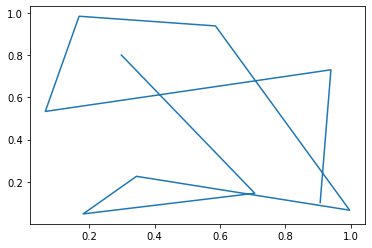

In [ ]:
import matplotlib.pyplot as plt

plt.plot(path.detach().numpy()[0,:,0], path.detach().numpy()[0,:,1])

In [ ]:
reconstructed_path = signatory.invert_signature(signature, depth=4, channels=2, initial_position=path[0,0,:])

AttributeError: ignored

## Sugar Spectra Regression with Signatures

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.models import Sequential, Model
import glob
import pandas as pd
import numpy as np

In [ ]:

file_dir='./drive/My Drive/ThesisData/Sugar_csv'
file_names = glob.glob('{}/wave*'.format(file_dir))

def get_sugar_data(file_names=file_names):
  data = map(pd.read_csv, file_names)
  data = [d.values for d in data]
  return np.stack(data, axis=2)

def get_signatures(data, level=3):
  # data in dimensions b x n x p (batch size, measured points, measurement dimensions)
  return iisignature.sig(data, level)

In [ ]:
# load covariates and compute signature
data = get_sugar_data()
data = get_signatures(data)
X = data

In [ ]:
# load response
response = pd.read_csv('./drive/My Drive/ThesisData/Sugar_csv/response')
response = response['x']
#response = tf.cast(response, tf.float64)
y = response

In [ ]:
# cv
# X and y numpy arrays as loaded from drive
from sklearn.model_selection import KFold


def sig_net_cv(n_splits, layer_widths):

  kf = KFold(n_splits=n_splits, random_state=0, shuffle=True)

  test_error = np.zeros(n_splits)
  train_error = np.zeros(n_splits)

  i = 0

  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # prepare dataset
    train_dataset = prep(X_train, y_train)
    test_dataset = prep(X_test, y_test, batch_size = y_test.shape[0] , train=False)

    # get model and train
    model = get_signet(layer_widths)
    history = model.fit(train_dataset, validation_data=test_dataset, epochs = 30, verbose=0)

    train_error[i] = history.history['loss'][-1]
    test_error[i] = model.evaluate(test_dataset, verbose=0)[0]
    i += 1
  return tf.reduce_mean(train_error), tf.reduce_mean(test_error)

In [ ]:
def get_signet(layer_width, input_shape=(399,)):
  # function returns model with specified input shape and dense layers with layer widths given in array layer_width
  # Between each Dense Layer we have a BatchNormalization layer
  # Final Layer is a Dense Layer with one neuron for regression 1d output.
  # returns compiled model
  inputs = tf.keras.Input(shape=input_shape)   
  x = Dense(layer_width[0], activation='relu')(inputs)
  x = BatchNormalization()(x)
  for i in layer_width[1:]:
    x = Dense(i, activation='relu')(x)
    x = BatchNormalization()(x)

  outputs = Dense(1)(x)
  model = Model(inputs, outputs)

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
  loss = tf.keras.losses.MeanSquaredError()
  
  model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])

  return model

In [ ]:
def prep(data, y, shuffle_buffer= 200, batch_size= 30, train=True):
  dataset = tf.data.Dataset.from_tensor_slices((data, y))
  if train:
    dataset = dataset.shuffle(shuffle_buffer)
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
mean_train_err, mean_test_err = sig_net_cv(5, [200,100,50,20])

In [ ]:
print(mean_train_err)
print(mean_test_err)

tf.Tensor(11.181789970397949, shape=(), dtype=float64)
tf.Tensor(19.00386600494385, shape=(), dtype=float64)


## Signature VAE

In [ ]:
# Build the encoder with KLAddLossLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers




#from tensorflow.keras.layers.experimental import RandomFourierFeatures
# assuming beta_i has 1x20 dims
latent_size=10
input_shape=(41,)

# Define the prior
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)

encoder = Sequential([
    Dense(300, activation='relu', input_shape=input_shape), # adjust shape
    Dense(200, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(60, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(tfpl.IndependentNormal.params_size(latent_size)),
    tfpl.IndependentNormal(latent_size),
    tfpl.KLDivergenceAddLoss(prior, use_exact_kl=False, weight=1, test_points_fn= lambda q: q.sample(10), 
                             test_points_reduce_axis=None) # could possibly use exact KL divergence since Normal
          ])

decoder = Sequential([
    Dense(60, activation='relu', input_shape=(latent_size,)),
    Dense(200, activation='relu'),
    Dense(300, activation='relu'),
    Dense(tfpl.IndependentNormal.params_size(input_shape)),
    tfpl.IndependentNormal(input_shape)
          ])
    

In [ ]:
# combine encoder and decoder in model
from tensorflow.keras.models import Model
SigVAE = Model(encoder.inputs, decoder(encoder.outputs))




In [ ]:
x,Y = sample_batch(10**4, 100, GP, 0, 4, x=1)
Y = np.transpose(np.squeeze(Y))
Y = np.expand_dims(Y, axis=-1)

In [ ]:
X = np.zeros((10**4,100))
for i in range(10**4):
  X[i,:] = x
X = np.expand_dims(X,axis=-1)

In [ ]:
np.stack([X[0,:,0], Y[0,:,0]], axis=1).shape

(100, 2)

In [ ]:
s = iisignature.prepare(2, 7)
log_sigs = np.zeros((X.shape[0],41))
for i in range(X[0].shape[0]):
  log_sigs[i,:] = iisignature.logsig(np.stack([X[i,:,0], Y[i,:,0]], axis=1),s)

In [ ]:
# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

SigVAE.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
history = SigVAE.fit(log_sigs, log_sigs, epochs=30, batch_size=100)

Epoch 1/30
100/100 [==============================] - 3s 10ms/step - loss: 1.3611
Epoch 2/30
100/100 [==============================] - 1s 10ms/step - loss: 0.4931
Epoch 3/30
100/100 [==============================] - 1s 10ms/step - loss: 0.0816
Epoch 4/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0505
Epoch 5/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0460
Epoch 6/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0443
Epoch 7/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0426
Epoch 8/30
100/100 [==============================] - 1s 12ms/step - loss: 0.0418
Epoch 9/30
100/100 [==============================] - 1s 14ms/step - loss: 0.0407
Epoch 10/30
100/100 [==============================] - 1s 13ms/step - loss: 0.0400
Epoch 11/30
100/100 [==============================] - 1s 11ms/step - loss: 0.0392
Epoch 12/30
100/100 [==============================] - 1s 12ms/step - loss: 0.0385
Epoch 13/30
1

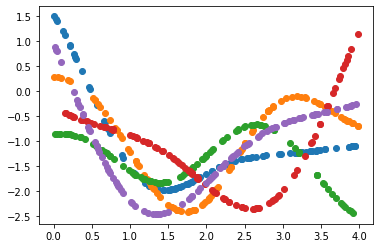

In [ ]:
# plot initial samples
import matplotlib.pyplot as plt
for i in range(5):
  plt.scatter(X[i,:,0], Y[i,:,0])

### Compute Gradients to retrieve path from signature

In [ ]:
def logsig_grads(path, pred_log_sig):
  '''Takes as input the path a numpy array of shape n x d, 
      and the target log signature we want the path to have.

      - Computes loss MSE(logsig(path),logsig_target)
      - Returns gradients dL/dpath'''


  gen_log_sig = iisignature.logsig(path,s) # requires numpy input
  gen_log_sig = tf.convert_to_tensor(gen_log_sig)
  with tf.GradientTape() as tape: # requires tensors
    tape.watch(gen_log_sig)
    loss = tf.reduce_mean((gen_log_sig-pred_log_sig)**2)
  derivs = tape.gradient(loss, gen_log_sig)
  grads = iisignature.logsigbackprop(derivs, path, s)
  grads = tf.convert_to_tensor(grads)
  return [grads, loss]


In [ ]:
# This initialisation of new path doesn't work
x_0 = X[0,:,0]+ 0.1
y_0 = np.random.normal(size=(100,))
path_init = np.stack([x_0, y_0], axis=1)
path = tf.Variable(
    initial_value= path_init, trainable=True
)
path = tf.cast(path, tf.float32)

In [ ]:
path = tf.Variable(
    initial_value= tf.random.normal(shape=(4,2), mean=[2,0]), trainable=True
)

InvalidArgumentError: ignored

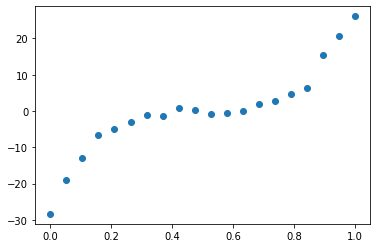

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(p[:,0], p[:,1])
plt.scatter(path[:,0], path[:,1])

### Example retrieving path from log-signature

Assuming the locations x known, we learn the y values of a path with the target log-signature by gradient descent. 

After gradient descent we still need to account for the reparametrisation invariance of the log-signature.

The first test case:
- x = -4,...4 in $R^n$, equally spaced points
- $y\sim \mathcal{N}(x^3, 1)$
So far the method works well for smaller n

In [ ]:
# generate target path
n = 10
x = np.linspace(0,1,n)
y = np.random.normal(loc=(6*(x-.5))**3, size=(n,))
y = y - np.mean(y)
p = np.stack([x,y], axis=1)

# compute log-signature up to level l
l = 12
s = iisignature.prepare(2, l)
log_sigs = iisignature.logsig(p, s)

In [ ]:
path = tf.Variable(initial_value= tf.random.normal(shape=(n,)), trainable=True)

In [ ]:

optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

n_epochs=5000
pred_log_sig = log_sigs

losses = np.zeros(n_epochs)

for i in range(n_epochs):
  # use original locations and just learn y values
  grads, loss = logsig_grads(np.stack([x,path.numpy()], axis=1), pred_log_sig) # compute loss and gradients
  grads_y = grads[:,1] # extract gradients for y
  optimizer.apply_gradients(zip([grads_y], [path])) # apply gradients
  losses[i] = loss # append loss

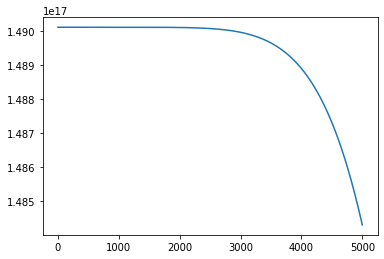

In [ ]:
plt.plot(losses)

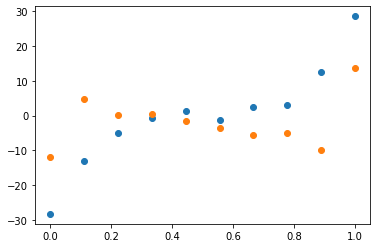

In [ ]:
# plot original data and infered path, both centered y.
plt.scatter(p[:,0], p[:,1])
plt.scatter(x, path)

In [ ]:
# Try retrieving it using signatory

# Fourier Transform

##Fourier Transform VAE

Should be better on smooth functions than signature
- problem with signature is inversion to retrieve path

### investigate symmetry in samples and reconstructions:

Decoder only produced real FT which then gives real even function after applying inverse fourier transform. Here we implement a potential fix by separating and concatenating real and even parts in the fourier transform, i.e. x +iy -> (x,y).

In [5]:
n_points = 100
x_upper = 4
X,Y_train = sample_batch(10**4, n_points, GP, 0, x_upper, x=1)
X,Y_val = sample_batch(10**3, n_points, GP, 0, x_upper, x=1)
# apply fourier transform to data
Y_train = np.transpose(np.squeeze(Y_train))
fourier_train = np.fft.fft(Y_train)

# apply fourier transform to data
Y_val = np.transpose(np.squeeze(Y_val))
fourier_val = np.fft.fft(Y_val)

In [6]:
# above changes to data
fourier_train = fourier_train[:,:(n_points//2)]
real_train = fourier_train.real
imag_train = fourier_train.imag

full_train = np.concatenate([real_train,imag_train], axis=1)

In [7]:
fourier_val = fourier_train[:,:(n_points//2)]
real_val = fourier_val.real
imag_val = fourier_val.imag

full_val = np.concatenate([real_val,imag_val], axis=1)

In [ ]:
full_train.shape

(10000, 800)

In [8]:
#from tensorflow.keras.layers.experimental import RandomFourierFeatures
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Model

tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

def get_VAE(input_shape, latent_size, prior, loss, optimizer, encoder_dims=[80,60,40], decoder_dims=[40,60,80]):
  encoder = Sequential([
      Dense(80, activation='relu', input_shape=input_shape), # adjust shape #
      Dense(60, activation='relu', kernel_regularizer=l2(1e-4)),
      Dense(40, activation='relu', kernel_regularizer=l2(1e-4)),
      Dense(tfpl.IndependentNormal.params_size(latent_size)),
      tfpl.IndependentNormal(latent_size),
      tfpl.KLDivergenceAddLoss(prior, use_exact_kl=False, weight=1, test_points_fn= lambda q: q.sample(10), 
                              test_points_reduce_axis=None) # could possibly use exact KL divergence since Normal
            ])

  decoder = Sequential([
      Dense(40, activation='relu', input_shape=(latent_size,)),
      Dense(60, activation='relu'),
      Dense(80, activation='relu'),
      Dense(tfpl.IndependentNormal.params_size(input_shape)),
      tfpl.IndependentNormal(input_shape)
            ])
      
  FVAE_concat = Model(encoder.inputs, decoder(encoder.outputs))
  FVAE_concat.compile(optimizer, loss=loss)
  # compile model
  return FVAE_concat, decoder, encoder
  
# get VAE
latent_size=10
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.MeanSquaredError()
input_shape=(100,)
FVAE_concat, decoder, encoder = get_VAE(input_shape, latent_size, prior=prior, loss=loss, optimizer=optimizer)

early_stopping = EarlyStopping(patience=10)

history = FVAE_concat.fit(full_train, full_train, validation_data=(full_val, full_val), epochs=400, batch_size=100, callbacks=[early_stopping])



Epoch 1/400
100/100 [==============================] - 2s 8ms/step - loss: 111.1562 - val_loss: 89.1196
Epoch 2/400
100/100 [==============================] - 0s 5ms/step - loss: 84.1871 - val_loss: 80.8852
Epoch 3/400
100/100 [==============================] - 0s 5ms/step - loss: 79.3412 - val_loss: 78.1198
Epoch 4/400
100/100 [==============================] - 1s 5ms/step - loss: 77.2701 - val_loss: 76.4760
Epoch 5/400
100/100 [==============================] - 1s 5ms/step - loss: 74.9966 - val_loss: 72.5148
Epoch 6/400
100/100 [==============================] - 1s 6ms/step - loss: 66.1452 - val_loss: 57.6616
Epoch 7/400
100/100 [==============================] - 1s 5ms/step - loss: 49.0046 - val_loss: 41.3638
Epoch 8/400
100/100 [==============================] - 0s 5ms/step - loss: 37.9074 - val_loss: 35.3476
Epoch 9/400
100/100 [==============================] - 1s 5ms/step - loss: 34.1871 - val_loss: 33.4056
Epoch 10/400
100/100 [==============================] - 1s 5ms/step - lo

### Plot FFT_VAE reconstructions

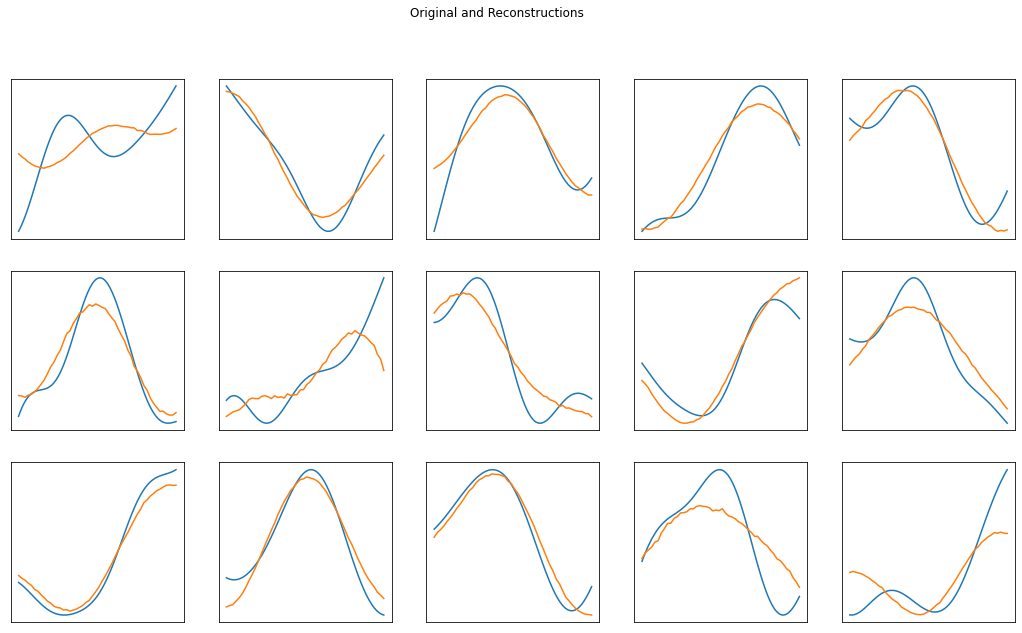

In [12]:
# sample test set
import matplotlib.pyplot as plt
X,Y_test = sample_batch(30, 100, GP, 0, 4, x=1)
Y_test = np.transpose(np.squeeze(Y_test))
Fourier_test = np.fft.fft(Y_test)
# above changes to data
Fourier_test = Fourier_test[:,:50]
real_test = Fourier_test.real
imag_test = Fourier_test.imag

full_test = np.concatenate([real_test,imag_test], axis=1)
out_test = FVAE_concat(full_test).mean()
out_ft = out_test[:,:50].numpy() + 1j * out_test[:,50:].numpy()

reconstructions = np.fft.ifft(out_ft)
# View the reconstructions and original

n_rows, n_cols = 3, 5
X_ = np.linspace(0,4, 50)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 10))
for i, ax in enumerate(fig.axes):
    ax.set_ylabel(str(i))
    ax.plot(X, Y_test[i,:]-np.mean(Y_test[i,:]), label='original')
    ax.plot(X_, reconstructions[i,:].real-np.mean(reconstructions[i,:].real), label='reconstructed')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.legend(loc='upper right')
fig.suptitle('Original and Reconstructions')
plt.show()

### Use FFT_VAE to sample

Text(0.5, 1.0, 'GP samples')

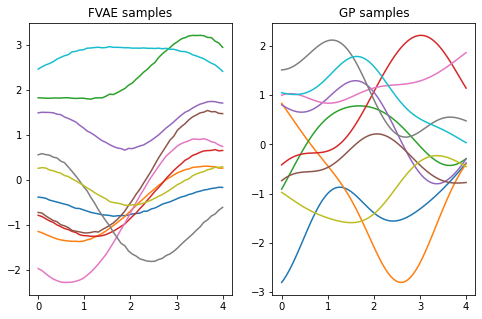

In [13]:
# sample and decode
n_samples = 20
samples= decoder(prior.sample(n_samples)).mean()

# inverse fourier transform
samples = np.fft.ifft(samples[:,:50].numpy() + 1j*samples[:,50:].numpy())

fig, axs = plt.subplots(1, 2, figsize=(8, 5))

for i in range(10):
  axs[0].plot(X_,samples[i,:].real)
  axs[1].plot(X, Y_test[i,:])
axs[0].set_title('FVAE samples')
axs[1].set_title('GP samples')

### Test marginals of samples against actual samples

In [15]:
X,Y_test = sample_batch(10**3, 50, GP, 0, 4, x=1)
Y_test = np.transpose(np.squeeze(Y_test))

n_samples = 10**3
samples= decoder(prior.sample(n_samples)).mean()

# inverse fourier transform
samples = np.fft.ifft(samples[:,:50].numpy() + 1j*samples[:,50:].numpy())

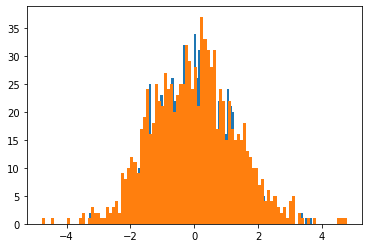

In [24]:
n = 49
_ = plt.hist(Y_test[:,n], bins=100)
_ = plt.hist(samples[:,n].real, bins=100)

### Try everything above but with a periodic kernel
Plotting the reconstructions clearly shows the periodicity constraint on the ability to reconstruct samples from the GP

#### Train

In [ ]:
from sklearn.gaussian_process.kernels import (RBF, Matern, RationalQuadratic,
                                              ExpSineSquared, DotProduct,
                                              ConstantKernel)


kernel = 1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0,
                                length_scale_bounds=(0.1, 10.0),
                                periodicity_bounds=(1.0, 10.0))

GP_exp_sine = gaussian_process.GaussianProcessRegressor(kernel = kernel, optimizer='fmin_l_bfgs_b', 
                              n_restarts_optimizer=0, normalize_y=False, copy_X_train=True, random_state=None)

# Build the encoder with KLAddLossLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers




#from tensorflow.keras.layers.experimental import RandomFourierFeatures
# assuming beta_i has 1x20 dims
latent_size=10
input_shape=(50,)

# Define the prior
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)

encoder = Sequential([
    Dense(50, activation='relu', input_shape=input_shape), # adjust shape
    Dense(50, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(40, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(tfpl.IndependentNormal.params_size(latent_size)),
    tfpl.IndependentNormal(latent_size),
    tfpl.KLDivergenceAddLoss(prior, use_exact_kl=False, weight=1, test_points_fn= lambda q: q.sample(10), 
                             test_points_reduce_axis=None) # could possibly use exact KL divergence since Normal
          ])

decoder = Sequential([
    Dense(40, activation='relu', input_shape=(latent_size,)),
    Dense(50, activation='relu'),
    Dense(50, activation='relu'),
    Dense(tfpl.IndependentNormal.params_size(input_shape)),
    tfpl.IndependentNormal(input_shape)
          ])

In [ ]:
# combine encoder and decoder in model
from tensorflow.keras.models import Model
FVAE_exp = Model(encoder.inputs, decoder(encoder.outputs))

#write loss function as reconstructions loss

X,Y_train = sample_batch(10**4, 100, GP_exp_sine, 0, 4, x=1)
X,Y_val = sample_batch(10**3, 100, GP_exp_sine, 0, 4, x=1)

# apply fourier transform to data
Y_train = np.transpose(np.squeeze(Y_train))
fourier_train = np.fft.fft(Y_train)[:,:50]

# apply fourier transform to data
Y_val = np.transpose(np.squeeze(Y_val))
fourier_val = np.fft.fft(Y_val)[:,:50]

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stopping = EarlyStopping(patience=10)

FVAE_exp.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
history_exp = FVAE_exp.fit(fourier_train, fourier_train, validation_data=(fourier_val, fourier_val), epochs=200, batch_size=100, callbacks=[early_stopping])



Epoch 1/200
100/100 [==============================] - 2s 6ms/step - loss: 233.3304 - val_loss: 174.9513
Epoch 2/200
100/100 [==============================] - 0s 4ms/step - loss: 152.6462 - val_loss: 140.6678
Epoch 3/200
100/100 [==============================] - 0s 4ms/step - loss: 134.4100 - val_loss: 130.5684
Epoch 4/200
100/100 [==============================] - 0s 4ms/step - loss: 127.2591 - val_loss: 124.5719
Epoch 5/200
100/100 [==============================] - 0s 3ms/step - loss: 119.0855 - val_loss: 111.3836
Epoch 6/200
100/100 [==============================] - 0s 4ms/step - loss: 99.1519 - val_loss: 83.2759
Epoch 7/200
100/100 [==============================] - 0s 4ms/step - loss: 68.6870 - val_loss: 56.3870
Epoch 8/200
100/100 [==============================] - 0s 3ms/step - loss: 50.2923 - val_loss: 46.5321
Epoch 9/200
100/100 [==============================] - 0s 4ms/step - loss: 43.6607 - val_loss: 42.3150
Epoch 10/200
100/100 [==============================] - 0s 3ms/

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


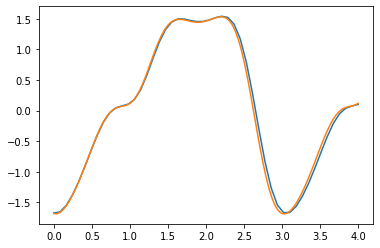

In [ ]:
y_rec = np.fft.ifft(fourier_val[1,:])
y_rec = y_rec - np.mean(y_rec)
plt.plot(np.linspace(0,4,50),y_rec)
plt.plot(X, Y_val[1,:]-np.mean(Y_val[1,:]))

#### plot reconstructions

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/

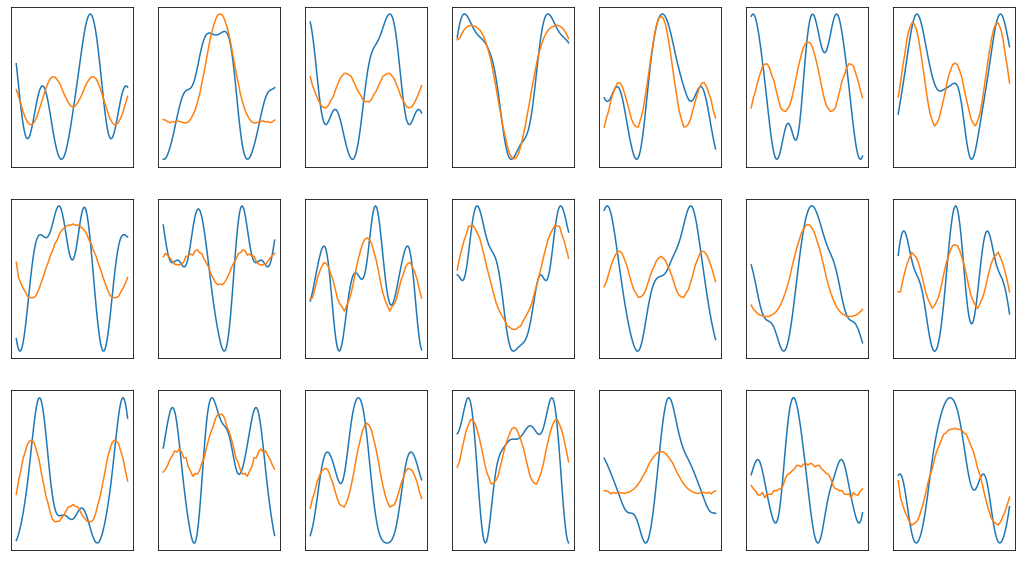

In [ ]:
# sample test set
X,Y_test = sample_batch(30, 100, GP_exp_sine, 0, 4, x=1)
Y_test = np.transpose(np.squeeze(Y_test))
Fourier_test = np.fft.fft(Y_test)[:,:50]

X_ = np.linspace(0,4,50)
reconstructions = np.fft.ifft(FVAE_exp(Fourier_test).mean())

# View the reconstructions and original
n_rows, n_cols = 3, 7

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 10))
for i, ax in enumerate(fig.axes):
    ax.set_ylabel(str(i))
    ax.plot(X, Y_test[i,:]-np.mean(Y_test[i,:]), label='original')
    ax.plot(X_, reconstructions[i,:]-np.mean(reconstructions[i,:]), label='reconstructed')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #ax.legend(loc='upper right')
plt.show()

#### Generate samples

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'GP_exp_sine samples')

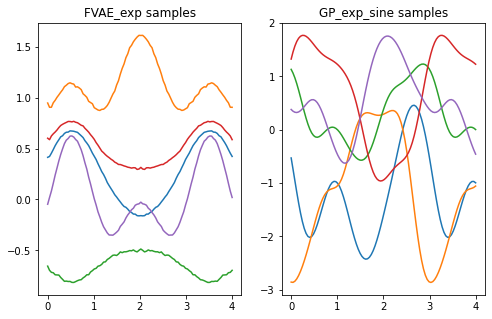

In [ ]:
# sample and decode
n_samples = 20
samples= decoder(prior.sample(n_samples)).mean()

# inverse fourier transform
samples = np.fft.ifft(samples)

fig, axs = plt.subplots(1, 2, figsize=(8, 5))

for i in range(5):
  axs[0].plot(X,samples[i,:])
  axs[1].plot(X, Y_test[i,:])
axs[0].set_title('FVAE_exp samples')
axs[1].set_title('GP_exp_sine samples')

## Fourier Transform VAE on Stock Data


### Load and prep data

In [2]:
import numpy as np

In [9]:
# load data
import pandas as pd
import glob
file_dir='./drive/My Drive/ThesisData/individual_stocks_5yr'
file_names = glob.glob('{}/*.csv'.format(file_dir))

stock_high_data=[]
for i in range(len(file_names)):
  stock = pd.read_csv(file_names[i])
  stock = stock['high']# extract daily highs
  stock_high_data.append(stock)

In [10]:
# number of NaN in data very small, just remove
sum([np.count_nonzero(np.isnan(x)) for x in stock_high_data])

stock_high_data = [x[~np.isnan(x)] for x in stock_high_data]

In [5]:
# check out one of the paths
short = pd.read_csv(file_names[3])
short.head()

date     open   high    low    close  volume Name
0  2017-07-17  75.0000  75.00  70.00  70.0000   33982  BHF
1  2017-07-18  70.5000  72.00  69.92  70.0000   35719  BHF
2  2017-07-19  67.9200  69.51  67.80  68.9500    1805  BHF
3  2017-07-20  69.7489  70.00  69.00  69.0000   28390  BHF
4  2017-07-21  70.0000  70.00  68.56  68.9226    1562  BHF

In [11]:
# only data streans with more than 500 points
# could use padding in ffr instead, might try later

def prep_data(min_length=1200, num_freq=100, data=stock_high_data, normal=1):

  long_data = [x for x in data if len(x)>=min_length]
  if normal==None:
    normal = min([len(x) for x in long_data])
  # apply fourier transform to data
  # rfft to exploit redundancy for real input and speed up algorithm
  fourier_stock = [np.fft.rfft(x/normal) for x in long_data]
  # truncate after num_freq (0.5% even) frequencies, max can be n//2 + 1
  fourier_stock_trunc = [x[:num_freq] for x in fourier_stock]
  # stack rows
  fourier_stock_trunc = np.row_stack(fourier_stock_trunc)
  # concatenate real and imaginary parts and normalise
  real_stock = fourier_stock_trunc.real
  imag_stock = fourier_stock_trunc.imag
  full_stock = np.concatenate([real_stock,imag_stock], axis=1)

  input_shape = (2*num_freq,)

  return normal, full_stock, long_data, fourier_stock, input_shape

In [12]:
norm, full_stock, long_data, fourier_stock, input_shape = prep_data(min_length=1258,num_freq=50, normal=1)

In [172]:
len(long_data)

468

In [8]:
import matplotlib.pyplot as plt
def plot_fourier_rec(sample, num_fourier=[50, 100, 200], fourier_stock=fourier_stock, normal=norm):

  n_rows, n_cols = 3, 1
  
  fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 20))
  for i, ax in enumerate(fig.axes):
  
      l = len(fourier_stock[sample])
      fourier_rec = np.fft.irfft(np.concatenate([fourier_stock[sample][:num_fourier[i]], np.zeros(l - num_fourier[i])])).real * normal
      ax.set_ylabel(str(i))
      ax.set_title('N={}'.format(num_fourier[i]))
      ax.plot(long_data[sample])
      ax.plot(np.linspace(0,1259, len(fourier_rec)), fourier_rec)

      #ax.legend(loc='upper right')
  fig.suptitle('Original and truncated Fourier Transform reconstruction')
  plt.show()

In [9]:
l = len(fourier_stock[1])
len(np.concatenate([fourier_stock[1][:50], np.zeros(l - 50)]))

630

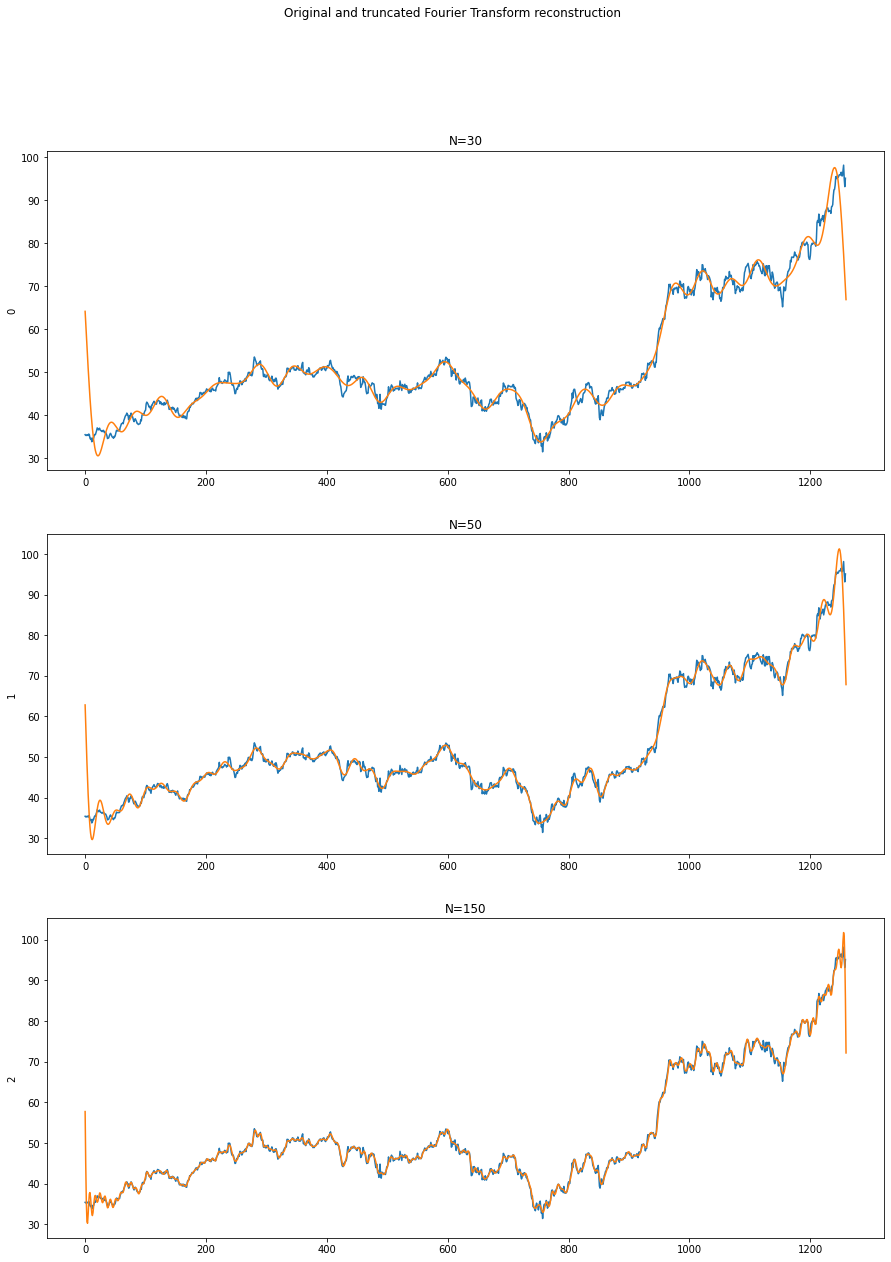

In [10]:
plot_fourier_rec(20, num_fourier=[30, 50, 150])

In [140]:
max_val = np.max(full_stock)
full_stock = full_stock/max_val

### With Tensorflow probability, sometimes strange

In [7]:
full_stock = full_stock/2500

In [ ]:
# Build the encoder with KLAddLossLayer
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

from tensorflow.keras.callbacks import EarlyStopping
latent_size=10
#input_shape=(1200,)

# Define the prior
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)

encoder = Sequential([
    Dense(80, activation='relu', input_shape=input_shape), # adjust shape
    Dense(60, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(60, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(40, activation='relu', kernel_regularizer=l2(1e-4)),
    #Dense(200, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(tfpl.IndependentNormal.params_size(latent_size)),
    tfpl.IndependentNormal(latent_size),
    tfpl.KLDivergenceAddLoss(prior, use_exact_kl=False, weight=1, test_points_fn= lambda q: q.sample(10), 
                             test_points_reduce_axis=None) # could possibly use exact KL divergence since Normal
          ])

decoder = Sequential([
    Dense(40, activation='relu', input_shape=(latent_size,)),
    Dense(60, activation='relu'),
    Dense(60, activation='relu'),
    Dense(80, activation='relu'),
    #Dense(1200, activation='relu'),
    Dense(tfpl.IndependentNormal.params_size(input_shape)),
    tfpl.IndependentNormal(input_shape)
          ])
    

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
#early_stopping = EarlyStopping(patience=30)

FVAE_concat = Model(encoder.inputs, decoder(encoder.outputs))
FVAE_concat.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
history = FVAE_concat.fit(full_stock, full_stock,  epochs=400, batch_size=20) #,callbacks=[early_stopping])

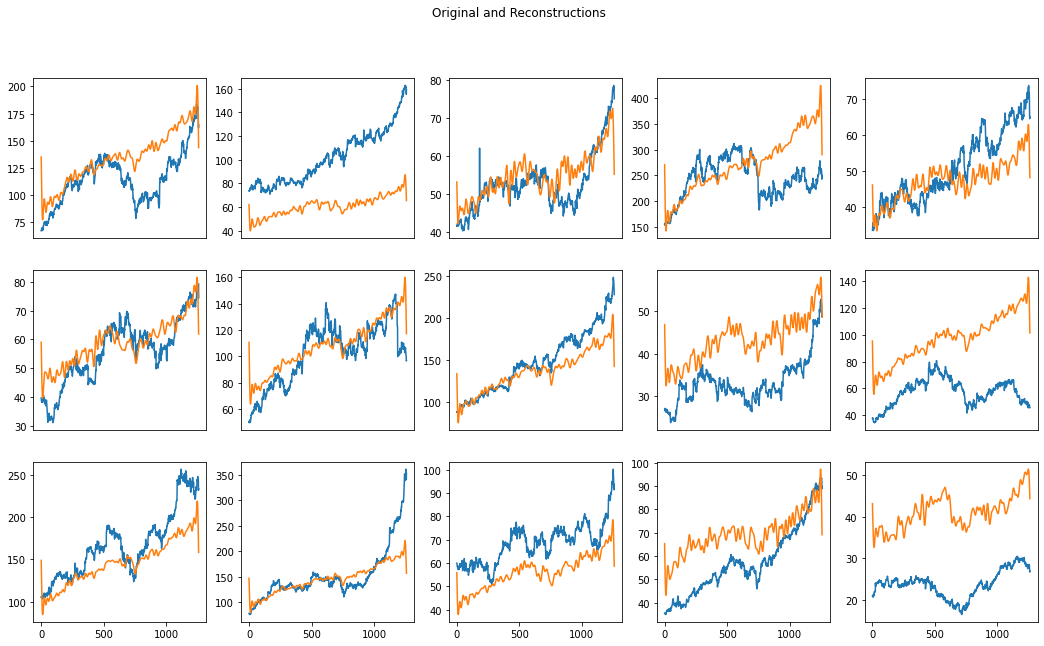

In [16]:
num_freq=50
num_examples = 20

out_test = FVAE_concat(full_stock[:num_examples,:]).mean()
out_ft = (out_test[:,:num_freq].numpy() + 1j * out_test[:,num_freq:].numpy())* 2500
#l = len(fourier_stock[1])
#fourier_rec = np.fft.irfft(np.concatenate([out_ft, np.zeros((num_examples,l - num_freq))], axis=1))

#tester = [np.fft.irfft(x) for x in fourier_stock[:num_examples]]

reconstructions = fourier_rec
# View the reconstructions and original

n_rows, n_cols = 3, 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 10))
for i, ax in enumerate(fig.axes):
    l = len(fourier_stock[i])
    fourier_rec = np.fft.irfft(np.concatenate([out_ft[i,:], np.zeros((l - num_freq))]))
    X = np.linspace(0,1259, len(long_data[i]))
    X_ = np.linspace(0,1259, len(fourier_rec))

    #ax.set_ylabel(str(i))
    ax.plot(X, long_data[i], label='original')
    #ax.plot(X_, reconstructions[i,:].real, label='reconstructed')
    ax.plot(X_, fourier_rec.real, label='reconstructed')
    #ax.set_ylim([-15,15])
    #if i!=0 and i!=5 and i!=10:
    #  ax.get_yaxis().set_visible(False)
    if i<10:
      ax.get_xaxis().set_visible(False)
    #ax.legend(loc='upper right')
fig.suptitle('Original and Reconstructions')
plt.show()

In [13]:
num_freq=50
num_examples = 20


out_ft = (full_stock[:num_examples,:num_freq] + 1j * full_stock[:num_examples,num_freq:])* 3000
l = len(fourier_stock[1])
fourier_rec = np.fft.irfft(np.concatenate([out_ft, np.zeros((num_examples,l - num_freq))], axis=1))

reconstructions = fourier_rec
# View the reconstructions and original

n_rows, n_cols = 3, 5
X = np.linspace(0,1259, len(long_data[i]))
X_ = np.linspace(0,1259, len(fourier_rec[1,:]))
fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 10))
for i, ax in enumerate(fig.axes):
    #ax.set_ylabel(str(i))
    ax.plot(X, long_data[i], label='original')
    ax.plot(X_, reconstructions[i,:].real, label='reconstructed')
    #ax.set_ylim([-15,15])
    #if i!=0 and i!=5 and i!=10:
    #  ax.get_yaxis().set_visible(False)
    if i<10:
      ax.get_xaxis().set_visible(False)
    #ax.legend(loc='upper right')
fig.suptitle('Original Perfect Fourier Interpolation')
plt.show()

IndexError: ignored

Text(0.5, 1.0, 'GP samples')

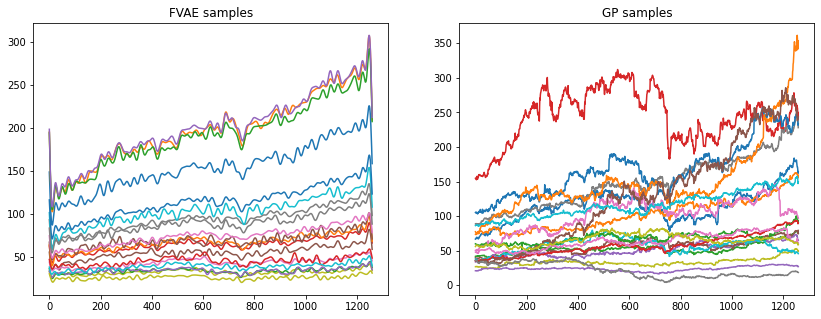

In [18]:
# sample and decode
n_samples = 20
num_freq=50
samples= decoder(prior.sample(n_samples)).mean()*2500
#X_ = np.linspace(0,800,400)
# inverse fourier transform
ft = samples[:,:num_freq].numpy() + 1j*samples[:,num_freq:].numpy()
samples = np.fft.irfft(np.concatenate([ft, np.zeros((n_samples, l-num_freq))], axis=1))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for i in range(0,20):
  axs[0].plot(X_,samples[i,:].real)
  axs[1].plot(X, long_data[i])
axs[0].set_title('FVAE samples')
axs[1].set_title('GP samples')

### VAE base implementation and some functions to visualise results

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.models import Model

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


class Encoder(layers.Layer):
    """Signature input to a triplet (z_mean, z_log_var, z)."""

    def __init__(self, latent_dim=10, intermediate_dim=40, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.dense_proj = Dense(intermediate_dim, activation="relu")
        self.dense_mean = Dense(latent_dim)
        self.dense_log_var = Dense(latent_dim)
        self.sampling = Sampling()

    def call(self, inputs):
        x = self.dense_proj(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


class Decoder(layers.Layer):
    """Converts z, the encoded signature vector, back into a signature."""

    def __init__(self, original_dim, intermediate_dim=40, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.dense_proj = Dense(intermediate_dim, activation="relu")
        self.dense_output = Dense(original_dim)

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)


class VariationalAutoEncoder(Model):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(
        self,
        original_dim,
        intermediate_dim=64,
        latent_dim=32,
        name="autoencoder",
        **kwargs
    ):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.original_dim = original_dim
        self.encoder = Encoder(latent_dim=latent_dim, intermediate_dim=intermediate_dim)
        self.decoder = Decoder(original_dim, intermediate_dim=intermediate_dim)
        #self.mean_list = []
        #self.log_var_list = []

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        #self.mean_list.append(z_mean)
        #self.log_var_list.append(z_log_var)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstructed

In [11]:
 def invert_fourier(fourier_data, original_length_of_FFT, normalise_fourier, normalise_path):

  if len(fourier_data.shape)==1:
    num_freq = len(fourier_data)//2
  else:
    num_freq = fourier_data.shape[1]//2

  real_added_complex = (fourier_data[:,:num_freq].numpy() + 1j * out_test[:,num_freq:].numpy())* normalise_fourier

  l = original_length_of_FFT

  inverted = np.fft.irfft(np.concatenate([real_added_complex[:num_reconstructed,:], np.zeros((num_reconstructed,l - num_freq))], axis=1)) * normalise_path
  return inverted

 def reconstruct(fourier_data, num_reconstructed, original_length_of_FFT,tf_prob=False, normalise_fourier=1, normalise_path=1):
  if num_reconstructed==None:
    num_reconstructed = fourier_data.shape[1]
  if tf_prob:
    vae_output = vae(fourier_data[:num_reconstructed,:]).mean()
  else:
    vae_output = vae(fourier_data[:num_reconstructed,:])
  # half of the values corresponds to real and other half to complex coefficients  
  reconstructed = invert_fourier(vae_output, original_length_of_FFT, normalise_fourier, normalise_path)
  return reconstructed

def plot_vae_reconstructions(vae, num_freq, num_example, reconstructed, original):
  
  # View the reconstructions and original
  n_rows, n_cols = 2, 4

  fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 10))
  for i, ax in enumerate(fig.axes):
     
      X = np.linspace(0,1259, len(original[i]))
      X_ = np.linspace(0,1259, len(reconstructed[i]))

      #ax.set_ylabel(str(i))
      ax.plot(X, original[i], label='original')
      ax.plot(X_, reconstructed[i], label='reconstructed')
      #ax.set_ylim([-15,15])
      #if i!=0 and i!=5 and i!=10:
      #  ax.get_yaxis().set_visible(False)
      if i<10:
        ax.get_xaxis().set_visible(False)
      if i ==3:
        ax.legend(loc='upper right')
  fig.suptitle('Original and FFT-VAE Reconstructions')
  plt.show()

In [12]:
def sample_vae(decoder, prior, num_samples, original_length_of_FFT, latent_size, tf_prob=False, normalise_fourier=1, normalise_path=1):

  if prior==None:
    prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)
  if tf_prob:
    fourier_samples= decoder(prior.sample(num_samples)).mean()
  else:
    fourier_samples= decoder(prior.sample(num_samples))

  path_samples = invert_fourier(fourier_samples, original_length_of_FFT, normalise_fourier, normalise_path)

  return path_samples

def plot_samples_v_original(original, decoder, prior, num_samples, original_length_of_FFT, latent_size, tf_prob=False, normalise_fourier=1, normalise_path=1):

  samples = sample_vae(decoder, prior, num_samples, original_length_of_FFT, latent_size, tf_prob, normalise_fourier, normalise_path)

  fig, axs = plt.subplots(1, 2, figsize=(14, 5))
  y_upper = np.max(np.max(samples), np.max(original))
  y_lower = np.median(np.min(samples), np.min(original))
  for i in range(0,num_samples):
    X_l = np.linspace(0,1259, len(original[i,:]))
    X_f = np.linspace(0,1259, samples.shape[1])
    axs[0].plot(X_f,samples[i,:], color='blue', alpha=0.2)
    axs[1].plot(X_l, original[i,:], color='blue', alpha=0.2)
    axs[0].set_ylim([y_lower,y_upper])
    axs[1].set_ylim([y_lower,y_upper])
  axs[0].set_title('FVAE samples')
  axs[1].set_title('Original Data')
  plt.show()

### Train VAE and show results

In [147]:

norm, full_stock, long_data, fourier_stock, input_shape = prep_data(min_length=1258,num_freq=50, normal=1)

In [148]:
full_stock = full_stock/3000

In [ ]:
vae = VariationalAutoEncoder(100, 80, 10)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
hist = vae.fit(full_stock, full_stock, epochs=1000, batch_size=25)

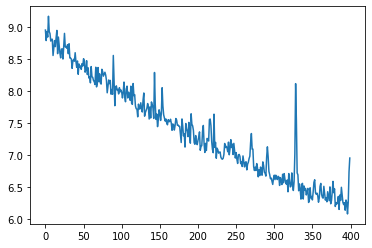

In [155]:
plt.plot(hist.history['loss'])

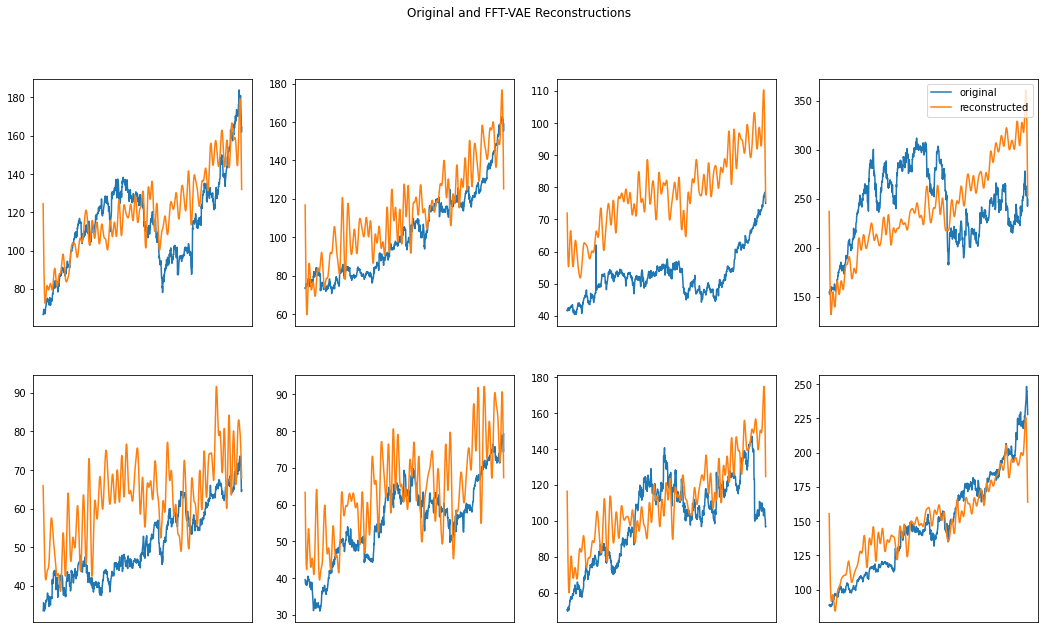

In [152]:
plot_vae_reconstructions(vae=vae, num_freq=50, full_stock=full_stock, normal_fourier=3000, normal_path=1, fourier_stock=fourier_stock, long_data = long_data, tf_prob=False)

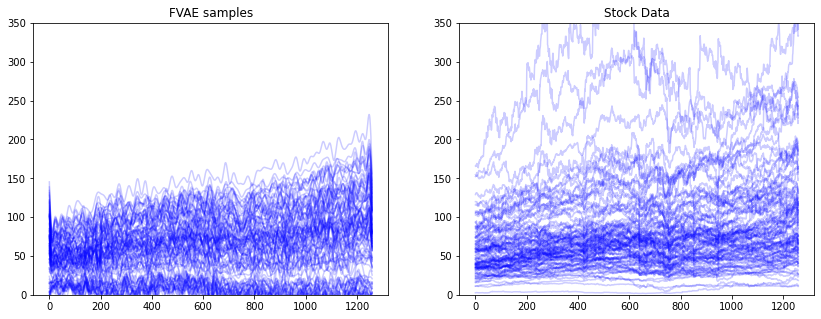

In [154]:
plot_samples_v_original(decoder=vae.decoder, tf_prob=False, num_samples=100, normal_fourier=3000, normal_path=1, num_freq=50)

Had a better one before, but very dependent on training...
Not consistently good results. A lot noisier than original data. How to control this??

### FFt VAE split each stream into junks to increase dataset size

In [20]:
def split_data(split_length=100, num_freq=100, stock_high_data=stock_high_data):

  n = split_length
  # split lists
  final = [[my_list[i * n:(i + 1) * n] for i in range((len(my_list) + n - 1) // n )] for my_list in stock_high_data]
  # concatenate lists of lists
  split = []
  for i in range(len(final)):
    split.extend(final[i])
  
  # filter out splits of length smaller than split_length
  split = [x for x in split if len(x)==split_length]

  return split

In [22]:
split = split_data()

In [46]:
norm, full_stock, long_data, fourier_stock, input_shape = prep_data(min_length=100,num_freq=40, data=split)

In [47]:
full_stock = full_stock/500

In [48]:
# Build the encoder with KLAddLossLayer
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

from tensorflow.keras.callbacks import EarlyStopping
latent_size=10
#input_shape=(1200,)

# Define the prior
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)

encoder = Sequential([
    Dense(80, activation='relu', input_shape=input_shape), # adjust shape
    Dense(60, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(60, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(40, activation='relu', kernel_regularizer=l2(1e-4)),
    Dense(tfpl.IndependentNormal.params_size(latent_size)),
    tfpl.IndependentNormal(latent_size),
    tfpl.KLDivergenceAddLoss(prior, use_exact_kl=False, weight=1, test_points_fn= lambda q: q.sample(10), 
                             test_points_reduce_axis=None) # could possibly use exact KL divergence since Normal
          ])

decoder = Sequential([
    Dense(40, activation='relu', input_shape=(latent_size,)),
    Dense(60, activation='relu'),
    Dense(60, activation='relu'),
    Dense(80, activation='relu'),
    Dense(tfpl.IndependentNormal.params_size(input_shape)),
    tfpl.IndependentNormal(input_shape)
          ])
    

# compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

early_stopping = EarlyStopping(patience=30)

FVAE_concat = Model(encoder.inputs, decoder(encoder.outputs))
FVAE_concat.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
history = FVAE_concat.fit(full_stock, full_stock,  epochs=400, validation_split=0.2, batch_size=20, callbacks=[early_stopping])

Epoch 1/400
236/236 [==============================] - 2s 5ms/step - loss: 9.5911 - val_loss: 4.6377
Epoch 2/400
236/236 [==============================] - 1s 4ms/step - loss: 5.0741 - val_loss: 2.1400
Epoch 3/400
236/236 [==============================] - 1s 4ms/step - loss: 3.2319 - val_loss: 2.0664
Epoch 4/400
236/236 [==============================] - 1s 4ms/step - loss: 2.9432 - val_loss: 1.7143
Epoch 5/400
236/236 [==============================] - 1s 4ms/step - loss: 2.4166 - val_loss: 1.5905
Epoch 6/400
236/236 [==============================] - 1s 3ms/step - loss: 2.1940 - val_loss: 1.5031
Epoch 7/400
236/236 [==============================] - 1s 4ms/step - loss: 2.0508 - val_loss: 1.4957
Epoch 8/400
236/236 [==============================] - 1s 4ms/step - loss: 1.8670 - val_loss: 1.4449
Epoch 9/400
236/236 [==============================] - 1s 4ms/step - loss: 1.7684 - val_loss: 1.4169
Epoch 10/400
236/236 [==============================] - 1s 4ms/step - loss: 1.7244 - val_lo

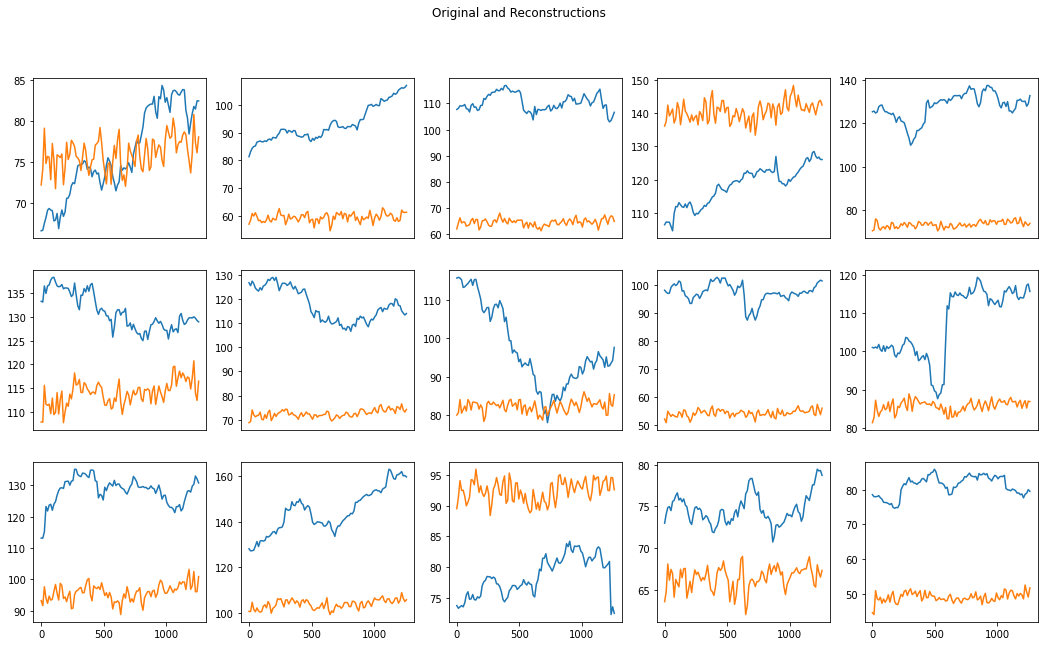

In [45]:
num_freq=40
num_examples = 20
import matplotlib.pyplot as plt

out_test = FVAE_concat(full_stock[:num_examples,:]).mean()
out_ft = (out_test[:,:num_freq].numpy() + 1j * out_test[:,num_freq:].numpy())* 500
#l = len(fourier_stock[1])
#fourier_rec = np.fft.irfft(np.concatenate([out_ft, np.zeros((num_examples,l - num_freq))], axis=1))

#tester = [np.fft.irfft(x) for x in fourier_stock[:num_examples]]

#reconstructions = fourier_rec
# View the reconstructions and original

n_rows, n_cols = 3, 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 10))
for i, ax in enumerate(fig.axes):
    l = len(fourier_stock[i])
    fourier_rec = np.fft.irfft(np.concatenate([out_ft[i,:], np.zeros((l - num_freq))]))
    X = np.linspace(0,1259, len(long_data[i]))
    X_ = np.linspace(0,1259, len(fourier_rec))

    #ax.set_ylabel(str(i))
    ax.plot(X, long_data[i], label='original')
    #ax.plot(X_, reconstructions[i,:].real, label='reconstructed')
    ax.plot(X_, fourier_rec.real, label='reconstructed')
    #ax.set_ylim([-15,15])
    #if i!=0 and i!=5 and i!=10:
    #  ax.get_yaxis().set_visible(False)
    if i<10:
      ax.get_xaxis().set_visible(False)
    #ax.legend(loc='upper right')
fig.suptitle('Original and Reconstructions')
plt.show()

### FFT VAE with Prior from marginal empirical standard deviation

Simply comput marginal standard deviation and then use these as variance diagonal in prior. Don't see why this would work at all, absolutely no reason.

Need to think about Karhunen Loeve decomposition.
- How does it work with the fourier coefficients
- Can I do principal component analysis on the fourier coefficients?
- No reason to believe principal components are normally distributed
- Functional Principal components makes the most sense, then can link to karhunen loeve decomposition, but why thesn have a neural network layer? is that not the point of learning it? Need to think....

In [16]:
column_var = np.var(full_stock, axis=0)

In [52]:
var = np.sort(column_var)[-10:]

In [17]:
latent_size=10
#input_shape=(100,)
var = np.sort(column_var)[-latent_size:]
# Define the prior
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=tf.cast(tf.constant(var), tf.float32)), reinterpreted_batch_ndims=1)

loss=tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [18]:
# Build the encoder with KLAddLossLayer
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

from tensorflow.keras.callbacks import EarlyStopping

def get_VAE(input_shape=input_shape, latent_size=latent_size, prior=prior, optimizer=optimizer, loss=tf.keras.losses.MeanSquaredError()):
  encoder = Sequential([
      Dense(80, activation='relu', input_shape=input_shape), # adjust shape
      Dense(60, activation='relu', kernel_regularizer=l2(1e-4)),
      Dense(40, activation='relu', kernel_regularizer=l2(1e-4)),
      #Dense(200, activation='relu', kernel_regularizer=l2(1e-4)),
      Dense(tfpl.IndependentNormal.params_size(latent_size)),
      tfpl.IndependentNormal(latent_size),
      tfpl.KLDivergenceAddLoss(prior, use_exact_kl=False, weight=1, test_points_fn= lambda q: q.sample(10), 
                              test_points_reduce_axis=None) # could possibly use exact KL divergence since Normal
            ])

  decoder = Sequential([
      Dense(40, activation='relu', input_shape=(latent_size,)),
      Dense(60, activation='relu'),
      Dense(80, activation='relu'),
      #Dense(1200, activation='relu'),
      Dense(tfpl.IndependentNormal.params_size(input_shape)),
      tfpl.IndependentNormal(input_shape)
            ])
      

  # compile model
  FVAE_concat = Model(encoder.inputs, decoder(encoder.outputs))
  FVAE_concat.compile(optimizer, loss=loss)
  return FVAE_concat, decoder, encoder

In [ ]:
FVAE_concat, decoder, encoder = get_VAE(loss=loss)

history = FVAE_concat.fit(full_stock, full_stock,  epochs=400, batch_size=25)

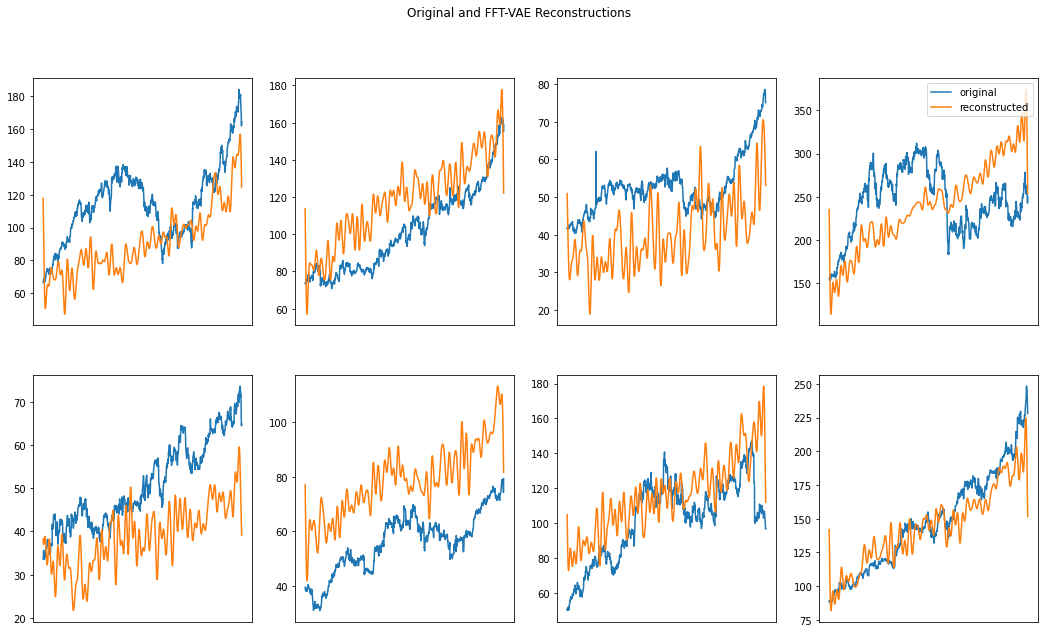

In [68]:
# plot some VAE reconstructions
plot_vae_reconstructions(vae=FVAE_concat)

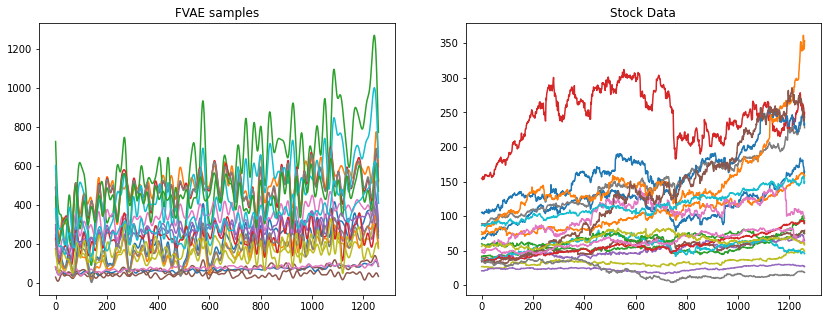

In [77]:
plot_samples_v_original(decoder=decoder, prior=prior)

In [99]:
norm, full_stock, long_data, fourier_stock, input_shape = prep_data(min_length=1258,num_freq=30, normal=1)

In [100]:
full_stock = full_stock/2500

In [ ]:
latent_size=10
column_var = np.var(full_stock, axis=0)
var = np.sort(column_var)[-latent_size:]
# Define the prior
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=tf.cast(tf.constant(var), tf.float32)), reinterpreted_batch_ndims=1)

loss=tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

FVAE_concat, decoder, encoder = get_VAE(input_shape=input_shape, loss=loss)

history = FVAE_concat.fit(full_stock, full_stock,  epochs=400, batch_size=25)

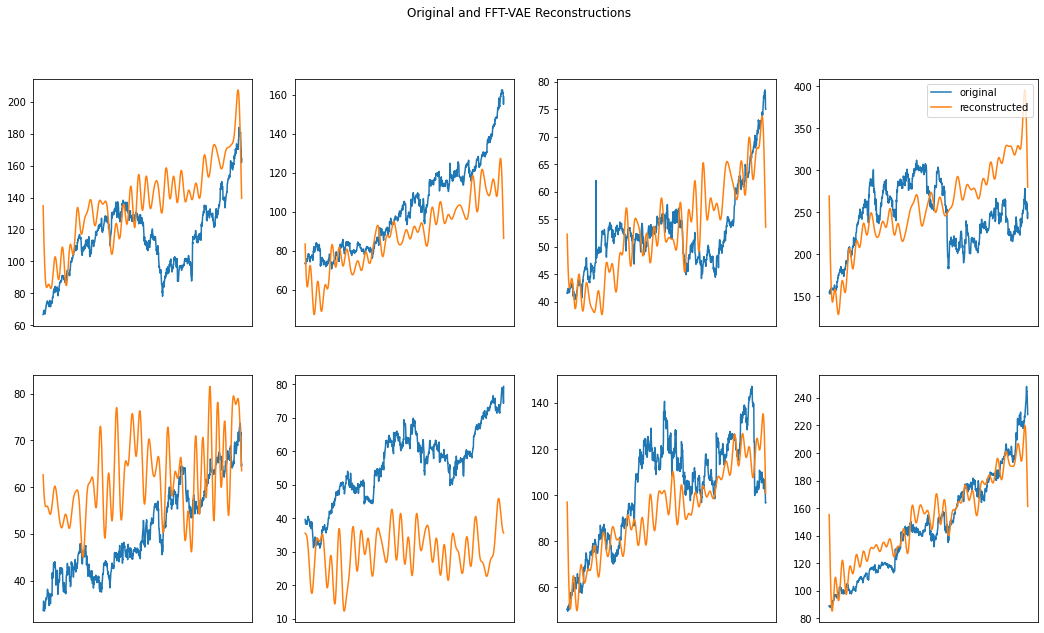

In [106]:
plot_vae_reconstructions(vae=FVAE_concat, num_freq=30, full_stock=full_stock, normal=2500, fourier_stock=fourier_stock, long_data = long_data)

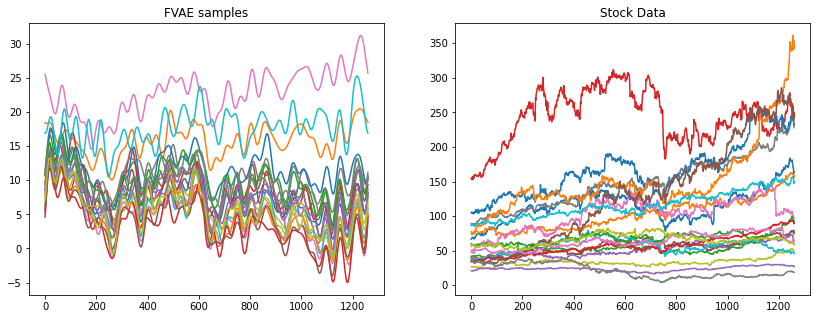

In [108]:
plot_samples_v_original(decoder=decoder, tf_prob=True, num_freq=30)

### Get prior variances from PCA on fourier transform coefficients

In [116]:
norm, full_stock, long_data, fourier_stock, input_shape = prep_data(min_length=1258,num_freq=30, normal=max([max(x) for x in stock_high_data if len(x)>1258]))

In [117]:
print(np.max(np.abs(full_stock)))
print(np.min(np.abs(full_stock)))

806.1676452497352
0.0


In [118]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca.fit(full_stock)


PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

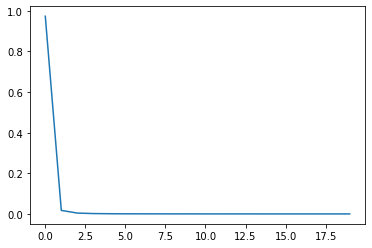

In [119]:
plt.plot(pca.explained_variance_ratio_)

In [120]:
print(pca.singular_values_)

[1210.27581597  161.66333745   79.39419638   51.34712767   38.77551139
   27.65615781   25.53084238   20.4606466    17.72397881   15.4316562
   12.95572118   11.40193146   10.21785615    9.72799931    8.36562063
    7.97641478    7.86512323    6.98401687    6.73852929    6.22694566]


In [ ]:
var = pca.singular_values_[]

In [ ]:
latent_size=10
column_var = np.var(full_stock, axis=0)
var = np.sqrt(pca.singular_values_[:latent_size])
# Define the prior
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=tf.cast(tf.constant(var), tf.float32)), reinterpreted_batch_ndims=1)

loss=tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

FVAE_concat, decoder, encoder = get_VAE(input_shape=input_shape, loss=loss)

history = FVAE_concat.fit(full_stock, full_stock,  epochs=400, batch_size=25)

In [ ]:
history = FVAE_concat.fit(full_stock, full_stock,  epochs=400, batch_size=25)

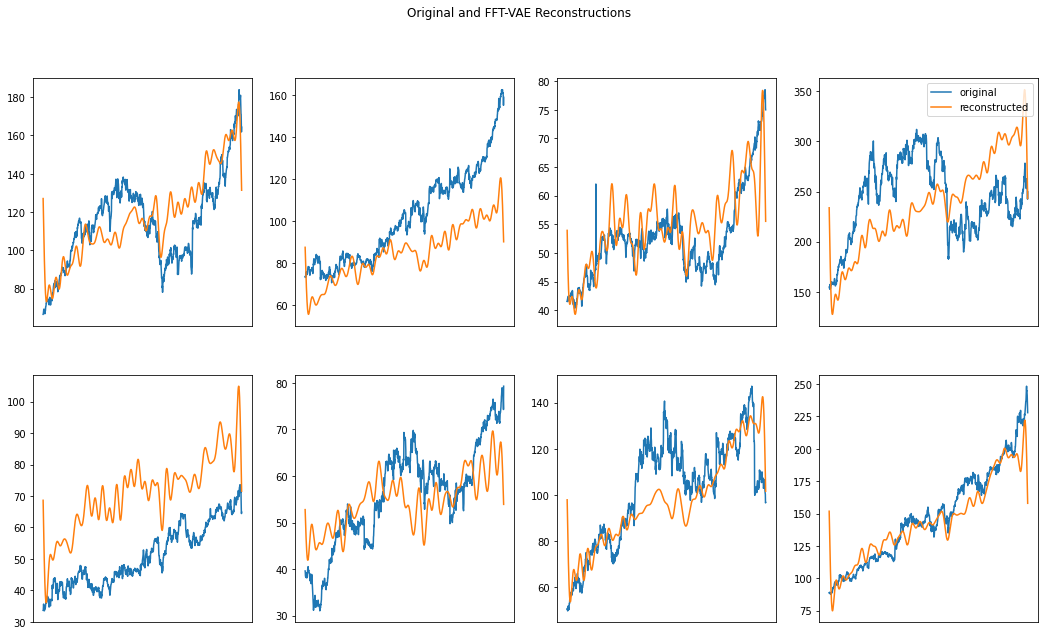

In [127]:
normalise_paths = max([max(x) for x in stock_high_data if len(x)>1258])
plot_vae_reconstructions(vae=FVAE_concat, num_freq=30, full_stock=full_stock, normal_fourier=1, normal_path=normalise_paths, fourier_stock=fourier_stock, long_data = long_data)

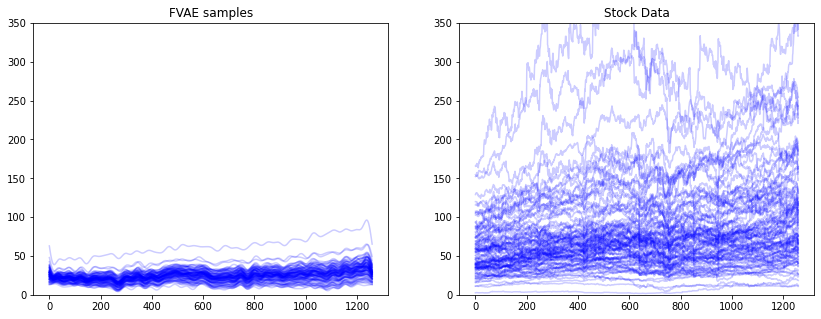

In [143]:
plot_samples_v_original(num_samples=100, decoder=decoder, normal_fourier=1, normal_path=normalise_paths, tf_prob=True, num_freq=30)

## FFt_VAE on spectra Data

### import the sugar spectra data set

In [3]:
import glob
import pandas as pd
import numpy as np
file_dir='./drive/My Drive/ThesisData/Sugar_csv'
file_names = glob.glob('{}/wave*'.format(file_dir))

def get_sugar_data(file_names=file_names):
  data = map(pd.read_csv, file_names)
  data = [d.values for d in data]
  return np.stack(data, axis=2)

In [4]:
# load covariates and compute signature
data = get_sugar_data()
X = data

In [5]:
X = X[:,1:,:]

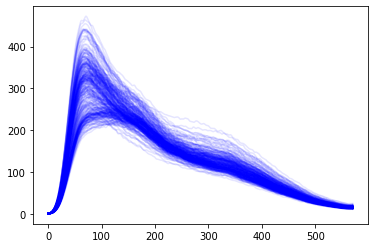

In [26]:
import matplotlib.pyplot as plt
plot = plt.plot(np.transpose(X[:,:,0]), color='blue', alpha=0.1)

In [6]:
def prep_spectra(data, num_freq=100):

  
  # apply fourier transform to data
  # rfft to exploit redundancy for real input and speed up algorithm
  fourier_spectra = np.fft.rfft(data)
  # truncate after num_freq (0.5% even) frequencies, max can be n//2 + 1
  fourier_spectra_trunc = fourier_spectra[:,:num_freq]
  # concatenate real and imaginary parts and normalise
  real_spectra = fourier_spectra_trunc.real
  imag_spectra = fourier_spectra_trunc.imag
  full_spectra = np.concatenate([real_spectra,imag_spectra], axis=1)

  input_shape = (2*num_freq,)

  return full_spectra, fourier_spectra, input_shape

In [7]:
full_spectra, fourier_spectra, input_shape = prep_spectra(X[:,:,0], num_freq=50)

In [8]:
full_spectra = full_spectra/1000

In [ ]:
latent_size=10

# Define the prior
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)

loss=tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

FVAE_spectra, decoder_spectra, encoder = get_VAE(input_shape=input_shape, loss=loss)

history = FVAE_spectra.fit(full_spectra, full_spectra,  epochs=800, batch_size=25)

In [64]:
Spectra_vae = VariationalAutoEncoder(60, 60, 10)

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

Spectra_vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
hist = Spectra_vae.fit(full_spectra, full_spectra, epochs=2000, batch_size=25)

Epoch 1/2000
11/11 [==============================] - 1s 3ms/step - loss: 173.4378
Epoch 2/2000
11/11 [==============================] - 0s 3ms/step - loss: 126.3089
Epoch 3/2000
11/11 [==============================] - 0s 2ms/step - loss: 109.9431
Epoch 4/2000
11/11 [==============================] - 0s 3ms/step - loss: 98.9678
Epoch 5/2000
11/11 [==============================] - 0s 2ms/step - loss: 87.1496
Epoch 6/2000
11/11 [==============================] - 0s 2ms/step - loss: 74.2787
Epoch 7/2000
11/11 [==============================] - 0s 2ms/step - loss: 62.5574
Epoch 8/2000
11/11 [==============================] - 0s 2ms/step - loss: 53.1508
Epoch 9/2000
11/11 [==============================] - 0s 3ms/step - loss: 44.9043
Epoch 10/2000
11/11 [==============================] - 0s 2ms/step - loss: 38.5731
Epoch 11/2000
11/11 [==============================] - 0s 2ms/step - loss: 33.2253
Epoch 12/2000
11/11 [==============================] - 0s 2ms/step - loss: 29.2726
Epoch 13/2

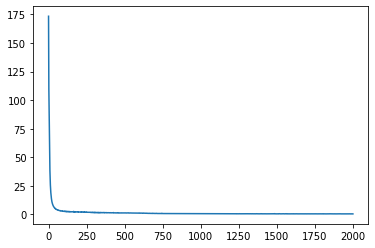

In [65]:
plt.plot(hist.history['loss'])

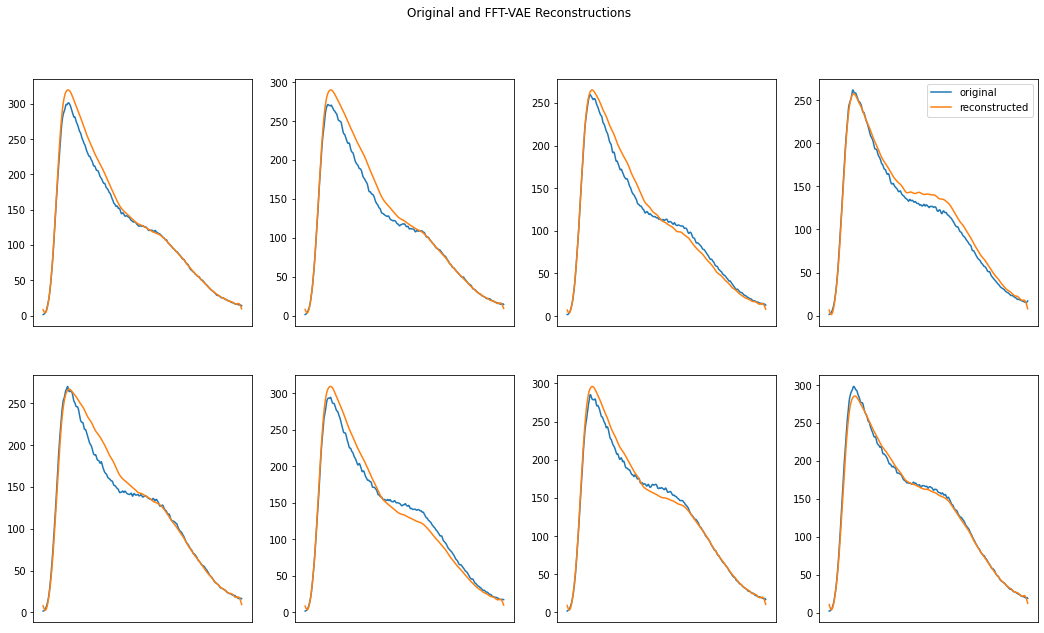

In [66]:
plot_vae_reconstructions(vae=Spectra_vae, num_freq=30, full_stock=full_spectra, tf_prob=False, normal_fourier=1000, normal_path=1, fourier_stock=fourier_spectra, long_data = [X[i,:,0] for i in range(X.shape[0])])

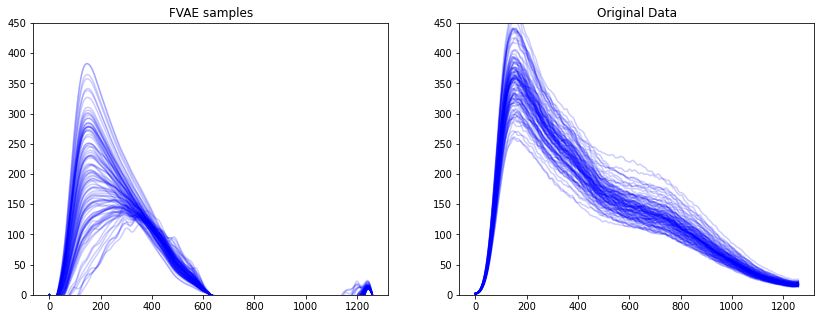

In [69]:
plot_samples_v_original(num_samples=100, decoder=Spectra_vae.decoder, normal_fourier=4000, normal_path=1, prior=prior, tf_prob=False, num_freq=30, long_data=[X[i,:,0] for i in range(X.shape[0])], y_upper=450)

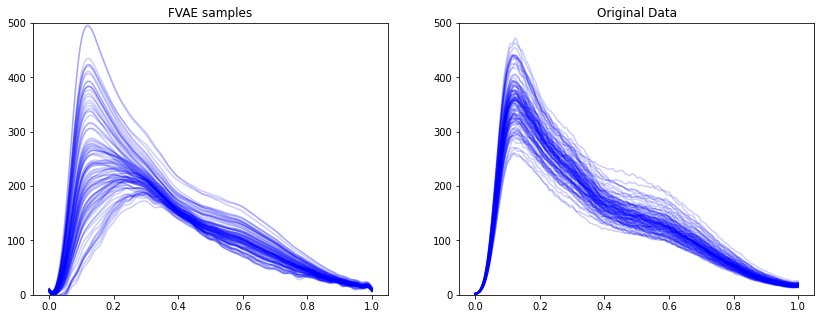

In [72]:
# inverse fourier transform
num_samples = 100
num_freq=30
y_upper=500
prior = tfd.Independent(tfd.Normal(loc=tf.zeros(latent_size), scale=1), reinterpreted_batch_ndims=1)
long_data=[X[i,:,0] for i in range(X.shape[0])]
samples= Spectra_vae.decoder(prior.sample(num_samples))
l = fourier_spectra.shape[1]
ft = (samples[:,:num_freq].numpy() + 1j*samples[:,num_freq:].numpy()) * 1000
samples = np.fft.irfft(np.concatenate([ft, np.zeros((num_samples, l-num_freq))], axis=1))

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

for i in range(0,num_samples):
  X_l = np.linspace(0,1, len(long_data[i]))
  X_f = np.linspace(0,1, samples.shape[1])
  axs[0].plot(X_f,samples[i,:].real, color='blue', alpha=0.2)
  axs[1].plot(X_l, long_data[i], color='blue', alpha=0.2)
  axs[0].set_ylim([0,y_upper])
  axs[1].set_ylim([0,y_upper])
axs[0].set_title('FVAE samples')
axs[1].set_title('Original Data')
plt.show()

## VampPrior VAE

### Layers

In [10]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers
import numpy as np


class GatedDense(tf.keras.layers.Layer):
    def __init__(self, units, hactivation='sigmoid', **kwargs):
        super(GatedDense, self).__init__(**kwargs)
        self.hactivation = hactivation
        self.units = units

    def build(self, inputs_shape):
        self.g = tf.keras.layers.Dense(self.units, activation='sigmoid')
        if self.hactivation == 'sigmoid':
            self.h = tf.keras.layers.Dense(self.units, activation='sigmoid')
        else:
            self.h = tf.keras.layers.Dense(self.units)

    def call(self, inputs):
        hout = self.h(inputs)
        gout = self.g(inputs)

        if self.hactivation != 'sigmoid':
            hout = self.hactivation(hout)

        return tf.math.multiply(hout, gout)


class Encoder(tf.keras.layers.Layer):
    def __init__(self, D, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.D = D

    def build(self, inputs_shape):
        #self.flatten = layers.Flatten(input_shape=(inputs_shape[1], inputs_shape[2]),
                                    #  name='enc-flatten')
        self.dense0 = GatedDense(80, 'sigmoid', name='enc-dense1')
        self.dense1 = GatedDense(80, 'sigmoid', name='enc-dense1')

        self.dense_mu = layers.Dense(self.D, name='enc-out-mu')
        self.dense_logvar = layers.Dense(self.D, name='enc-out-lo', activation=Clamp(min_value=-4., max_value=2.))

    def call(self, inputs):
        #flattened = self.flatten(inputs)

        x = self.dense0(inputs)
        x = self.dense1(x)

        mu = self.dense_mu(x)
        logvar = self.dense_logvar(x)
        return mu, logvar


class Sampling(tf.keras.layers.Layer):
    """
    When called returns L samples of dimension D from the gaussians with the
    mu and logvar passed as input, using the reparametrization trick
    """

    def __init__(self, D, L, single=False, **kwargs):
        super(Sampling, self).__init__(**kwargs)
        self.L = L
        self.D = D
        self.single = single

        # the standard distribution to be used when sampling
        # needed for the reparametrization trick
        self.normal_standard = tfp.distributions.MultivariateNormalDiag(
            tf.zeros(shape=(self.D,)),
            tf.ones(shape=(self.D,)))

    def call(self, inputs):
        mu, logvar = inputs

        # samples with the reparametrization trick
        # N(0, I) * sigma + mu

        latent_samples = self.normal_standard.sample((self.L, mu.shape[0])) * \
                         tf.sqrt(tf.exp(logvar)) + mu

        # the returned samples will have shape (N, L, D)
        # where N is the size of the batch
        if self.single:
            return tf.reshape(latent_samples, (-1, self.D))
        else:
            return tf.reshape(latent_samples, (-1, self.L, self.D))


class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_shape, binary=False, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.output_shape_ = output_shape

        self.dense0 = GatedDense(80, 'sigmoid', name='dec-dense0')
        self.dense1 = GatedDense(80, 'sigmoid', name='dec-dense1')

        self.binary = binary
        if binary: # binary not needed anyways
            self.p_x_mean = layers.Dense(output_shape[0] * output_shape[1], name='dec-out-mean', activation='sigmoid')
        else:
            # only one output dim since vector inputs
            #self.p_x_mean = layers.Dense(output_shape[0] * output_shape[1], name='dec-out-mean', activation='sigmoid')
            #self.p_x_logvar = layers.Dense(output_shape[0] * output_shape[1], name='dec-out-logvar',
                                           #activation=Clamp(min_value=-4.5, max_value=0.))

            self.p_x_mean = layers.Dense(output_shape[0] , name='dec-out-mean', activation='sigmoid')
            self.p_x_logvar = layers.Dense(output_shape[0], name='dec-out-logvar',
                                           activation=Clamp(min_value=-4.5, max_value=0.))

    #def build(self, inputs_shape):
        # transform the result into a square matrix
        # the result of a single input will be a (L, M, M) tensor
        # where M is the size of the original image

        # reshape not needed
        #self.reshape = layers.Reshape((-1, self.output_shape_[0],
                                      # self.output_shape_[1]),
                                      #name='dec-out-reshaped')

    def call(self, inputs):
        # inputs will have shape (N, L, D)
        x = self.dense0(inputs)
        x = self.dense1(x)

        x_mean = self.p_x_mean(x)
        if self.binary:
            x_logvar = None
        else:
            x_logvar = self.p_x_logvar(x)
            #x_logvar = self.reshape(x_logvar) # reshape not needed

        # (N, L, M, M)
        #return self.reshape(x_mean), x_logvar
        return x_mean, x_logvar # reshape not needed


class MeanReducer(tf.keras.layers.Layer):
    """
    Reduce with mean along the L axis. Meant to be used on the result of the
    decoder to aggregate the decoded L samples
    """

    def __init__(self, **kwargs):
        super(MeanReducer, self).__init__(**kwargs)

    def call(self, inputs):
        # inputs has shape (N, L, M)
        # output will have shape (N, M)
        return tf.reduce_mean(inputs, axis=1)


class HierarchicalEncoder(layers.Layer):  # MLP block #1   # layer insieme di altri layer
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z) for z1 and z2."""

    # DEFINE LAYER OUTPUT DIMENSIONALITY: "attributes"
    # NOTE: @param units: Positive integer, dimensionality of the output space.
    def __init__(self, D, name="encoder", **kwargs):
        super(HierarchicalEncoder, self).__init__(name=name, **kwargs)
        #self.flatten = layers.Flatten(name='enc-flatten')# don't need this for array
        # layers for z2,
        self.dense_1 = GatedDense(300, hactivation="sigmoid", name="dense_1")
        self.dense_2 = GatedDense(300, hactivation="sigmoid", name="dense_2")
        self.dense_z2_mean = layers.Dense(D, name="dense_z2_mean")
        self.dense_z2_logvar = layers.Dense(D, name="dense_z2_logvar",
                                            activation=Clamp(-6., +2.))

        # layers for z1,
        self.dense_z1_z2 = GatedDense(300, hactivation="sigmoid", name="dense_z1_z2")
        self.dense_z1_x = GatedDense(300, hactivation="sigmoid", name="dense_z1_x")
        self.dense_joint = GatedDense(300, hactivation="sigmoid", name="dense_joint")
        self.dense_z1_mean = layers.Dense(D, name="dense_z1_mean")
        self.dense_z1_logvar = layers.Dense(D,
                                            name="dense_z1_logvar",
                                            activation=Clamp(-6., +2.))  # todo: chnge activation HARD tan  #### CONSTRAINT CLASS
        # sampling
        self.sampling = Sampling(D, 1, single=True)  # don't consider L

        self.D = D

    # CONNECT LAYERS
    def call(self, inputs):
        # q(z2|x)
        #flat_inputs = self.flatten(inputs)# don't need this for array
        #res = self.dense_1(flat_inputs)
        res = self.dense_1(inputs)
        res = self.dense_2(res)
        z2_mean = self.dense_z2_mean(res)
        z2_logvar = self.dense_z2_logvar(res)

        z2 = self.sampling((z2_mean, z2_logvar))  # (N, L, D)

        # q(z1|x,z2)
        res = self.dense_z1_z2(z2)  # (N, L, 300)
        res2 = self.dense_z1_x(inputs)  # (N, 1, 300) # flat_inputs
        # var = Lambda(concat_test, name='concat_test')([var_1, var_2])
        concat_input = layers.Concatenate()([res, res2])
        res = self.dense_joint(concat_input)  # concat_input_dim = 600, a_dim = 300
        z1_mean = self.dense_z1_mean(res)
        z1_logvar = self.dense_z1_logvar(res)
        z1 = self.sampling((z1_mean, z1_logvar))

        return z1_mean, z1_logvar, z1, z2_mean, z2_logvar, z2


class HierarchicalDecoder(layers.Layer):  # MLP block #2   # layer insieme di altri layer
    """Converts z1,z2, the encoded digit vectors, back into a readable digit x."""

    def __init__(self, output_shape, D, binary, name="decoder", **kwargs):
        super(HierarchicalDecoder, self).__init__(name=name, **kwargs)
        # decoder: p(z1 | z2)
        self.dense_1 = GatedDense(300, hactivation="sigmoid", name="dense_1")
        self.dense_z1new_z2 = GatedDense(300, hactivation="sigmoid", name="dense_z1new_z2")
        self.dense_z1new_mean = layers.Dense(D, name="dense_z1new_mean")
        self.dense_z1new_logvar = layers.Dense(D, name="dense_z1new_logvar",
                                              activation=Clamp(-6., 2.))
        # sampling
        self.sampling = Sampling(D, 1, single=True)

        # decoder: p(x | z1, z2)
        self.dense_x_z1new = GatedDense(300, hactivation="sigmoid", name="dense_x_z1new")
        self.dense_x_z2 = GatedDense(300, hactivation="sigmoid", name="dense_x_z2")
        self.dense_joint = GatedDense(300, hactivation="sigmoid", name="dense_x_joint")
        self.dense_x_mean = layers.Dense(np.prod(output_shape),
                                         activation='sigmoid',
                                         name="dense_x_mean")
        self.dense_x_logvar = layers.Dense(np.prod(output_shape),
                                           name="dense_x_logvar",
                                           activation=Clamp(-6., 2.))
        self.output_shape_ = output_shape
        self.binary = binary

        self.mean_reducer = MeanReducer()

    #def build(self, inputs_shape):
        # transform the result into a square matrix
        # the result of a single input will be a (M, M) tensor
        # where M is the size of the original image
        # input shape (N, D)

        # don't need this for vector input
        #self.reshape = layers.Reshape((self.output_shape_[0],
                                     #  self.output_shape_[1]),
                                     # name='dec-out-reshaped')

    def call(self, inputs):
        z1_q, z2_q = inputs
        # decoder: p(z1 | z2)
        res = self.dense_1(z2_q)
        res = self.dense_z1new_z2(res)
        z1_p_mean = self.dense_z1new_mean(res)
        z1_p_logvar = self.dense_z1new_logvar(res)
        # there is no sampling for the new z1_p

        # decoder: p(x | z1, z2)
        res = self.dense_x_z1new(z1_q)
        res2 = self.dense_x_z2(z2_q)

        # joint
        # concat_input = Lambda(concat_test, name='concat_test')([var_1, var_2])
        concat_input = layers.Concatenate()([res, res2])
        joint = self.dense_joint(concat_input)

        # p_x_mean X (no sampling)
        x_mean = self.dense_x_mean(joint)
        x_logvar = self.dense_x_logvar(joint)

        #x_mean_reshaped = self.reshape(x_mean) # don't need this for vector input

        if not self.binary:
            dummy = 'hello'
            #x_logvar_reshaped = self.reshape(x_logvar) # don't need this for vector input
        else:
            # not important
            x_logvar_reshaped = x_logvar

        return x_mean_reshaped, x_logvar_reshaped, z1_p_mean, z1_p_logvar

    def p_z1(self, z2):
        # decoder: p(z1 | z2)
        res = self.dense_1(z2)
        res = self.dense_z1new_z2(res)
        z1_p_mean = self.dense_z1new_mean(res)
        z1_p_logvar = self.dense_z1new_logvar(res)
        return z1_p_mean, z1_p_logvar

    # called ONLY when generating phase ??
    def p_x(self, z1, z2):
        # decoder: p(x | z1, z2)
        res = self.dense_x_z1new(z1)
        res = self.mean_reducer(res)    ### added to correct shape (100, 1, ?) to (100, ?)
        res2 = self.dense_x_z2(z2)
        # joint
        # concat_input = Lambda(concat_test, name='concat_test')([var_1, var_2])
        concat_input = layers.Concatenate()([res, res2])
        joint = self.dense_joint(concat_input)

        # p_x_mean X (no sampling)
        x_mean = self.dense_x_mean(joint)
        x_logvar = self.dense_x_logvar(joint)

        #x_mean = self.reshape(x_mean) # don't need this for vector input
        #x_logvar = self.reshape(x_logvar) # don't need this for vector input

        return x_mean, x_logvar


class MinMaxConstraint(tf.keras.constraints.Constraint):
    def __init__(self, min_value, max_value):
        self.min = min_value
        self.max = max_value

    def __call__(self, w):
        return tf.clip_by_value(w, self.min, self.max, name="min_value-max-constr")


class Clamp:
    def __init__(self, min_value=0., max_value=1.):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, x):
        return tf.clip_by_value(x, self.min_value, self.max_value, name='hardtanh')

### probabilities

In [11]:
import numpy as np
import tensorflow as tf

min_epsilon = 1e-5
max_epsilon = 1.-1e-5


def log_bernoulli(x, mean, reduce_dim=None, name=None):
    """
    Log bernoulli. Rec-error between output reconstruction x and ground-truth mean
    @param reduce_dim: dimension of the data attributes, along which to sum the log-prob.
        If tensor has shape (N, sample_size) then provide reduce_dim=1
        If tensor has shape (N, L, sample_size) then provide reduce_dim=2
    """
    probs = tf.clip_by_value(mean, min_epsilon, max_epsilon)
    log_b = x * tf.math.log(probs) + (1. - x) * tf.math.log(1. - probs)
    return tf.reduce_sum(log_b, axis=reduce_dim, name=name)


def log_logistic256(x, mean, logvar, reduce_dim=None, name=None):
    """
    Discretized log-logistic. Similar to log-normal, but with heavier tails.
    @param reduce_dim: dimension of the data attributes, along which to sum the log-prob.
        If tensor has shape (N, sample_size) then provide reduce_dim=1
        If tensor has shape (N, L, sample_size) then provide reduce_dim=2
    """
    binsize = 1. / 256.
    scale = tf.math.exp(logvar)
    x_std = (tf.math.floor(x / binsize) * binsize - mean) / scale
    logp = tf.math.log(tf.sigmoid(x_std + binsize / scale) - tf.sigmoid(x_std) + 1e-7)

    return tf.reduce_sum(logp, axis=reduce_dim, name=name)


def log_normal_standard(x, reduce_dim=None, name=None):
    log2pi = np.log(2 * np.pi)
    log_normal = -.5 * (log2pi + tf.math.pow(x, 2))
    return tf.reduce_sum(log_normal, axis=reduce_dim, name=name)


def log_normal_diag(x, mean, logvar, reduce_dim=None, name=None):
    """
    Multivariate log normal
    @param reduce_dim: dimension of the data attributes, along which to sum the log-prob.
        If tensor has shape (minibatch, sample_size) then provide reduce_dim=1
        If tensor has shape (N, L, sample_size) then provide reduce_dim=2
    """
    log2pi = np.log(2 * np.pi)
    log_normal = -.5 * (log2pi + logvar + tf.math.pow(x - mean, 2) / tf.math.exp(logvar))
    return tf.reduce_sum(log_normal, axis=reduce_dim, name=name)

### Models

In [12]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np

#from vampprior.layers import Encoder, Decoder, Sampling, MeanReducer, MinMaxConstraint, HierarchicalEncoder, \
 #   HierarchicalDecoder
#from vampprior.probabilities import log_normal_diag, log_normal_standard, log_bernoulli, log_logistic256


class VAEGeneric(tf.keras.Model):
    def __init__(self, D, binary=True, max_beta=1., warmup=0, **kwargs):
        super(VAEGeneric, self).__init__(**kwargs)
        self.D = D
        self.binary = binary
        self.max_beta = max_beta
        self.beta = max_beta
        self.warmup = warmup
        self.epoch = 0

        # overwritten by the hierarchical model, needed to discriminate in the
        # likelihood computation
        self.hierarchical = False

    def loglikelihood(self, X, R, MB=25):
        """
        Calculate loglikelihoods for the given data
        @param R: number of iterations over X
        @param MB: minibatch size. Needed to avoid Out Of Memory errors. X.shape[0]
            needs to be divisible by this number
        @return loglikelihoods: array of loglikelihood, each corresponding to one input
        @return loglikelihood_mean: mean of loglikelihoods across passed data
        """
        assert X.shape[0] % MB == 0

        # number of batches
        NB = X.shape[0] // MB

        loglikelihoods = []
        for r in range(R):
            loglikelihoods_minibatch = []
            for n in range(NB):
                # starting and ending index of the current minibatch
                minibatch_start, minibatch_end = n * MB, (n + 1) * MB

                minibatch = X[minibatch_start:minibatch_end]

                if not self.hierarchical:
                    x_mean, x_logvar, z, z_mu, z_logvar = self.forward(minibatch)

                    loglikelihood = self.loss_fn(minibatch,
                                                 x_mean, x_logvar, z, z_mu, z_logvar,
                                                 training=False, average=False)
                else:
                    z1_q_mean, z1_q_logvar, z1_q, z2_q_mean, z2_q_logvar, z2_q, \
                            x_mean, x_logvar, z1_p_mean, z1_p_logvar = self.forward(minibatch)

                    loglikelihood = self.loss_fn(minibatch, x_mean, x_logvar, z1_q, z1_q_mean, z1_q_logvar,
                                                 z1_p_mean, z1_p_logvar, z2_q, z2_q_mean, z2_q_logvar,
                                                 training=False, average=False)

                # append the result of the current minibatch
                # the loglikelihood is the negative of the loss
                loglikelihoods_minibatch.append(-loglikelihood)

            loglikelihoods.append(tf.concat(loglikelihoods_minibatch, axis=0))

        loglikelihoods_stacked = tf.stack(loglikelihoods, axis=1)
        loglikelihoods_max = tf.reduce_logsumexp(loglikelihoods_stacked, axis=1) - \
                             np.log(R)

        loglikelihood_mean = tf.reduce_mean(loglikelihoods_max)
        return loglikelihoods_max.numpy(), loglikelihood_mean.numpy()

    def ELBO(self, X, MB=25):
        """
        Calculate ELBO for the given data
        @param MB: minibatch size. Needed to avoid Out Of Memory errors. X.shape[0]
            needs to be divisible by this number
        @return ELBO: the Expected Lower BOund
        """
        assert X.shape[0] % MB == 0

        # number of batches
        NB = X.shape[0] // MB

        elbos = []
        for n in range(NB):
            # starting and ending index of the current minibatch
            minibatch_start, minibatch_end = n * MB, (n + 1) * MB

            minibatch = X[minibatch_start:minibatch_end]

            if not self.hierarchical:
                x_mean, x_logvar, z, z_mu, z_logvar = self.forward(minibatch)

                elbo = self.loss_fn(minibatch,
                                    x_mean, x_logvar, z, z_mu, z_logvar,
                                    training=False, average=True)
            else:
                z1_q_mean, z1_q_logvar, z1_q, z2_q_mean, z2_q_logvar, z2_q, \
                        x_mean, x_logvar, z1_p_mean, z1_p_logvar = self.forward(minibatch)

                elbo = self.loss_fn(minibatch, x_mean, x_logvar, z1_q, z1_q_mean, z1_q_logvar,
                                    z1_p_mean, z1_p_logvar, z2_q, z2_q_mean, z2_q_logvar,
                                    training=False, average=False)

            # append the result of the current minibatch
            elbos.append(elbo)

        elbos_stacked = tf.stack(elbos, axis=0)
        return -tf.reduce_mean(elbos_stacked).numpy()

    def update_beta(self, epoch):

        self.epoch = epoch
        self.beta = min(epoch / self.warmup * self.max_beta, self.max_beta)
        with tf.name_scope("training_scope"):
            tf.summary.scalar("beta", self.beta, step=epoch)


class VAE(VAEGeneric):
    def __init__(self, L, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.L = L

    def build(self, inputs_shape):
        self.encoder = Encoder(self.D)
        self.sampling = Sampling(self.D, self.L)
        self.decoder = Decoder((inputs_shape[1], inputs_shape[2]), binary=self.binary)
        self.mean_reducer = MeanReducer()

    def call(self, inputs, training):
        x_mean, x_logvar, z, z_mean, z_logvar = self.forward(inputs)

        loss = self.loss_fn(inputs, x_mean, x_logvar, z, z_mean, z_logvar, training)
        self.add_loss(loss)

        # (N, 1, M) -> (N, M)
        if x_logvar is not None:
            return self.mean_reducer(x_mean), self.mean_reducer(x_logvar)
        else:
            return self.mean_reducer(x_mean), x_logvar

    def loss_fn(self, inputs, x_mean, x_logvar, z, z_mean, z_logvar, training=True, average=True):
        """
        Calculate loss for the given inputs.
        @param training: if true beta is considered in the calculation of the total loss
        @param average: if true aggregate loss over inputs by averaging
        """
        # Reconstruction loss - log p(x | z)
        x_mean_t = tf.transpose(x_mean, (1, 0, 2))  # (L, N, M)
        if self.binary:
            log_p_theta = log_bernoulli(x_mean_t, inputs, reduce_dim=[2], name='log_p_theta')
        else:
            x_logvar_t = tf.transpose(x_logvar, (1, 0, 2))
            log_p_theta = log_logistic256(inputs, x_mean_t, x_logvar_t, reduce_dim=[2], name='log_p_theta')

        # samples have shape (N, L, D) where N is the minibatch size and D the latent var dimension
        #   must be reshaped to (L, N, D) specifically for log_q_phi
        samples_t = tf.transpose(z, (1, 0, 2))

        # loss due to regularization
        # first addend, corresponding to log( p_lambda (z_phi^l) )
        log_p_lambda = log_normal_standard(samples_t, reduce_dim=2, name='log-p-lambda')

        # second addend, corresponding to log( q_phi (z|x) )
        # where q_phi=N(z| mu_phi(x), sigma^2_phi(x))
        log_q_phi = log_normal_diag(samples_t, z_mean, z_logvar, reduce_dim=2, name='log-q-phi')

        if average:
            rec_loss = - tf.math.reduce_mean(log_p_theta, name='rec-loss')
            regularization_loss = tf.math.subtract(tf.math.reduce_mean(log_q_phi),
                                                   tf.math.reduce_mean(log_p_lambda),
                                                   name='reg-loss')
        else:
            # reduce only along the L axis
            rec_loss = - tf.math.reduce_mean(log_p_theta, name='rec-loss', axis=0)
            regularization_loss = tf.math.subtract(tf.math.reduce_mean(log_q_phi, axis=0),
                                                   tf.math.reduce_mean(log_p_lambda, axis=0),
                                                   name='reg-loss')

        # consider beta only in the training phase
        if training:
            with tf.name_scope("training_scope"):
                tf.summary.scalar("reconstruction_loss", rec_loss, step=self.epoch)
                tf.summary.scalar("regularization_loss", regularization_loss, step=self.epoch)

            loss = rec_loss + self.beta * regularization_loss
        else:
            loss = rec_loss + regularization_loss

        return loss

    def forward(self, X):
        z_mu, z_logvar = self.encoder(X)
        z = self.sampling((z_mu, z_logvar))  # (N, L, D)
        x_mean, x_logvar = self.decoder(z)  # (N, L, M)

        return x_mean, x_logvar, z, z_mu, z_logvar

    def generate(self, N):
        normal_standard = tfp.distributions.MultivariateNormalDiag(tf.zeros((self.D,)),
                                                                   tf.ones((self.D,)))
        # samples will have shape (N, D)
        samples = normal_standard.sample([N])
        samples_extended = samples[:, tf.newaxis, :]

        # inputs will have shape (N, 1, D)
        x_mean, _ = self.decoder(samples_extended)  # (N, 1, M)
        # aggregation still needed in order to remove the axis 1
        return self.mean_reducer(x_mean)


class VampVAE(VAEGeneric):
    def __init__(self, L, C, pseudo_init_mean=.5, pseudo_init_std=0.01, **kwargs):
        super(VampVAE, self).__init__(**kwargs)
        self.L = L  # MC samples
        self.C = C  # number of pseudo inputs
        self.init_mean = pseudo_init_mean  # pseudo inputs initialization
        self.init_std = pseudo_init_std

    def build(self, inputs_shape):
        self.encoder = Encoder(self.D)
        self.sampling = Sampling(self.D, self.L)
        self.decoder = Decoder((inputs_shape[1], inputs_shape[2]), binary=self.binary)
        self.mean_reducer = MeanReducer()

        self.pseudo_inputs = tf.Variable(
            initial_value=tf.random.normal((self.C, inputs_shape[1], inputs_shape[2]),
                                           self.init_mean, self.init_std),
            trainable=True,
            constraint=MinMaxConstraint(0., 1.)
        )

    def call(self, inputs, training, **kwargs):
        x_mean, x_logvar, samples, z_mean, z_logvar = self.forward(inputs)

        loss = self.loss_fn(inputs, x_mean, x_logvar, samples, z_mean, z_logvar, training)
        self.add_loss(loss)

        # (N, 1, M) -> (N, M)
        if x_logvar is not None:
            return self.mean_reducer(x_mean), self.mean_reducer(x_logvar)
        else:
            return self.mean_reducer(x_mean), x_logvar

    def loss_fn(self, inputs, x_mean, x_logvar, z, z_mean, z_logvar, training=True, average=True):

        # Reconstruction loss - log p(x | z)
        x_mean_t = tf.transpose(x_mean, (1, 0, 2))  # (L, N, M, )
        if self.binary:
            log_p_theta = log_bernoulli(x_mean_t, inputs, reduce_dim=[2, 3], name='log_p_theta')
        else:
            x_logvar_t = tf.transpose(x_logvar, (1, 0, 2))
            log_p_theta = log_logistic256(inputs, x_mean_t, x_logvar_t, reduce_dim=[2, 3], name='log_p_theta')

        # loss due to regularization
        # Prior: Vamp Prior
        # 1. get mean and var from pseudo_inputs
        pseudo_mean, pseudo_logvar = self.encoder(self.pseudo_inputs)  # C x D
        z_expand = tf.expand_dims(z, 2)  # N x L x 1 x D
        pseudo_mean_expand = tf.expand_dims(pseudo_mean, 0)  # 1 x C x D
        pseudo_logvar_expand = tf.expand_dims(pseudo_logvar, 0)  # 1 x C x D

        lognormal = log_normal_diag(z_expand, pseudo_mean_expand, pseudo_logvar_expand,
                                    reduce_dim=3, name='pseudo-log-normal') - \
                    tf.math.log(tf.cast(self.C, tf.float32))
        ln_max = tf.reduce_max(lognormal, axis=2)  # find max along the C values, shape (N, L)
        # get average of probabilities over C using log-sum-exp:
        #   https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
        log_p_lambda = ln_max + tf.math.log(
            tf.reduce_sum(tf.math.exp(lognormal - ln_max[:, :, tf.newaxis]), 2))  # (N, L)

        # Posterior: Normal posterior
        # samples have shape (N, L, D) where N is the mini-batch size and D the latent var dimension
        # mu and logvar have shape (N, D), therefore we need to transpose samples
        samples_t = tf.transpose(z, (1, 0, 2))
        log_q_phi = log_normal_diag(samples_t, z_mean, z_logvar, reduce_dim=2, name='log-q-phi')

        if average:
            rec_loss = - tf.math.reduce_mean(log_p_theta, name='rec-loss')
            regularization_loss = tf.math.subtract(tf.math.reduce_mean(log_q_phi),
                                                   tf.math.reduce_mean(log_p_lambda),
                                                   name='regularization-loss')
        else:
            # reduce only along the L axis
            rec_loss = - tf.math.reduce_mean(log_p_theta, name='rec-loss', axis=1)
            regularization_loss = tf.math.subtract(tf.math.reduce_mean(log_q_phi, axis=1),
                                                   tf.math.reduce_mean(log_p_lambda, axis=1),
                                                   name='regularization-loss')

        # consider beta only if training
        if training:
            loss = rec_loss + self.beta * regularization_loss
        else:
            loss = rec_loss + regularization_loss

        return loss

    def generate(self, N):

        pseudo_mean, pseudo_logvar = self.encoder(self.pseudo_inputs[:N])  # N x D
        samples = self.sampling((pseudo_mean, pseudo_logvar))[:, :1, :]  # N x 1 x D
        # take only the first sample, but keep shape

        # inputs will have shape (N, 1, D)
        x_mean, x_logvar = self.decoder(samples)

        # aggregation still needed as result will have shape (N, 1, M, M)
        # in order to remove the 1-st axis
        return self.mean_reducer(x_mean)

    def forward(self, X):
        # main forward pass
        z_mean, z_logvar = self.encoder(X)
        samples = self.sampling((z_mean, z_logvar))  # N x L x D
        x_mean, x_logvar = self.decoder(samples)

        return x_mean, x_logvar, samples, z_mean, z_logvar


class HVAE(VAEGeneric):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, **kwargs):
        super(HVAE, self).__init__(**kwargs)
        self.encoder = HierarchicalEncoder(D=self.D)
        self.sampling = Sampling(self.D, 1)
        self.mean_reducer = MeanReducer()

        # needed in to discriminate in likelihood computation
        self.hierarchical = True

    def build(self, input_shape):
        self.decoder = HierarchicalDecoder((input_shape[1], input_shape[2]), D=self.D,
                                           binary=self.binary)

    def call(self, inputs, **kwargs):
        # variational dist from encoder
        z1_q_mean, z1_q_logvar, z1_q, z2_q_mean, z2_q_logvar, z2_q, \
                x_mean, x_logvar, z1_p_mean, z1_p_logvar = self.forward(inputs)

        loss = self.loss_fn(inputs, x_mean, x_logvar, z1_q, z1_q_mean, z1_q_logvar,
                            z1_p_mean, z1_p_logvar, z2_q, z2_q_mean, z2_q_logvar,)

        self.add_loss(loss)

        return x_mean, x_logvar

    def forward(self, inputs):
        z1_q_mean, z1_q_logvar, z1_q, z2_q_mean, z2_q_logvar, z2_q = self.encoder(inputs)

        x_mean, x_logvar, z1_p_mean, z1_p_logvar = self.decoder((z1_q, z2_q))

        return z1_q_mean, z1_q_logvar, z1_q, z2_q_mean, z2_q_logvar, z2_q, \
                x_mean, x_logvar, z1_p_mean, z1_p_logvar

    def loss_fn(self, inputs, x_mean, x_logvar, z1_q, z1_q_mean, z1_q_logvar,
                z1_p_mean, z1_p_logvar, z2_q,
                z2_q_mean, z2_q_logvar, training=True, average=True):
        # KL
        log_p_z1 = log_normal_diag(z1_q, z1_p_mean, z1_p_logvar, reduce_dim=1)
        log_q_z1 = log_normal_diag(z1_q, z1_q_mean, z1_q_logvar, reduce_dim=1)
        log_p_z2 = self.log_p_z2(z2_q)
        log_q_z2 = log_normal_diag(z2_q, z2_q_mean, z2_q_logvar, reduce_dim=1)
        KL = -(log_p_z1 + log_p_z2 - log_q_z1 - log_q_z2)

        if self.binary:
            log_p_theta = log_bernoulli(x_mean, inputs, reduce_dim=[1, 2], name='log_p_theta')
        else:
            log_p_theta = log_logistic256(inputs, x_mean, x_logvar,
                                          reduce_dim=[1, 2], name='log_p_theta')

        if average:
            rec_loss = - tf.math.reduce_mean(log_p_theta, name='rec-loss')
            # Reconstruction loss - log p(x | z)
            regularization_loss = tf.math.reduce_mean(KL)
        else:
            rec_loss = - log_p_theta
            regularization_loss = KL

        # consider beta only if training
        if training:
            with tf.name_scope("training_scope"):
                tf.summary.scalar("reconstruction_loss", rec_loss, step=self.epoch)
                tf.summary.scalar("regularization_loss", regularization_loss, step=self.epoch)

            loss = rec_loss + self.beta * regularization_loss
        else:
            loss = rec_loss + regularization_loss

        return loss

    def log_p_z2(self, z2):
        log_prior = log_normal_standard(z2, reduce_dim=1)
        return log_prior

    # generate HVAE
    def generate(self, N):

        normal_standard = tfp.distributions.MultivariateNormalDiag(tf.zeros((self.D,)),
                                                                   tf.ones((self.D,)))
        # z2 will have shape (N, D)
        z2 = normal_standard.sample([N])

        # z1 from z2 with partial decoding
        z1_p_mean, z1_p_logvar = self.decoder.p_z1(z2)

        z1 = self.sampling((z1_p_mean, z1_p_logvar))  # (N, D)

        x_mean, x_logvar = self.decoder.p_x(z1, z2)

        # aggregation still needed as result will have shape (N, M, M)
        # in order to remove the 1-st axis

        return x_mean

### Training

In [13]:
# function to invert stacked fourier transform

def invert_fourier(fourier_transforms, num_freq=50, fourier_length=fourier_spectra.shape[1], normaliser=1000):
  num_samples = fourier_transforms.shape[0]
  ft = (fourier_transforms[:,:num_freq].numpy() + 1j*fourier_transforms[:,num_freq:].numpy()) * normaliser
  inverted = np.fft.irfft(np.concatenate([ft, np.zeros((num_samples, fourier_length-num_freq))], axis=1))
  return inverted


In [14]:
import argparse
import json
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import tensorflow as tf
import datetime


parser = argparse.ArgumentParser(description='VAE+VampPrior')
# Model params
parser.add_argument('--model-name', '-mn', type=str, default='vae', metavar='model_name',
                    help='model name: vae, vamp', choices=['vae', 'vamp', 'hvae'])
parser.add_argument('-C', '--pseudo-inputs', type=int, default=100, metavar='C', dest='C',
                    help='number of pseudo-inputs with vamp prior')
parser.add_argument('-D', type=int, default=20, metavar='D',
                    help='number of stochastic hidden units, i.e. z size (same for z1 and z2 with HVAE)')
parser.add_argument('--dataset', '-ds', type=str, default='mnist', metavar='dataset',
                    help='used dataset: mnist, frey', choices=['mnist', 'frey', 'fashion'])
# Training params
parser.add_argument('--epochs', '-e', type=int, default=1, metavar='epochs',
                    help='number of epochs')
parser.add_argument('-bs', '--batch-size', type=int, default=25, metavar='batch_size',
                    help='size of training mini-batch')
parser.add_argument('-L', type=int, default=1, metavar='L',
                    help='number of MC samples')
parser.add_argument('-lr', '--learning-rate', type=float, default=1e-3, metavar='lr', dest='lr',
                    help='learning rate')
parser.add_argument('-wu', '--warm-up', type=int, default=0, metavar='warmup', dest='warmup',
                    help='number of warmup epochs')
parser.add_argument('--max-beta', type=float, default=1., metavar='max_beta',
                    help='maximum value of the regularization loss coefficient')
# Debugging params
parser.add_argument('-tb', '--tensorboard', action='store_true', dest='tb',
                    help='save training log in ./ for tensorboard inspection')
parser.set_defaults(tb=False)
parser.add_argument('-d', '--debug', action='store_true', dest='debug',
                    help='show images')
parser.set_defaults(debug=False)

args = parser.parse_args()

log_dir = './drive/My Drive/Thesis/VampPrior/logs'  # save tensorboard logs in the current dir

def train_test_vae(vae, x_train, x_test, epochs, batch_size,
                   model_name, warmup, args, show=True, tb=False):
    """
    Train model and visualize result
    """


    
    # TRAINING =======================
    history = vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)
    # ================================

    # create folder to save results if it does not exists
    res_dir = "./drive/My Drive/Thesis/VampPrior/results"
    if not os.path.exists(res_dir):
        os.mkdir(res_dir)
    # create folder dedicated to this single experiment
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.mkdir(os.path.join(res_dir, current_time))
    # store current args for later inspection
    with open(os.path.join(res_dir, current_time, 'commandline_args.txt'), 'w') as f:
        json.dump(args.__dict__, f, indent=2)

    # Plot training/val loss
    train_losses = history.history['loss']
    #val_losses = history.history['val_loss']
    epochs = np.arange(len(train_losses)) + 1
    with plt.style.context('bmh'):
        fig, ax = plt.subplots()
        ax.plot(epochs, train_losses, label='train')
        #ax.plot(epochs, val_losses, label='val')
        ax.set(xlabel='epoch',  # ylabel='loss (neg-LB)',
               title='Training over epochs')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend()
        fig.savefig(os.path.join(res_dir, current_time, f"{model_name}-losses.png"))

    print("Now testing reconstruction")
    reconstructions, _ = vae(x_train[:10])
    # inverse fourier transform here

    plt.figure().suptitle(f"Reconstruction for {model_name}")
    for i, reconstruction in enumerate(reconstructions):
        plt.subplot(2, 5, 1 + i)
        plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        plt.plot(x_train[i])
        plt.plot(reconstruction[i])

    if show:
        plt.show()
    else:
        # save reconstruction
        plt.savefig(os.path.join(res_dir, current_time, f"{model_name}-reconstructions.png"))

    print("Now testing generation")
    generations = vae.generate(10)
    # inverse fourier transform here

    plt.figure().suptitle(f"Generations for {model_name}")
    for i, generation in enumerate(generations):
        plt.subplot(2, 5, 1 + i)
        plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        plt.plot(generation)

    if show:
        plt.show()
    else:
        plt.savefig(os.path.join(res_dir, current_time, f"{model_name}-generations.png"))

    if "vamp" in model_name:
        # visualize pseudoinputs only for vamp-priors models
        print("Retrieving pseudo-inputs")

        # take just 10 of them
        assert vae.C > 10
        pseudo_inputs = vae.pseudo_inputs[:10].numpy()
        # inverse fourier transform here

        plt.figure().suptitle(f"Pseudoinputs for {model_name}")
        for i, pseudo_input in enumerate(pseudo_inputs):
            plt.subplot(2, 5, 1 + i)
            plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            plt.plot(pseudo_input)

        if show:
            plt.show()
        else:
            plt.savefig(os.path.join(res_dir, current_time, f"{model_name}-pseudoinputs.png"))

    print("Estimating likelihood")
    loglikelihoods, loglikelihood_mean = vae.loglikelihood(x_train, 4)

    print(f"Loglikelihood: {loglikelihood_mean}")

    with plt.style.context('ggplot'):
        plt.figure().suptitle(f"Loglikelihood histogram for {model_name}")
        plt.hist(loglikelihoods, bins=100)

        if show:
            plt.show()
        else:
            plt.savefig(os.path.join(res_dir, current_time, f"{model_name}-loglikelihood-hist.png"))

    return vae.ELBO(x_train)


usage: ipykernel_launcher.py [-h] [--model-name model_name] [-C C] [-D D]
                             [--dataset dataset] [--epochs epochs]
                             [-bs batch_size] [-L L] [-lr lr] [-wu warmup]
                             [--max-beta max_beta] [-tb] [-d]
ipykernel_launcher.py: error: unrecognized arguments: -f /root/.local/share/jupyter/runtime/kernel-f3ae8a95-2fd8-4bab-ac0d-1674955fa9a5.json


SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [42]:
def train_test_vae(vae, x_train, epochs, batch_size,
                   model_name, show=True, tb=False):
    """
    Train model and visualize result
    """
 # TRAINING =======================
    history = vae.fit(x_train, x_train, epochs=epochs, batch_size=batch_size)
    # ================================

    # create folder to save results if it does not exists
    res_dir = "./drive/My Drive/Thesis/VampPrior/results"
    if not os.path.exists(res_dir):
        os.mkdir(res_dir)
    # create folder dedicated to this single experiment
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    os.mkdir(os.path.join(res_dir, current_time))
    

    # Plot training/val loss
    train_losses = history.history['loss']
    #val_losses = history.history['val_loss']
    epochs = np.arange(len(train_losses)) + 1
    with plt.style.context('bmh'):
        fig, ax = plt.subplots()
        ax.plot(epochs, train_losses, label='train')
        #ax.plot(epochs, val_losses, label='val')
        ax.set(xlabel='epoch',  # ylabel='loss (neg-LB)',
               title='Training over epochs')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.legend()
        fig.savefig(os.path.join(res_dir, current_time, f"{model_name}-losses.png"))

    print("Now testing reconstruction")
    reconstructions, _ = vae(x_train[:10])
    # inverse fourier transform here
    reconstructions = invert_fourier(reconstructions)

    plt.figure().suptitle(f"Reconstruction for {model_name}")
    for i, reconstruction in enumerate(reconstructions):
        plt.subplot(2, 5, 1 + i)
        plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        plt.plot(x_train[i])
        plt.plot(reconstruction[i])

    if show:
        plt.show()
    else:
        # save reconstruction
        plt.savefig(os.path.join(res_dir, current_time, f"{model_name}-reconstructions.png"))

    print("Now testing generation")
    generations = vae.generate(10)
    # inverse fourier transform here
    generations = invert_fourier(generations)
    
    plt.figure().suptitle(f"Generations for {model_name}")
    for i, generation in enumerate(generations):
        plt.subplot(2, 5, 1 + i)
        plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
        plt.plot(generation)

    if show:
        plt.show()
    else:
        plt.savefig(os.path.join(res_dir, current_time, f"{model_name}-generations.png"))

    if "vamp" in model_name:
        # visualize pseudoinputs only for vamp-priors models
        print("Retrieving pseudo-inputs")

        # take just 10 of them
        assert vae.C > 10
        pseudo_inputs = vae.pseudo_inputs[:10].numpy()
        # inverse fourier transform here

        plt.figure().suptitle(f"Pseudoinputs for {model_name}")
        for i, pseudo_input in enumerate(pseudo_inputs):
            plt.subplot(2, 5, 1 + i)
            plt.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
            plt.plot(pseudo_input)

        if show:
            plt.show()
        else:
            plt.savefig(os.path.join(res_dir, current_time, f"{model_name}-pseudoinputs.png"))

    print("Estimating likelihood")
    loglikelihoods, loglikelihood_mean = vae.loglikelihood(x_train, 4)

    print(f"Loglikelihood: {loglikelihood_mean}")

    with plt.style.context('ggplot'):
        plt.figure().suptitle(f"Loglikelihood histogram for {model_name}")
        plt.hist(loglikelihoods, bins=100)

        if show:
            plt.show()
        else:
            plt.savefig(os.path.join(res_dir, current_time, f"{model_name}-loglikelihood-hist.png"))

    return vae.ELBO(x_train)

In [14]:
binary = False
args = {'model_name':'vae', 'L':1, 'D':20, 'C':40, 'lr':0.0001, 'warmup':0, 'max_beta':1., 'epochs':100, 'batch_size':25, 'show':True }
x_train = full_spectra

In [15]:
if args['model_name'] == 'vae':
    # simple VAE, normal standard prior
    model = VAE(args['L'], D=args['D'], warmup=args['warmup'], max_beta=args['max_beta'],
                binary=binary, name=args['model_name'])
elif args['model_name'] == 'vamp':
    # VAE with Vamp prior
    model = VampVAE(args['L'], args['C'], D=args['D'], warmup=args['warmup'], max_beta=args['max_beta'],
                binary=binary, name=args['model_name'])
elif args['model_name'] == 'hvae':
    model = HVAE(D=args['D'], warmup=args['warmup'], max_beta=args['max_beta'],
                binary=binary, name=args['model_name'])
else:
    raise Exception('Wrong model name!')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=args['lr']))

#elbo = train_test_vae(model, x_train,
                     # args['epochs'], args['batch_size'],
                     # model_name=args['model_name'],
                     # show=args['show'])
#print(f"ELBO: {elbo}")
history = model.fit(x_train, x_train, epochs=args['epochs'], batch_size=args['batch_size'])

Epoch 1/100


StagingError: ignored

## Vamp prior
reshape training data as Mx1 to make it seem like image

In [20]:
binary = False
args = {'model_name':'vae', 'L':1, 'D':20, 'C':40, 'lr':0.0001, 'warmup':0, 'max_beta':1., 'epochs':100, 'batch_size':25, 'show':True }
x_train = full_spectra

In [21]:
x_train = np.expand_dims(x_train, -1)

In [22]:
if args['model_name'] == 'vae':
    # simple VAE, normal standard prior
    model = VAE(args['L'], D=args['D'], warmup=args['warmup'], max_beta=args['max_beta'],
                binary=binary, name=args['model_name'])
elif args['model_name'] == 'vamp':
    # VAE with Vamp prior
    model = VampVAE(args['L'], args['C'], D=args['D'], warmup=args['warmup'], max_beta=args['max_beta'],
                binary=binary, name=args['model_name'])
elif args['model_name'] == 'hvae':
    model = HVAE(D=args['D'], warmup=args['warmup'], max_beta=args['max_beta'],
                binary=binary, name=args['model_name'])
else:
    raise Exception('Wrong model name!')

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=args['lr']))

#elbo = train_test_vae(model, x_train,
                     # args['epochs'], args['batch_size'],
                     # model_name=args['model_name'],
                     # show=args['show'])
#print(f"ELBO: {elbo}")
history = model.fit(x_train, x_train, epochs=args['epochs'], batch_size=args['batch_size'])

Epoch 1/100


TypeError: ignored

In [17]:
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import layers
import numpy as np


class GatedDense(tf.keras.layers.Layer):
    def __init__(self, units, hactivation='sigmoid', **kwargs):
        super(GatedDense, self).__init__(**kwargs)
        self.hactivation = hactivation
        self.units = units

    def build(self, inputs_shape):
        self.g = tf.keras.layers.Dense(self.units, activation='sigmoid')
        if self.hactivation == 'sigmoid':
            self.h = tf.keras.layers.Dense(self.units, activation='sigmoid')
        else:
            self.h = tf.keras.layers.Dense(self.units)

    def call(self, inputs):
        hout = self.h(inputs)
        gout = self.g(inputs)

        if self.hactivation != 'sigmoid':
            hout = self.hactivation(hout)

        return tf.math.multiply(hout, gout)


class Encoder(tf.keras.layers.Layer):
    def __init__(self, D, **kwargs):
        super(Encoder, self).__init__(**kwargs)
        self.D = D

    def build(self, inputs_shape):
        self.flatten = layers.Flatten(input_shape=(inputs_shape[1], inputs_shape[2]),
                                      name='enc-flatten')
        self.dense0 = GatedDense(300, 'sigmoid', name='enc-dense1')
        self.dense1 = GatedDense(300, 'sigmoid', name='enc-dense1')

        self.dense_mu = layers.Dense(self.D, name='enc-out-mu')
        self.dense_logvar = layers.Dense(self.D, name='enc-out-lo', activation=Clamp(min_value=-4., max_value=2.))

    def call(self, inputs):
        flattened = self.flatten(inputs)

        x = self.dense0(flattened)
        x = self.dense1(x)

        mu = self.dense_mu(x)
        logvar = self.dense_logvar(x)
        return mu, logvar


class Sampling(tf.keras.layers.Layer):
    """
    When called returns L samples of dimension D from the gaussians with the
    mu and logvar passed as input, using the reparametrization trick
    """

    def __init__(self, D, L, single=False, **kwargs):
        super(Sampling, self).__init__(**kwargs)
        self.L = L
        self.D = D
        self.single = single

        # the standard distribution to be used when sampling
        # needed for the reparametrization trick
        self.normal_standard = tfp.distributions.MultivariateNormalDiag(
            tf.zeros(shape=(self.D,)),
            tf.ones(shape=(self.D,)))

    def call(self, inputs):
        mu, logvar = inputs

        # samples with the reparametrization trick
        # N(0, I) * sigma + mu

        latent_samples = self.normal_standard.sample((self.L, mu.shape[0])) * \
                         tf.sqrt(tf.exp(logvar)) + mu

        # the returned samples will have shape (N, L, D)
        # where N is the size of the batch
        if self.single:
            return tf.reshape(latent_samples, (-1, self.D))
        else:
            return tf.reshape(latent_samples, (-1, self.L, self.D))


class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_shape, binary=False, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        self.output_shape_ = output_shape

        self.dense0 = GatedDense(300, 'sigmoid', name='dec-dense0')
        self.dense1 = GatedDense(300, 'sigmoid', name='dec-dense1')

        self.binary = binary
        if binary:
            self.p_x_mean = layers.Dense(output_shape[0] * output_shape[1], name='dec-out-mean', activation='sigmoid')
        else:
            self.p_x_mean = layers.Dense(output_shape[0] * output_shape[1], name='dec-out-mean', activation='sigmoid')
            self.p_x_logvar = layers.Dense(output_shape[0] * output_shape[1], name='dec-out-logvar',
                                           activation=Clamp(min_value=-4.5, max_value=0.))

    def build(self, inputs_shape):
        # transform the result into a square matrix
        # the result of a single input will be a (L, M, M) tensor
        # where M is the size of the original image
        self.reshape = layers.Reshape((-1, self.output_shape_[0],
                                       self.output_shape_[1]),
                                      name='dec-out-reshaped')

    def call(self, inputs):
        # inputs will have shape (N, L, D)
        x = self.dense0(inputs)
        x = self.dense1(x)

        x_mean = self.p_x_mean(x)
        if self.binary:
            x_logvar = None
        else:
            x_logvar = self.p_x_logvar(x)
            x_logvar = self.reshape(x_logvar)

        # (N, L, M, M)
        return self.reshape(x_mean), x_logvar


class MeanReducer(tf.keras.layers.Layer):
    """
    Reduce with mean along the L axis. Meant to be used on the result of the
    decoder to aggregate the decoded L samples
    """

    def __init__(self, **kwargs):
        super(MeanReducer, self).__init__(**kwargs)

    def call(self, inputs):
        # inputs has shape (N, L, M, M)
        # output will have shape (N, M, M)
        return tf.reduce_mean(inputs, axis=1)


class HierarchicalEncoder(layers.Layer):  # MLP block #1   # layer insieme di altri layer
    """Maps MNIST digits to a triplet (z_mean, z_log_var, z) for z1 and z2."""

    # DEFINE LAYER OUTPUT DIMENSIONALITY: "attributes"
    # NOTE: @param units: Positive integer, dimensionality of the output space.
    def __init__(self, D, name="encoder", **kwargs):
        super(HierarchicalEncoder, self).__init__(name=name, **kwargs)
        self.flatten = layers.Flatten(name='enc-flatten')
        # layers for z2,
        self.dense_1 = GatedDense(300, hactivation="sigmoid", name="dense_1")
        self.dense_2 = GatedDense(300, hactivation="sigmoid", name="dense_2")
        self.dense_z2_mean = layers.Dense(D, name="dense_z2_mean")
        self.dense_z2_logvar = layers.Dense(D, name="dense_z2_logvar",
                                            activation=Clamp(-6., +2.))

        # layers for z1,
        self.dense_z1_z2 = GatedDense(300, hactivation="sigmoid", name="dense_z1_z2")
        self.dense_z1_x = GatedDense(300, hactivation="sigmoid", name="dense_z1_x")
        self.dense_joint = GatedDense(300, hactivation="sigmoid", name="dense_joint")
        self.dense_z1_mean = layers.Dense(D, name="dense_z1_mean")
        self.dense_z1_logvar = layers.Dense(D,
                                            name="dense_z1_logvar",
                                            activation=Clamp(-6., +2.))  # todo: chnge activation HARD tan  #### CONSTRAINT CLASS
        # sampling
        self.sampling = Sampling(D, 1, single=True)  # don't consider L

        self.D = D

    # CONNECT LAYERS
    def call(self, inputs):
        # q(z2|x)
        flat_inputs = self.flatten(inputs)
        res = self.dense_1(flat_inputs)
        res = self.dense_2(res)
        z2_mean = self.dense_z2_mean(res)
        z2_logvar = self.dense_z2_logvar(res)

        z2 = self.sampling((z2_mean, z2_logvar))  # (N, L, D)

        # q(z1|x,z2)
        res = self.dense_z1_z2(z2)  # (N, L, 300)
        res2 = self.dense_z1_x(flat_inputs)  # (N, 1, 300)
        # var = Lambda(concat_test, name='concat_test')([var_1, var_2])
        concat_input = layers.Concatenate()([res, res2])
        res = self.dense_joint(concat_input)  # concat_input_dim = 600, a_dim = 300
        z1_mean = self.dense_z1_mean(res)
        z1_logvar = self.dense_z1_logvar(res)
        z1 = self.sampling((z1_mean, z1_logvar))

        return z1_mean, z1_logvar, z1, z2_mean, z2_logvar, z2


class HierarchicalDecoder(layers.Layer):  # MLP block #2   # layer insieme di altri layer
    """Converts z1,z2, the encoded digit vectors, back into a readable digit x."""

    def __init__(self, output_shape, D, binary, name="decoder", **kwargs):
        super(HierarchicalDecoder, self).__init__(name=name, **kwargs)
        # decoder: p(z1 | z2)
        self.dense_1 = GatedDense(300, hactivation="sigmoid", name="dense_1")
        self.dense_z1new_z2 = GatedDense(300, hactivation="sigmoid", name="dense_z1new_z2")
        self.dense_z1new_mean = layers.Dense(D, name="dense_z1new_mean")
        self.dense_z1new_logvar = layers.Dense(D, name="dense_z1new_logvar",
                                              activation=Clamp(-6., 2.))
        # sampling
        self.sampling = Sampling(D, 1, single=True)

        # decoder: p(x | z1, z2)
        self.dense_x_z1new = GatedDense(300, hactivation="sigmoid", name="dense_x_z1new")
        self.dense_x_z2 = GatedDense(300, hactivation="sigmoid", name="dense_x_z2")
        self.dense_joint = GatedDense(300, hactivation="sigmoid", name="dense_x_joint")
        self.dense_x_mean = layers.Dense(np.prod(output_shape),
                                         activation='sigmoid',
                                         name="dense_x_mean")
        self.dense_x_logvar = layers.Dense(np.prod(output_shape),
                                           name="dense_x_logvar",
                                           activation=Clamp(-6., 2.))
        self.output_shape_ = output_shape
        self.binary = binary

        self.mean_reducer = MeanReducer()

    def build(self, inputs_shape):
        # transform the result into a square matrix
        # the result of a single input will be a (M, M) tensor
        # where M is the size of the original image
        # input shape (N, D)
        self.reshape = layers.Reshape((self.output_shape_[0],
                                       self.output_shape_[1]),
                                      name='dec-out-reshaped')

    def call(self, inputs):
        z1_q, z2_q = inputs
        # decoder: p(z1 | z2)
        res = self.dense_1(z2_q)
        res = self.dense_z1new_z2(res)
        z1_p_mean = self.dense_z1new_mean(res)
        z1_p_logvar = self.dense_z1new_logvar(res)
        # there is no sampling for the new z1_p

        # decoder: p(x | z1, z2)
        res = self.dense_x_z1new(z1_q)
        res2 = self.dense_x_z2(z2_q)

        # joint
        # concat_input = Lambda(concat_test, name='concat_test')([var_1, var_2])
        concat_input = layers.Concatenate()([res, res2])
        joint = self.dense_joint(concat_input)

        # p_x_mean X (no sampling)
        x_mean = self.dense_x_mean(joint)
        x_logvar = self.dense_x_logvar(joint)

        x_mean_reshaped = self.reshape(x_mean)

        if not self.binary:
            x_logvar_reshaped = self.reshape(x_logvar)
        else:
            # not important
            x_logvar_reshaped = x_logvar

        return x_mean_reshaped, x_logvar_reshaped, z1_p_mean, z1_p_logvar

    def p_z1(self, z2):
        # decoder: p(z1 | z2)
        res = self.dense_1(z2)
        res = self.dense_z1new_z2(res)
        z1_p_mean = self.dense_z1new_mean(res)
        z1_p_logvar = self.dense_z1new_logvar(res)
        return z1_p_mean, z1_p_logvar

    # called ONLY when generating phase ??
    def p_x(self, z1, z2):
        # decoder: p(x | z1, z2)
        res = self.dense_x_z1new(z1)
        res = self.mean_reducer(res)    ### added to correct shape (100, 1, ?) to (100, ?)
        res2 = self.dense_x_z2(z2)
        # joint
        # concat_input = Lambda(concat_test, name='concat_test')([var_1, var_2])
        concat_input = layers.Concatenate()([res, res2])
        joint = self.dense_joint(concat_input)

        # p_x_mean X (no sampling)
        x_mean = self.dense_x_mean(joint)
        x_logvar = self.dense_x_logvar(joint)

        x_mean = self.reshape(x_mean)
        x_logvar = self.reshape(x_logvar)

        return x_mean, x_logvar


class MinMaxConstraint(tf.keras.constraints.Constraint):
    def __init__(self, min_value, max_value):
        self.min = min_value
        self.max = max_value

    def __call__(self, w):
        return tf.clip_by_value(w, self.min, self.max, name="min_value-max-constr")


class Clamp:
    def __init__(self, min_value=0., max_value=1.):
        self.min_value = min_value
        self.max_value = max_value

    def __call__(self, x):
        return tf.clip_by_value(x, self.min_value, self.max_value, name='hardtanh')

import numpy as np
import tensorflow as tf

min_epsilon = 1e-5
max_epsilon = 1.-1e-5


def log_bernoulli(x, mean, reduce_dim=None, name=None):
    """
    Log bernoulli. Rec-error between output reconstruction x and ground-truth mean
    @param reduce_dim: dimension of the data attributes, along which to sum the log-prob.
        If tensor has shape (N, sample_size) then provide reduce_dim=1
        If tensor has shape (N, L, sample_size) then provide reduce_dim=2
    """
    probs = tf.clip_by_value(mean, min_epsilon, max_epsilon)
    log_b = x * tf.math.log(probs) + (1. - x) * tf.math.log(1. - probs)
    return tf.reduce_sum(log_b, axis=reduce_dim, name=name)


def log_logistic256(x, mean, logvar, reduce_dim=None, name=None):
    """
    Discretized log-logistic. Similar to log-normal, but with heavier tails.
    @param reduce_dim: dimension of the data attributes, along which to sum the log-prob.
        If tensor has shape (N, sample_size) then provide reduce_dim=1
        If tensor has shape (N, L, sample_size) then provide reduce_dim=2
    """
    binsize = 1. / 256.
    scale = tf.math.exp(logvar)
    x_std = (tf.math.floor(x / binsize) * binsize - mean) / scale
    logp = tf.math.log(tf.sigmoid(x_std + binsize / scale) - tf.sigmoid(x_std) + 1e-7)

    return tf.reduce_sum(logp, axis=reduce_dim, name=name)


def log_normal_standard(x, reduce_dim=None, name=None):
    log2pi = np.log(2 * np.pi)
    log_normal = -.5 * (log2pi + tf.math.pow(x, 2))
    return tf.reduce_sum(log_normal, axis=reduce_dim, name=name)


def log_normal_diag(x, mean, logvar, reduce_dim=None, name=None):
    """
    Multivariate log normal
    @param reduce_dim: dimension of the data attributes, along which to sum the log-prob.
        If tensor has shape (minibatch, sample_size) then provide reduce_dim=1
        If tensor has shape (N, L, sample_size) then provide reduce_dim=2
    """
    log2pi = np.log(2 * np.pi)
    log_normal = -.5 * (log2pi + logvar + tf.math.pow(x - mean, 2) / tf.math.exp(logvar))
    return tf.reduce_sum(log_normal, axis=reduce_dim, name=name)


import tensorflow_probability as tfp




class VAEGeneric(tf.keras.Model):
    def __init__(self, D, binary=True, max_beta=1., warmup=0, **kwargs):
        super(VAEGeneric, self).__init__(**kwargs)
        self.D = D
        self.binary = binary
        self.max_beta = max_beta
        self.beta = max_beta
        self.warmup = warmup
        self.epoch = 0

        # overwritten by the hierarchical model, needed to discriminate in the
        # likelihood computation
        self.hierarchical = False

    def loglikelihood(self, X, R, MB=100):
        """
        Calculate loglikelihoods for the given data
        @param R: number of iterations over X
        @param MB: minibatch size. Needed to avoid Out Of Memory errors. X.shape[0]
            needs to be divisible by this number
        @return loglikelihoods: array of loglikelihood, each corresponding to one input
        @return loglikelihood_mean: mean of loglikelihoods across passed data
        """
        assert X.shape[0] % MB == 0

        # number of batches
        NB = X.shape[0] // MB

        loglikelihoods = []
        for r in range(R):
            loglikelihoods_minibatch = []
            for n in range(NB):
                # starting and ending index of the current minibatch
                minibatch_start, minibatch_end = n * MB, (n + 1) * MB

                minibatch = X[minibatch_start:minibatch_end]

                if not self.hierarchical:
                    x_mean, x_logvar, z, z_mu, z_logvar = self.forward(minibatch)

                    loglikelihood = self.loss_fn(minibatch,
                                                 x_mean, x_logvar, z, z_mu, z_logvar,
                                                 training=False, average=False)
                else:
                    z1_q_mean, z1_q_logvar, z1_q, z2_q_mean, z2_q_logvar, z2_q, \
                            x_mean, x_logvar, z1_p_mean, z1_p_logvar = self.forward(minibatch)

                    loglikelihood = self.loss_fn(minibatch, x_mean, x_logvar, z1_q, z1_q_mean, z1_q_logvar,
                                                 z1_p_mean, z1_p_logvar, z2_q, z2_q_mean, z2_q_logvar,
                                                 training=False, average=False)

                # append the result of the current minibatch
                # the loglikelihood is the negative of the loss
                loglikelihoods_minibatch.append(-loglikelihood)

            loglikelihoods.append(tf.concat(loglikelihoods_minibatch, axis=0))

        loglikelihoods_stacked = tf.stack(loglikelihoods, axis=1)
        loglikelihoods_max = tf.reduce_logsumexp(loglikelihoods_stacked, axis=1) - \
                             np.log(R)

        loglikelihood_mean = tf.reduce_mean(loglikelihoods_max)
        return loglikelihoods_max.numpy(), loglikelihood_mean.numpy()

    def ELBO(self, X, MB=100):
        """
        Calculate ELBO for the given data
        @param MB: minibatch size. Needed to avoid Out Of Memory errors. X.shape[0]
            needs to be divisible by this number
        @return ELBO: the Expected Lower BOund
        """
        assert X.shape[0] % MB == 0

        # number of batches
        NB = X.shape[0] // MB

        elbos = []
        for n in range(NB):
            # starting and ending index of the current minibatch
            minibatch_start, minibatch_end = n * MB, (n + 1) * MB

            minibatch = X[minibatch_start:minibatch_end]

            if not self.hierarchical:
                x_mean, x_logvar, z, z_mu, z_logvar = self.forward(minibatch)

                elbo = self.loss_fn(minibatch,
                                    x_mean, x_logvar, z, z_mu, z_logvar,
                                    training=False, average=True)
            else:
                z1_q_mean, z1_q_logvar, z1_q, z2_q_mean, z2_q_logvar, z2_q, \
                        x_mean, x_logvar, z1_p_mean, z1_p_logvar = self.forward(minibatch)

                elbo = self.loss_fn(minibatch, x_mean, x_logvar, z1_q, z1_q_mean, z1_q_logvar,
                                    z1_p_mean, z1_p_logvar, z2_q, z2_q_mean, z2_q_logvar,
                                    training=False, average=False)

            # append the result of the current minibatch
            elbos.append(elbo)

        elbos_stacked = tf.stack(elbos, axis=0)
        return -tf.reduce_mean(elbos_stacked).numpy()

    def update_beta(self, epoch):

        self.epoch = epoch
        self.beta = min(epoch / self.warmup * self.max_beta, self.max_beta)
        with tf.name_scope("training_scope"):
            tf.summary.scalar("beta", self.beta, step=epoch)


class VAE(VAEGeneric):
    def __init__(self, L, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.L = L

    def build(self, inputs_shape):
        self.encoder = Encoder(self.D)
        self.sampling = Sampling(self.D, self.L)
        self.decoder = Decoder((inputs_shape[1], inputs_shape[2]), binary=self.binary)
        self.mean_reducer = MeanReducer()

    def call(self, inputs, training):
        x_mean, x_logvar, z, z_mean, z_logvar = self.forward(inputs)

        loss = self.loss_fn(inputs, x_mean, x_logvar, z, z_mean, z_logvar, training)
        self.add_loss(loss)

        # (N, 1, M, M) -> (N, M, M)
        if x_logvar is not None:
            return self.mean_reducer(x_mean), self.mean_reducer(x_logvar)
        else:
            return self.mean_reducer(x_mean), x_logvar

    def loss_fn(self, inputs, x_mean, x_logvar, z, z_mean, z_logvar, training=True, average=True):
        """
        Calculate loss for the given inputs.
        @param training: if true beta is considered in the calculation of the total loss
        @param average: if true aggregate loss over inputs by averaging
        """
        # Reconstruction loss - log p(x | z)
        x_mean_t = tf.transpose(x_mean, (1, 0, 2, 3))  # (L, N, M, M)
        if self.binary:
            log_p_theta = log_bernoulli(x_mean_t, inputs, reduce_dim=[2, 3], name='log_p_theta')
        else:
            x_logvar_t = tf.transpose(x_logvar, (1, 0, 2, 3))
            log_p_theta = log_logistic256(inputs, x_mean_t, x_logvar_t, reduce_dim=[2, 3], name='log_p_theta')

        # samples have shape (N, L, D) where N is the minibatch size and D the latent var dimension
        #   must be reshaped to (L, N, D) specifically for log_q_phi
        samples_t = tf.transpose(z, (1, 0, 2))

        # loss due to regularization
        # first addend, corresponding to log( p_lambda (z_phi^l) )
        log_p_lambda = log_normal_standard(samples_t, reduce_dim=2, name='log-p-lambda')

        # second addend, corresponding to log( q_phi (z|x) )
        # where q_phi=N(z| mu_phi(x), sigma^2_phi(x))
        log_q_phi = log_normal_diag(samples_t, z_mean, z_logvar, reduce_dim=2, name='log-q-phi')

        if average:
            rec_loss = - tf.math.reduce_mean(log_p_theta, name='rec-loss')
            regularization_loss = tf.math.subtract(tf.math.reduce_mean(log_q_phi),
                                                   tf.math.reduce_mean(log_p_lambda),
                                                   name='reg-loss')
        else:
            # reduce only along the L axis
            rec_loss = - tf.math.reduce_mean(log_p_theta, name='rec-loss', axis=0)
            regularization_loss = tf.math.subtract(tf.math.reduce_mean(log_q_phi, axis=0),
                                                   tf.math.reduce_mean(log_p_lambda, axis=0),
                                                   name='reg-loss')

        # consider beta only in the training phase
        if training:
            with tf.name_scope("training_scope"):
                tf.summary.scalar("reconstruction_loss", rec_loss, step=self.epoch)
                tf.summary.scalar("regularization_loss", regularization_loss, step=self.epoch)

            loss = rec_loss + self.beta * regularization_loss
        else:
            loss = rec_loss + regularization_loss

        return loss

    def forward(self, X):
        z_mu, z_logvar = self.encoder(X)
        z = self.sampling((z_mu, z_logvar))  # (N, L, D)
        x_mean, x_logvar = self.decoder(z)  # (N, L, M, M)

        return x_mean, x_logvar, z, z_mu, z_logvar

    def generate(self, N):
        normal_standard = tfp.distributions.MultivariateNormalDiag(tf.zeros((self.D,)),
                                                                   tf.ones((self.D,)))
        # samples will have shape (N, D)
        samples = normal_standard.sample([N])
        samples_extended = samples[:, tf.newaxis, :]

        # inputs will have shape (N, 1, D)
        x_mean, _ = self.decoder(samples_extended)  # (N, 1, M, M)
        # aggregation still needed in order to remove the axis 1
        return self.mean_reducer(x_mean)


class VampVAE(VAEGeneric):
    def __init__(self, L, C, pseudo_init_mean=.5, pseudo_init_std=0.01, **kwargs):
        super(VampVAE, self).__init__(**kwargs)
        self.L = L  # MC samples
        self.C = C  # number of pseudo inputs
        self.init_mean = pseudo_init_mean  # pseudo inputs initialization
        self.init_std = pseudo_init_std

    def build(self, inputs_shape):
        self.encoder = Encoder(self.D)
        self.sampling = Sampling(self.D, self.L)
        self.decoder = Decoder((inputs_shape[1], inputs_shape[2]), binary=self.binary)
        self.mean_reducer = MeanReducer()

        self.pseudo_inputs = tf.Variable(
            initial_value=tf.random.normal((self.C, inputs_shape[1], inputs_shape[2]),
                                           self.init_mean, self.init_std),
            trainable=True,
            constraint=MinMaxConstraint(0., 1.)
        )

    def call(self, inputs, training, **kwargs):
        x_mean, x_logvar, samples, z_mean, z_logvar = self.forward(inputs)

        loss = self.loss_fn(inputs, x_mean, x_logvar, samples, z_mean, z_logvar, training)
        self.add_loss(loss)

        # (N, 1, M, M) -> (N, M, M)
        if x_logvar is not None:
            return self.mean_reducer(x_mean), self.mean_reducer(x_logvar)
        else:
            return self.mean_reducer(x_mean), x_logvar

    def loss_fn(self, inputs, x_mean, x_logvar, z, z_mean, z_logvar, training=True, average=True):

        # Reconstruction loss - log p(x | z)
        x_mean_t = tf.transpose(x_mean, (1, 0, 2, 3))  # (L, N, M, M)
        if self.binary:
            log_p_theta = log_bernoulli(x_mean_t, inputs, reduce_dim=[2, 3], name='log_p_theta')
        else:
            x_logvar_t = tf.transpose(x_logvar, (1, 0, 2, 3))
            log_p_theta = log_logistic256(inputs, x_mean_t, x_logvar_t, reduce_dim=[2, 3], name='log_p_theta')

        # loss due to regularization
        # Prior: Vamp Prior
        # 1. get mean and var from pseudo_inputs
        pseudo_mean, pseudo_logvar = self.encoder(self.pseudo_inputs)  # C x D
        z_expand = tf.expand_dims(z, 2)  # N x L x 1 x D
        pseudo_mean_expand = tf.expand_dims(pseudo_mean, 0)  # 1 x C x D
        pseudo_logvar_expand = tf.expand_dims(pseudo_logvar, 0)  # 1 x C x D

        lognormal = log_normal_diag(z_expand, pseudo_mean_expand, pseudo_logvar_expand,
                                    reduce_dim=3, name='pseudo-log-normal') - \
                    tf.math.log(tf.cast(self.C, tf.float32))
        ln_max = tf.reduce_max(lognormal, axis=2)  # find max along the C values, shape (N, L)
        # get average of probabilities over C using log-sum-exp:
        #   https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
        log_p_lambda = ln_max + tf.math.log(
            tf.reduce_sum(tf.math.exp(lognormal - ln_max[:, :, tf.newaxis]), 2))  # (N, L)

        # Posterior: Normal posterior
        # samples have shape (N, L, D) where N is the mini-batch size and D the latent var dimension
        # mu and logvar have shape (N, D), therefore we need to transpose samples
        samples_t = tf.transpose(z, (1, 0, 2))
        log_q_phi = log_normal_diag(samples_t, z_mean, z_logvar, reduce_dim=2, name='log-q-phi')

        if average:
            rec_loss = - tf.math.reduce_mean(log_p_theta, name='rec-loss')
            regularization_loss = tf.math.subtract(tf.math.reduce_mean(log_q_phi),
                                                   tf.math.reduce_mean(log_p_lambda),
                                                   name='regularization-loss')
        else:
            # reduce only along the L axis
            rec_loss = - tf.math.reduce_mean(log_p_theta, name='rec-loss', axis=1)
            regularization_loss = tf.math.subtract(tf.math.reduce_mean(log_q_phi, axis=1),
                                                   tf.math.reduce_mean(log_p_lambda, axis=1),
                                                   name='regularization-loss')

        # consider beta only if training
        if training:
            loss = rec_loss + self.beta * regularization_loss
        else:
            loss = rec_loss + regularization_loss

        return loss

    def generate(self, N):

        pseudo_mean, pseudo_logvar = self.encoder(self.pseudo_inputs[:N])  # N x D
        samples = self.sampling((pseudo_mean, pseudo_logvar))[:, :1, :]  # N x 1 x D
        # take only the first sample, but keep shape

        # inputs will have shape (N, 1, D)
        x_mean, x_logvar = self.decoder(samples)

        # aggregation still needed as result will have shape (N, 1, M, M)
        # in order to remove the 1-st axis
        return self.mean_reducer(x_mean)

    def forward(self, X):
        # main forward pass
        z_mean, z_logvar = self.encoder(X)
        samples = self.sampling((z_mean, z_logvar))  # N x L x D
        x_mean, x_logvar = self.decoder(samples)

        return x_mean, x_logvar, samples, z_mean, z_logvar


class HVAE(VAEGeneric):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, **kwargs):
        super(HVAE, self).__init__(**kwargs)
        self.encoder = HierarchicalEncoder(D=self.D)
        self.sampling = Sampling(self.D, 1)
        self.mean_reducer = MeanReducer()

        # needed in to discriminate in likelihood computation
        self.hierarchical = True

    def build(self, input_shape):
        self.decoder = HierarchicalDecoder((input_shape[1], input_shape[2]), D=self.D,
                                           binary=self.binary)

    def call(self, inputs, **kwargs):
        # variational dist from encoder
        z1_q_mean, z1_q_logvar, z1_q, z2_q_mean, z2_q_logvar, z2_q, \
                x_mean, x_logvar, z1_p_mean, z1_p_logvar = self.forward(inputs)

        loss = self.loss_fn(inputs, x_mean, x_logvar, z1_q, z1_q_mean, z1_q_logvar,
                            z1_p_mean, z1_p_logvar, z2_q, z2_q_mean, z2_q_logvar,)

        self.add_loss(loss)

        return x_mean, x_logvar

    def forward(self, inputs):
        z1_q_mean, z1_q_logvar, z1_q, z2_q_mean, z2_q_logvar, z2_q = self.encoder(inputs)

        x_mean, x_logvar, z1_p_mean, z1_p_logvar = self.decoder((z1_q, z2_q))

        return z1_q_mean, z1_q_logvar, z1_q, z2_q_mean, z2_q_logvar, z2_q, \
                x_mean, x_logvar, z1_p_mean, z1_p_logvar

    def loss_fn(self, inputs, x_mean, x_logvar, z1_q, z1_q_mean, z1_q_logvar,
                z1_p_mean, z1_p_logvar, z2_q,
                z2_q_mean, z2_q_logvar, training=True, average=True):
        # KL
        log_p_z1 = log_normal_diag(z1_q, z1_p_mean, z1_p_logvar, reduce_dim=1)
        log_q_z1 = log_normal_diag(z1_q, z1_q_mean, z1_q_logvar, reduce_dim=1)
        log_p_z2 = self.log_p_z2(z2_q)
        log_q_z2 = log_normal_diag(z2_q, z2_q_mean, z2_q_logvar, reduce_dim=1)
        KL = -(log_p_z1 + log_p_z2 - log_q_z1 - log_q_z2)

        if self.binary:
            log_p_theta = log_bernoulli(x_mean, inputs, reduce_dim=[1, 2], name='log_p_theta')
        else:
            log_p_theta = log_logistic256(inputs, x_mean, x_logvar,
                                          reduce_dim=[1, 2], name='log_p_theta')

        if average:
            rec_loss = - tf.math.reduce_mean(log_p_theta, name='rec-loss')
            # Reconstruction loss - log p(x | z)
            regularization_loss = tf.math.reduce_mean(KL)
        else:
            rec_loss = - log_p_theta
            regularization_loss = KL

        # consider beta only if training
        if training:
            with tf.name_scope("training_scope"):
                tf.summary.scalar("reconstruction_loss", rec_loss, step=self.epoch)
                tf.summary.scalar("regularization_loss", regularization_loss, step=self.epoch)

            loss = rec_loss + self.beta * regularization_loss
        else:
            loss = rec_loss + regularization_loss

        return loss

    def log_p_z2(self, z2):
        log_prior = log_normal_standard(z2, reduce_dim=1)
        return log_prior

    # generate HVAE
    def generate(self, N):

        normal_standard = tfp.distributions.MultivariateNormalDiag(tf.zeros((self.D,)),
                                                                   tf.ones((self.D,)))
        # z2 will have shape (N, D)
        z2 = normal_standard.sample([N])

        # z1 from z2 with partial decoding
        z1_p_mean, z1_p_logvar = self.decoder.p_z1(z2)

        z1 = self.sampling((z1_p_mean, z1_p_logvar))  # (N, D)

        x_mean, x_logvar = self.decoder.p_x(z1, z2)

        # aggregation still needed as result will have shape (N, M, M)
        # in order to remove the 1-st axis

        return x_mean

### Just some fourier transform code to test fft.fft()

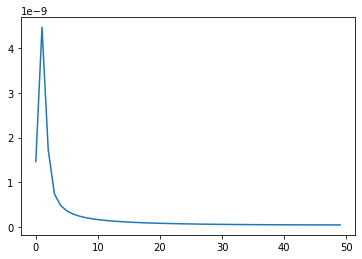

In [ ]:
tpCount     = len(Y)

values      = np.arange(int(tpCount/2))

timePeriod  = tpCount/100

frequencies = values/timePeriod
plt.plot(frequencies, abs(fourier))

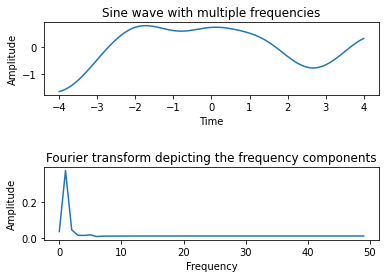

In [ ]:
# Python example - Fourier transform using numpy.fft method

import numpy as np

import matplotlib.pyplot as plotter

 

# How many time points are needed i,e., Sampling Frequency

samplingFrequency   = 100;

 

# At what intervals time points are sampled

samplingInterval       = 1 / samplingFrequency;

 

# Begin time period of the signals

beginTime           = -4;

 

# End time period of the signals

endTime             = 4; 

x, Y = sample_batch(10, samplingFrequency, GP, beginTime, endTime, x=1)

# Frequency of the signals

#signal1Frequency     = 5;

#signal2Frequency     = 9;

time = x

# Time points
amplitude = Y[:,2,0]
 

# Create two sine waves

#amplitude1 = np.sin(2*np.pi*signal1Frequency*time)

#amplitude2 = np.sin(2*np.pi*signal2Frequency*time)

 

# Create subplot

figure, axis = plotter.subplots(2, 1)

plotter.subplots_adjust(hspace=1)

 

# Add the sine waves

#amplitude = amplitude1 + amplitude2

 

# Time domain representation of the resultant sine wave

axis[0].set_title('Sine wave with multiple frequencies')

axis[0].plot(time, amplitude)

axis[0].set_xlabel('Time')

axis[0].set_ylabel('Amplitude')

 

# Frequency domain representation

fourierTransform = np.fft.fft(amplitude)/len(amplitude)           # Normalize amplitude

fourierTransform = fourierTransform[range(int(len(amplitude)/2))] # Exclude sampling frequency

fourierTransform = fourierTransform.real

tpCount     = len(amplitude)

values      = np.arange(int(tpCount/2))

timePeriod  = tpCount/samplingFrequency

frequencies = values/timePeriod

 

# Frequency domain representation

axis[1].set_title('Fourier transform depicting the frequency components')

 

axis[1].plot(frequencies, abs(fourierTransform))

axis[1].set_xlabel('Frequency')

axis[1].set_ylabel('Amplitude')

 

plotter.show()

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


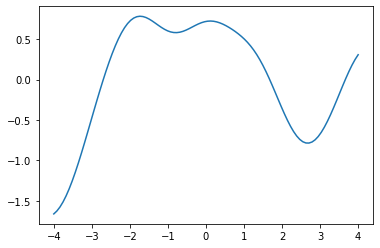

In [ ]:
fourierTransform = np.fft.fft(amplitude)
plt.plot(time, np.fft.ifft(fourierTransform))

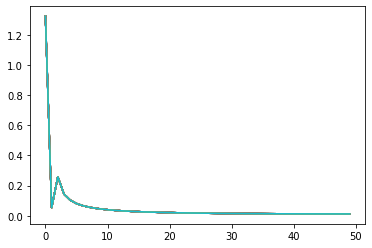

In [ ]:
import matplotlib.pyplot as plt
for i in range(30):
  plt.plot(frequencies, abs(fourier[i,:]))